# 0 IMPORTS

In [2]:
import pandas as pd
import numpy as np
import inflection
import math
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
#import random
import pickle
import requests
import json

from scipy import stats as ss
from matplotlib.gridspec import GridSpec
from datetime import datetime, timedelta
from boruta import BorutaPy
from IPython.display import Image
from IPython.display import display, HTML

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error as sk_mape

warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [3]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list  = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, kfold + 1)):
        
        if verbose:
            print('\nKFold Number: {}'.format(k))
        
        # Definindo janela de validação (6 semanas por fold)
        validation_start_date = x_training['date'].max() - timedelta(days=k*6*7)
        validation_end_date   = x_training['date'].max() - timedelta(days=(k-1)*6*7)
        
        # Separando treino e validação (sem leakage!)
        training   = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & 
                                (x_training['date'] <= validation_end_date)]
        
        # Preparando features e target
        xtraining    = training.drop(['date', 'sales'], axis=1)
        ytraining    = training['sales']
        
        xvalidation  = validation.drop(['date', 'sales'], axis=1)
        yvalidation  = validation['sales']
        
        # Treinando o modelo
        m = model.fit(xtraining, ytraining)
        
        # Fazendo predição
        yhat = m.predict(xvalidation)
        
        # Calculando métricas (com expm1 porque target está em log)
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # Armazenando resultados de cada fold
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    # Retornando tabela com média ± desvio padrão
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE CV':  np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
    }, index=[0])


def mean_percentage_error(y, yhat):
    """MPE - Mede viés (sinal positivo/negativo)"""
    return np.mean((y - yhat) / y)


def mean_absolute_percentage_error(y, yhat):
    """MAPE - Erro percentual absoluto médio (em decimal ou %)"""
    return np.mean(np.abs((y - yhat) / y))


def ml_error(model_name, y_true, y_pred):
    """
    Retorna tabela com métricas de performance do modelo
    """
    mae  = mean_absolute_error(y_true, y_pred)
    mape = sk_mape(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE':  mae,
        'MAPE': mape,  
        'RMSE': rmse
    }, index=[0])


def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    chi2, p, dof, ex = ss.chi2_contingency(cm, correction=False)
    n = cm.sum()
    r, k = cm.shape

    return np.sqrt((chi2 / n) / (min(k - 1, r - 1)))



def vscode_settings():
    """Configurações coringa de visualização para matplotlib, seaborn e pandas"""
    
    # Inline plots
    %matplotlib inline
    
    # Estilo Matplotlib
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]  
    plt.rcParams['font.size'] = 20
    plt.rcParams['axes.titlesize'] = 24
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16
    
    # Ajuste da largura do container do Jupyter
    display(HTML('<style>.container { width:100% !important; }</style>'))
    
    # Seaborn
    sns.set_palette("Set2")      
    sns.set_context("notebook")   
    sns.set_style("whitegrid")


In [3]:
vscode_settings()

## 0.2 Load data

In [4]:
import os
os.getcwd()

'/mnt/c/users/carlo/onedrive/repos/ds_producao/notebooks'

In [4]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1 DATA DESCRIPTION

In [6]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Confirm NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [ ]:
# competition_distance: substitui NaN por 200000.0
df1['competition_distance'] = np.where(
    pd.isna(df1['competition_distance']),
    200000.0,
    df1['competition_distance']
)

# competition_open_since_month: substitui NaN pelo mês da venda
df1['competition_open_since_month'] = np.where(
    pd.isna(df1['competition_open_since_month']),
    df1['date'].dt.month,
    df1['competition_open_since_month']
)

# competition_open_since_year: substitui NaN pelo ano da venda
df1['competition_open_since_year'] = np.where(
    pd.isna(df1['competition_open_since_year']),
    df1['date'].dt.year,
    df1['competition_open_since_year']
)

# promo2_since_week: substitui NaN pela semana da venda
df1['promo2_since_week'] = np.where(
    pd.isna(df1['promo2_since_week']),
    df1['date'].dt.isocalendar().week,
    df1['promo2_since_week']
)

# promo2_since_year: substitui NaN pelo ano da venda
df1['promo2_since_year'] = np.where(
    pd.isna(df1['promo2_since_year']),
    df1['date'].dt.year,
    df1['promo2_since_year']
)

# promo_interval
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

df1['promo_interval'] = df1['promo_interval'].fillna(0)

# map do mês da venda
df1['month_map'] = df1['date'].dt.month.map(month_map)

# coluna is_promo
df1['is_promo'] = (df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval']
                                                      .split(',') else 0, axis=1))

In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [13]:
df1.sample(5).T

540396               916246   \
store                                         407                  502   
day_of_week                                     2                    1   
date                          2014-03-04 00:00:00  2013-04-01 00:00:00   
sales                                        3984                    0   
customers                                     304                    0   
open                                            1                    0   
promo                                           1                    0   
state_holiday                                   0                    b   
school_holiday                                  1                    1   
store_type                                      a                    a   
assortment                                      a                    a   
competition_distance                       5890.0                220.0   
competition_open_since_month                 10.0                  2.0   
competition_open_since_year                2003.0               2002.0   
promo2                                          1                    1   
promo2_since_week                            14.0                 37.0   
promo2_since_year                          2011.0               2009.0   
promo_interval                    Feb,May,Aug,Nov      Jan,Apr,Jul,Oct   
month_map                                     Mar                  Apr   
is_promo                                        0                    1   

                                          16020                1016916  \
store                                         411                  822   
day_of_week                                     5                    2   
date                          2015-07-17 00:00:00  2013-01-01 00:00:00   
sales                                       10040                    0   
customers                                     780                    0   
open                                            1                    0   
promo                                           1                    0   
state_holiday                                   0                    a   
school_holiday                                  0                    1   
store_type                                      d                    a   
assortment                                      c                    c   
competition_distance                       8460.0                410.0   
competition_open_since_month                  7.0                 11.0   
competition_open_since_year                2015.0               2010.0   
promo2                                          0                    1   
promo2_since_week                            29.0                 48.0   
promo2_since_year                          2015.0               2010.0   
promo_interval                                  0     Mar,Jun,Sept,Dec   
month_map                                     Jul                  Jan   
is_promo                                        0                    0   

                                          350468   
store                                          21  
day_of_week                                     7  
date                          2014-08-31 00:00:00  
sales                                           0  
customers                                       0  
open                                            0  
promo                                           0  
state_holiday                                   0  
school_holiday                                  0  
store_type                                      c  
assortment                                      c  
competition_distance                        550.0  
competition_open_since_month                 10.0  
competition_open_since_year                1999.0  
promo2                                          1  
promo2_since_week                            45.0  
promo2_since_year                          2009.

## 1.6 Change Types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df1[['competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year']] = (df1
                                                                                                                  [['competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year']].astype(int))

## 1.7 Descriptive Statistical

In [16]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical attributes

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T

# concatenate

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

m

attributes     min       max     range         mean  \
0                          store     1.0    1115.0    1114.0   558.429727   
1                    day_of_week     1.0       7.0       6.0     3.998341   
2                          sales     0.0   41551.0   41551.0  5773.818972   
3                      customers     0.0    7388.0    7388.0   633.145946   
4                           open     0.0       1.0       1.0     0.830107   
5                          promo     0.0       1.0       1.0     0.381515   
6                 school_holiday     0.0       1.0       1.0     0.178647   
7           competition_distance    20.0  200000.0  199980.0  5935.442677   
8   competition_open_since_month     1.0      12.0      11.0     6.786849   
9    competition_open_since_year  1900.0    2015.0     115.0  2010.324840   
10                        promo2     0.0       1.0       1.0     0.500564   
11             promo2_since_week     1.0      52.0      51.0    23.619033   
12             promo2_since_year  2009.0    2015.0       6.0  2012.793297   
13                      is_promo     0.0       1.0       1.0     0.165966   

    median           std       skew    kurtosis  
0    558.0    321.908493  -0.000955   -1.200524  
1      4.0      1.997390   0.001593   -1.246873  
2   5744.0   3849.924283   0.641460    1.778375  
3    609.0    464.411506   1.598650    7.091773  
4      1.0      0.375539  -1.758045    1.090723  
5      0.0      0.485758   0.487838   -1.762018  
6      0.0      0.383056   1.677842    0.815154  
7   2330.0  12547.646829  10.242344  147.789712  
8      7.0      3.311085  -0.042076   -1.232607  
9   2012.0      5.515591  -7.235657  124.071304  
10     1.0      0.500000  -0.002255   -1.999999  
11    22.0     14.310057   0.178723   -1.184046  
12  2013.0      1.662657  -0.784436   -0.210075  
13     0.0      0.372050   1.795644    1.224338

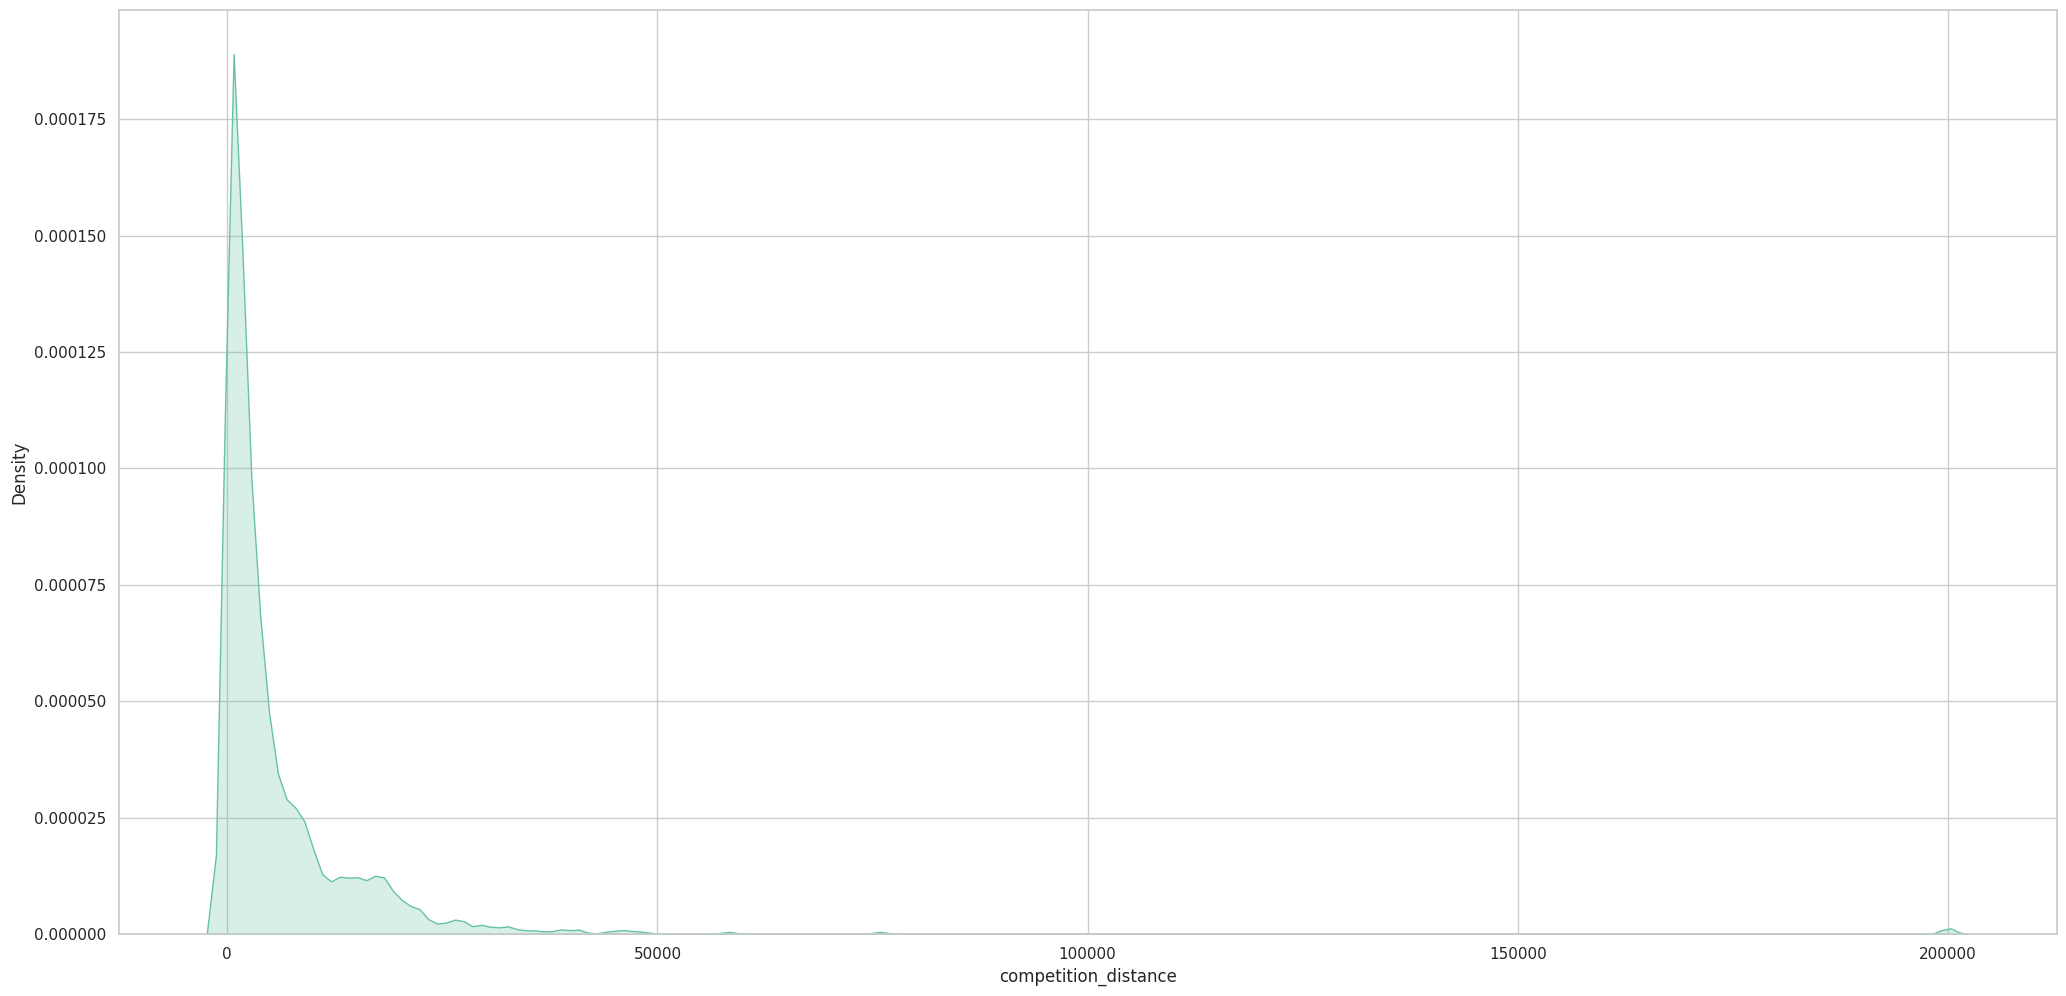

In [18]:
sns.kdeplot(df1['competition_distance'], fill=True)
plt.show()

### 1.7.1 Categorical attributes

In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

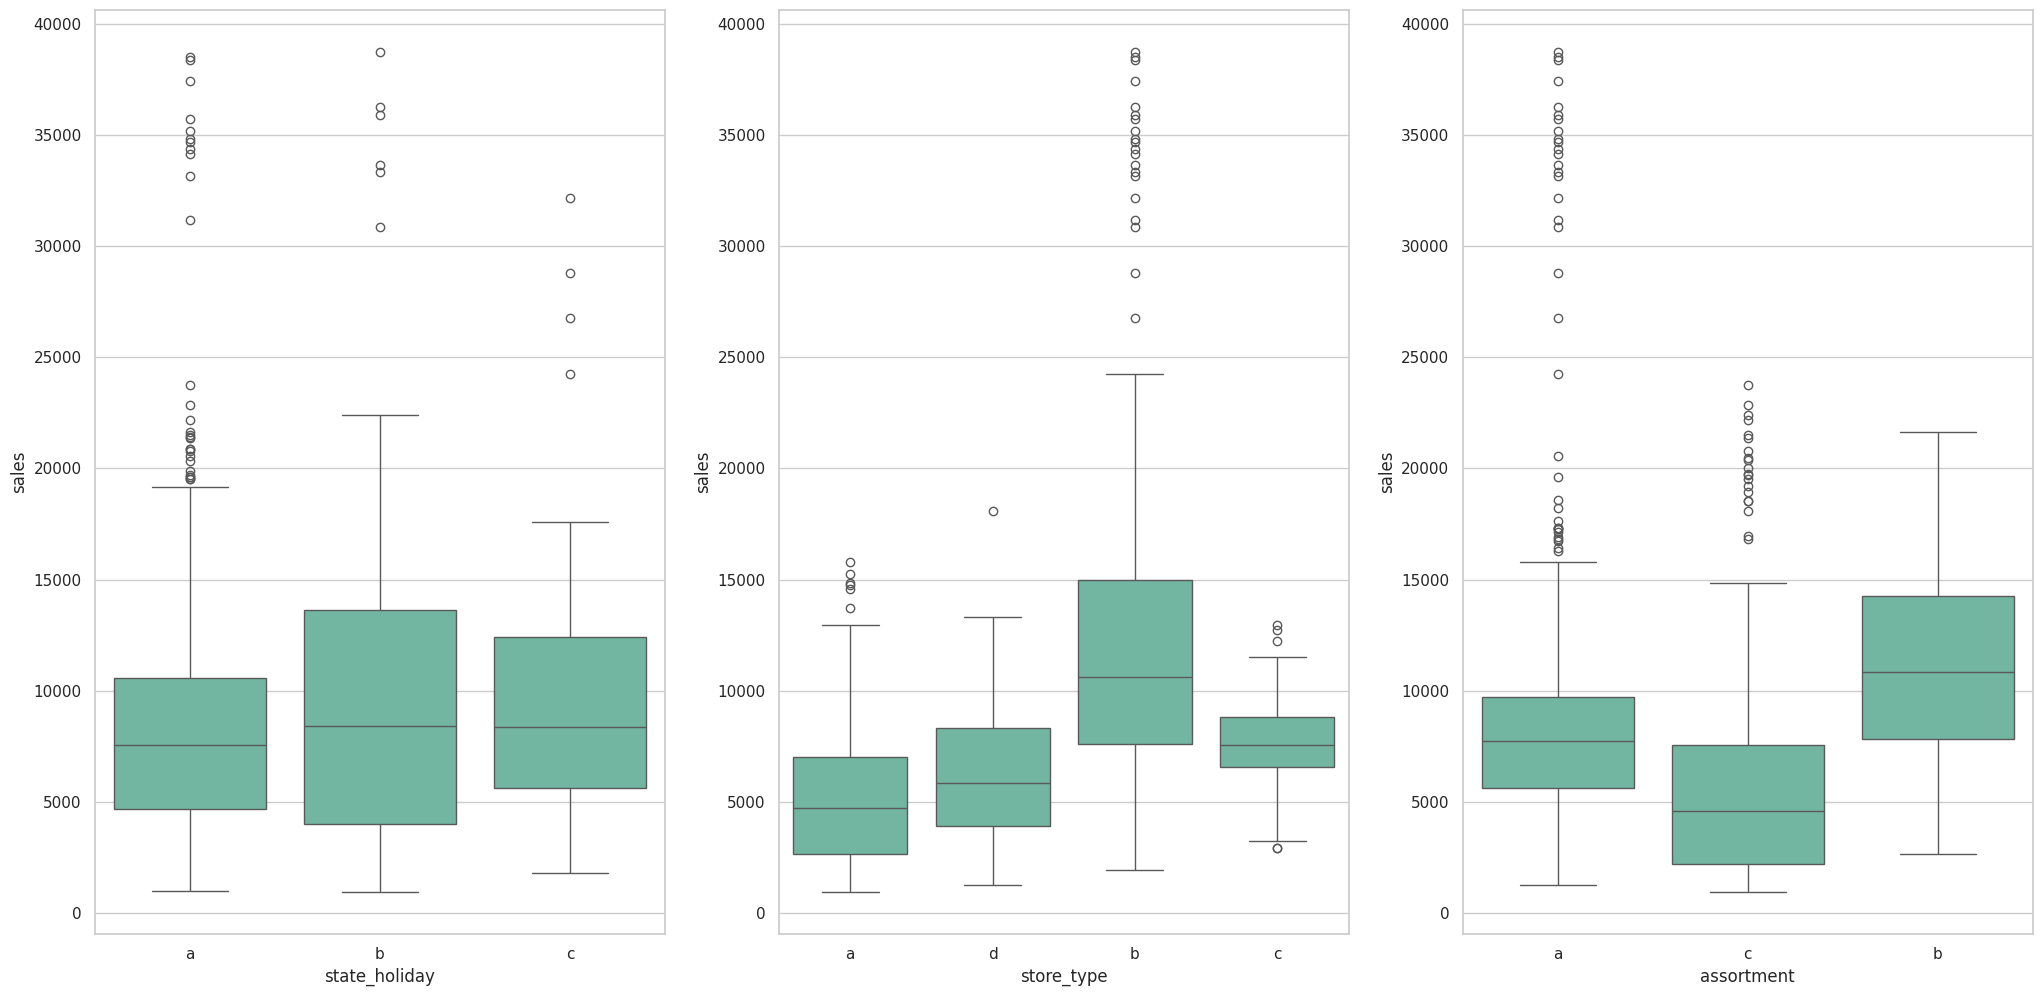

In [20]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

plt.show()

# 2.0 FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

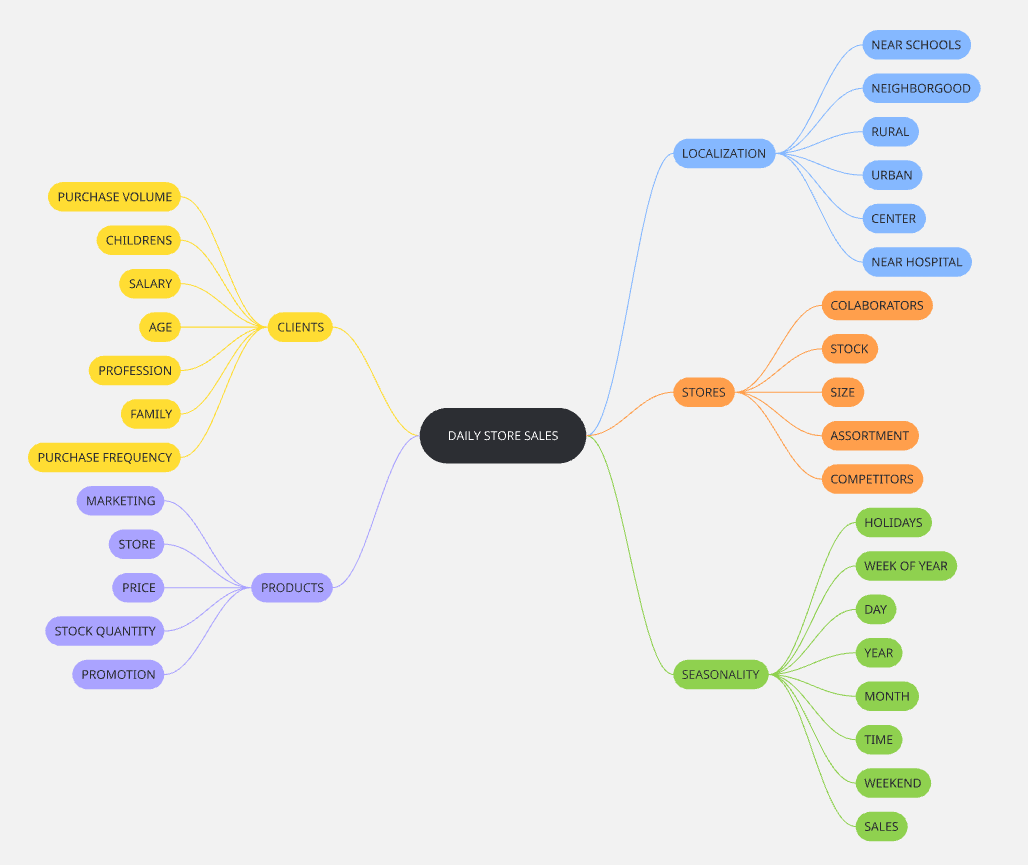

In [22]:
Image('../img/mind_map.png')

## 2.1 Creation of Hypotheses

### 2.1.1 Hypotheeses Store

**1 -** Lojas com numero maior de funcionarios deveriam vender mais.

**2 -** Lojas com maior capacidade de estoque deveriam vender mais.

**3 -** Lojas com maior porte deveriam vender mais.

**4 -** Lojas com maior variedade deveriam vender mais.

**5 -** Lojas com competidores mais proximos deveriam vender menos.

**6 -** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2 Hypotheeses Product

**1 -** Lojas que investem mais em Marketing deveriam vender mais.

**2 -** Lojas com maior exposicao de produtos deveriam vender mais.

**3 -** Lojas com produtos com preco menor deveriam vender mais.

**4 -** Lojas com promocoes mais agressivas deveriam vender mais.

**5 -** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**6 -** Lojas com mais dias de promocao deveriam vender mais.

**7 -** Lojas com mais promocoes consecutivas deveriam vender mais.

### 2.1.2 Hypotheeses Seasonality

**1 -** Lojas abertas durante o feriado de natal deveriam vender mais.

**2 -** Lojas deveriam vender mais ao longo dos anos.

**3 -** Lojas deveriam vender mais no segundo semestre do ano

**4 -** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5 -** Lojas deveriam vender menos aos finais de semana.

**6 -** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Final List - Hypotheses

**1 -** Lojas com maior variedade deveriam vender mais.

**2 -** Lojas com competidores mais proximos deveriam vender menos.

**3 -** Lojas com competidores a mais tempo deveriam vender mais.

-----------

**4 -** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5 -** Lojas com mais dias de promocao deveriam vender mais.

**6 -** Lojas com mais promocoes consecutivas deveriam vender mais.

-----------

**7 -** Lojas abertas durante o feriado de natal deveriam vender mais.

**8 -** Lojas deveriam vender mais ao longo dos anos.

**9 -** Lojas deveriam vender mais no segundo semestre do ano

**10 -** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11 -** Lojas deveriam vender menos aos finais de semana.

**12 -** Lojas deveriam vender menos durante os feriados escolares.


## 2.3 Feature Engineering

In [ ]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(
    lambda x: datetime(year=int(x['competition_open_since_year']), month=int(x['competition_open_since_month']), day=1),
    axis=1
)
# competition_time_month (aproximação com meses de 30 dias)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / timedelta(days=30)).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(
    lambda x: datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days=7)
)
# promo_time_week
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / timedelta(weeks=1)).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(
    lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


In [24]:
df2.sample(5).T

409292               920379  \
store                                         873                  175   
day_of_week                                     1                    4   
date                          2014-06-30 00:00:00  2013-03-28 00:00:00   
sales                                        5095                 8893   
customers                                     541                  981   
open                                            1                    1   
promo                                           1                    1   
state_holiday                         regular_day          regular_day   
school_holiday                                  0                    0   
store_type                                      a                    c   
assortment                                  basic                basic   
competition_distance                       2040.0               4130.0   
competition_open_since_month                   11                    3   
competition_open_since_year                  2008                 2013   
promo2                                          0                    0   
promo2_since_week                              27                   13   
promo2_since_year                            2014                 2013   
promo_interval                                  0                    0   
month_map                                     Jun                  Mar   
is_promo                                        0                    0   
year                                         2014                 2013   
month                                           6                    3   
day                                            30                   28   
week_of_year                                   27                   13   
year_week                                 2014-26              2013-12   
competition_since             2008-11-01 00:00:00  2013-03-01 00:00:00   
competition_time_month                         68                    0   
promo_since                   2014-06-30 00:00:00  2013-03-25 00:00:00   
promo_time_week                                 0                    0   

                                           685717               361918  \
store                                         778                  304   
day_of_week                                     5                    2   
date                          2013-10-25 00:00:00  2014-08-19 00:00:00   
sales                                        5219                 7743   
customers                                     755                 1071   
open                                            1                    1   
promo                                           1                    1   
state_holiday                         regular_day          regular_day   
school_holiday                                  0                    1   
store_type                                      a                    a   
assortment                                  basic                basic   
competition_distance                        340.0               1950.0   
competition_open_since_month                    6                    7   
competition_open_since_year                  2003                 2015   
promo2                                          1                    0   
promo2_since_week                              40                   34   
promo2_since_year                            2014                 2014   
promo_interval                    Jan,Apr,Jul,Oct                    0   
month_map                                     Oct                  Aug   
is_promo                                        1                    0   
year                                         2013                 2014   
month                                          10                    8   
day                                            25                   19   
week_of_year                                  

# 3.0 VARIABLE FILTERING

In [25]:
df3 = df2.copy()

In [26]:
df3.head()

store  day_of_week       date  sales  customers  open  promo state_holiday  \
0      1            5 2015-07-31   5263        555     1      1   regular_day   
1      2            5 2015-07-31   6064        625     1      1   regular_day   
2      3            5 2015-07-31   8314        821     1      1   regular_day   
3      4            5 2015-07-31  13995       1498     1      1   regular_day   
4      5            5 2015-07-31   4822        559     1      1   regular_day   

   school_holiday store_type  ... is_promo  year  month  day  week_of_year  \
0               1          c  ...        0  2015      7   31            31   
1               1          a  ...        1  2015      7   31            31   
2               1          a  ...        1  2015      7   31            31   
3               1          c  ...        0  2015      7   31            31   
4               1          a  ...        0  2015      7   31            31   

   year_week  competition_since competition_time_month promo_since  \
0    2015-30         2008-09-01                     84  2015-07-27   
1    2015-30         2007-11-01                     94  2010-03-22   
2    2015-30         2006-12-01                    105  2011-03-28   
3    2015-30         2009-09-01                     71  2015-07-27   
4    2015-30         2015-04-01                      4  2015-07-27   

   promo_time_week  
0                0  
1              279  
2              226  
3                0  
4                0  

[5 rows x 29 columns]

## 3.1 Line Filtering

In [27]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [29]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 EDA

In [30]:
df4 = df3.copy()

**1 -** Lojas com maior sortimento deveriam vender mais.

**2 -** Lojas com competidores mais proximos deveriam vender menos.

**3 -** Lojas com competidores a mais tempo deveriam vender mais.

-----------

**4 -** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5 -** Lojas com mais dias de promocao deveriam vender mais.

**6 -** Lojas com mais promocoes consecutivas deveriam vender mais.

-----------

**7 -** Lojas abertas durante o feriado de natal deveriam vender mais.

**8 -** Lojas deveriam vender mais ao longo dos anos.

**9 -** Lojas deveriam vender mais no segundo semestre do ano

**10 -** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11 -** Lojas deveriam vender menos aos finais de semana.

**12 -** Lojas deveriam vender menos durante os feriados escolares.


## 4.1 Univariate Analysis

### 4.1.1 Response Variable

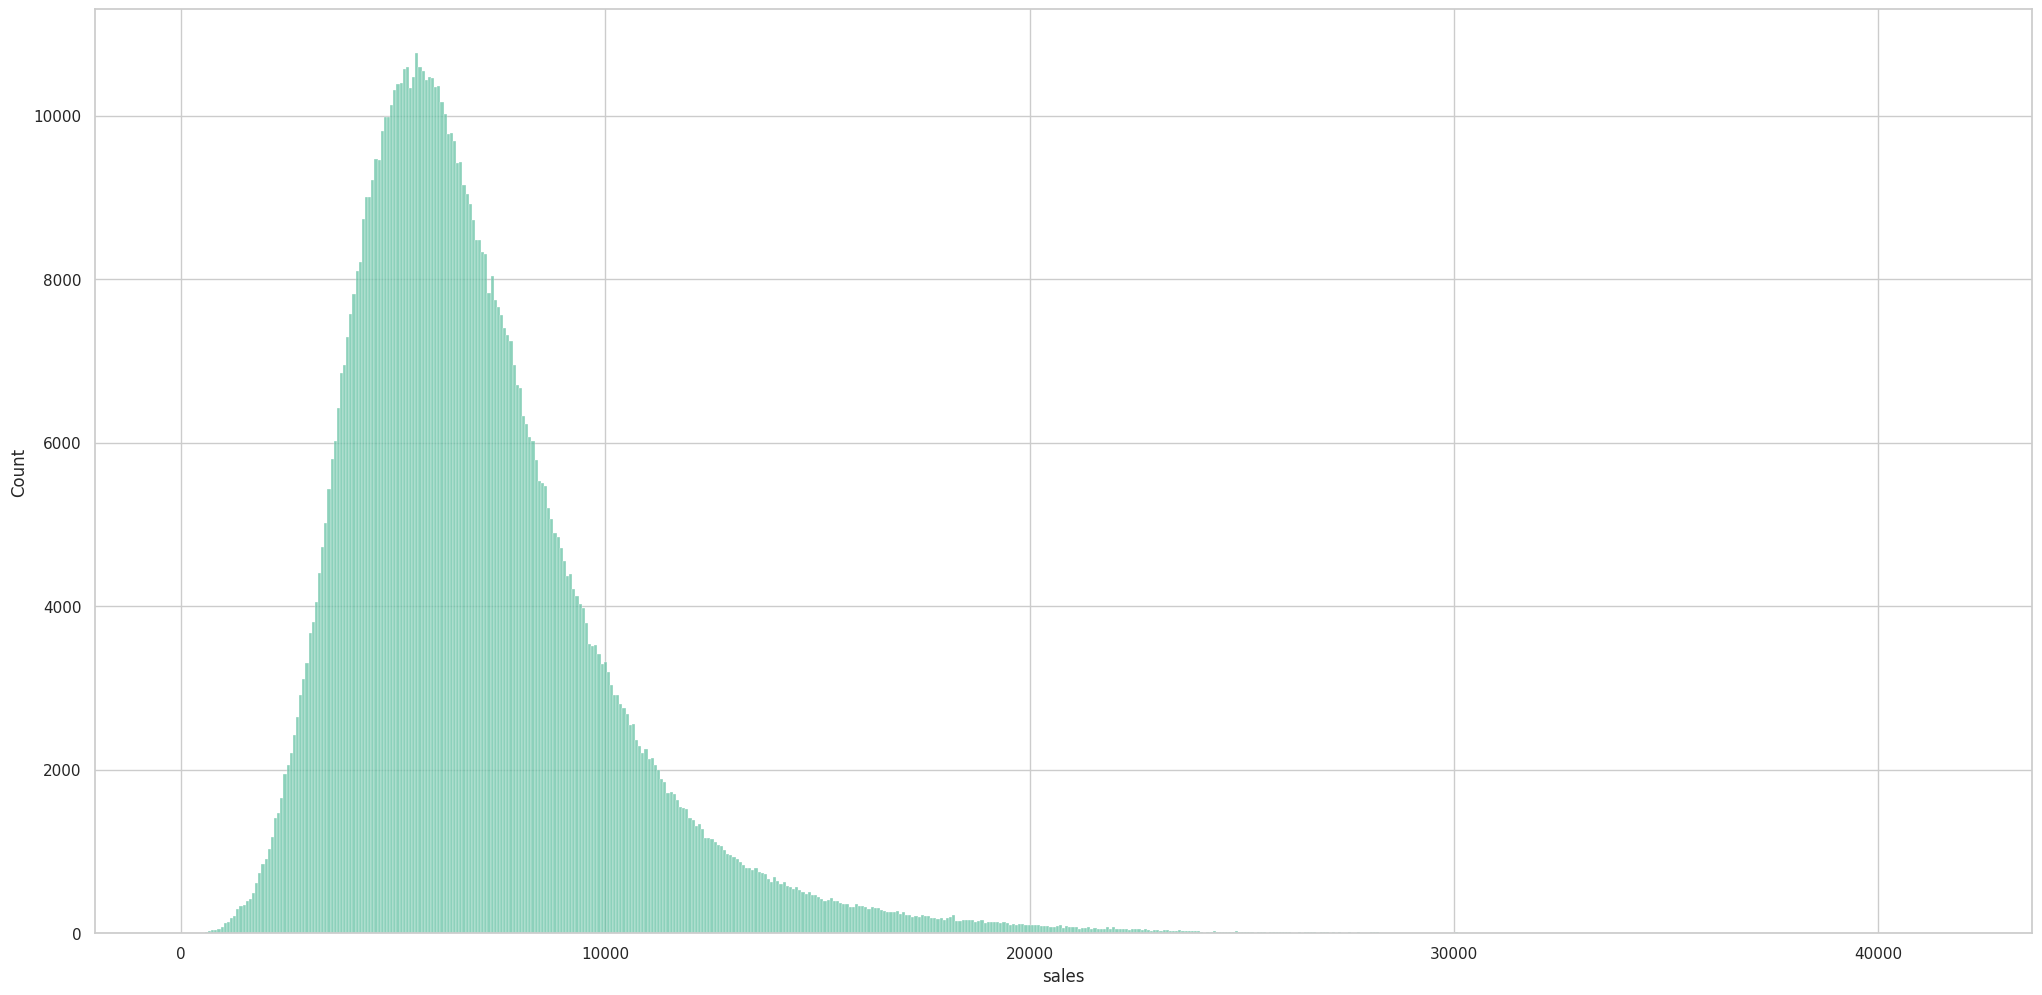

In [31]:
sns.histplot(df4['sales'], kde=False)
plt.show()

### 4.1.2 Numerical Variable

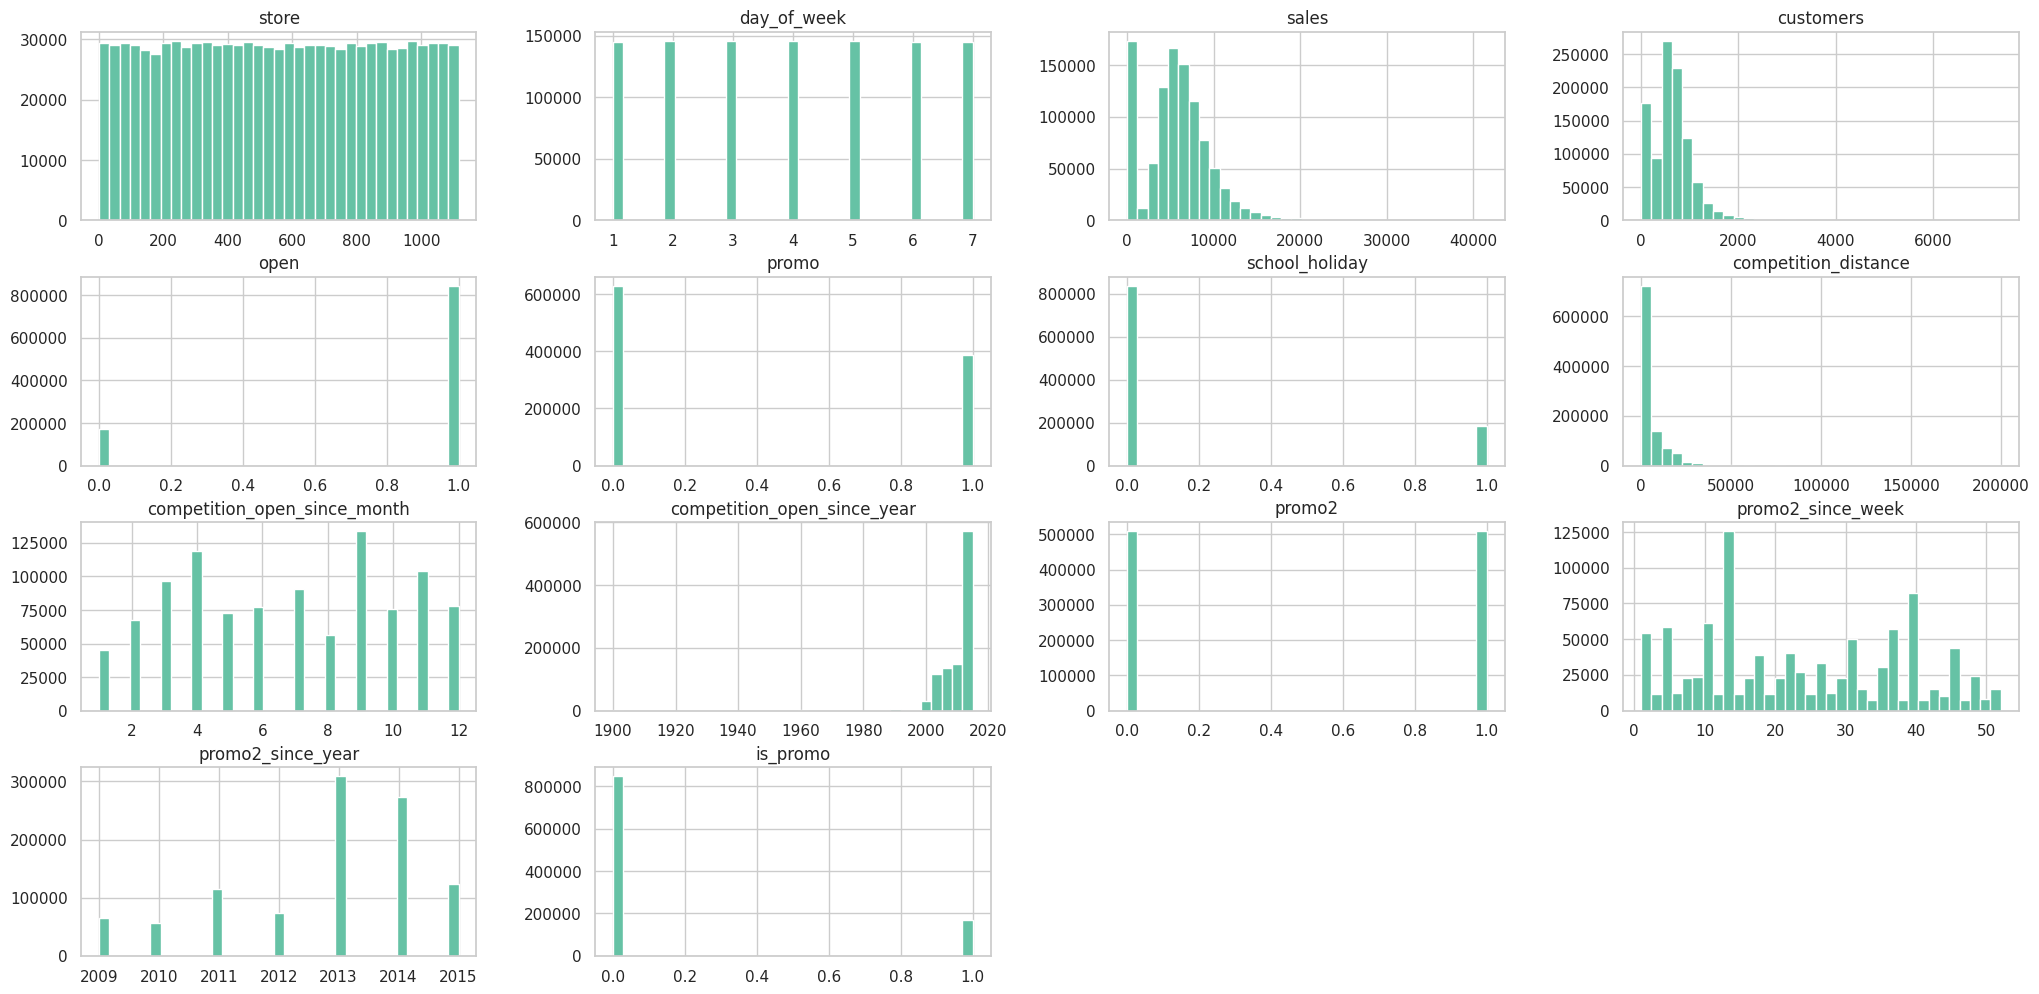

In [32]:
num_attributes.hist( bins=35);

### 4.1.3 Categorical Variable

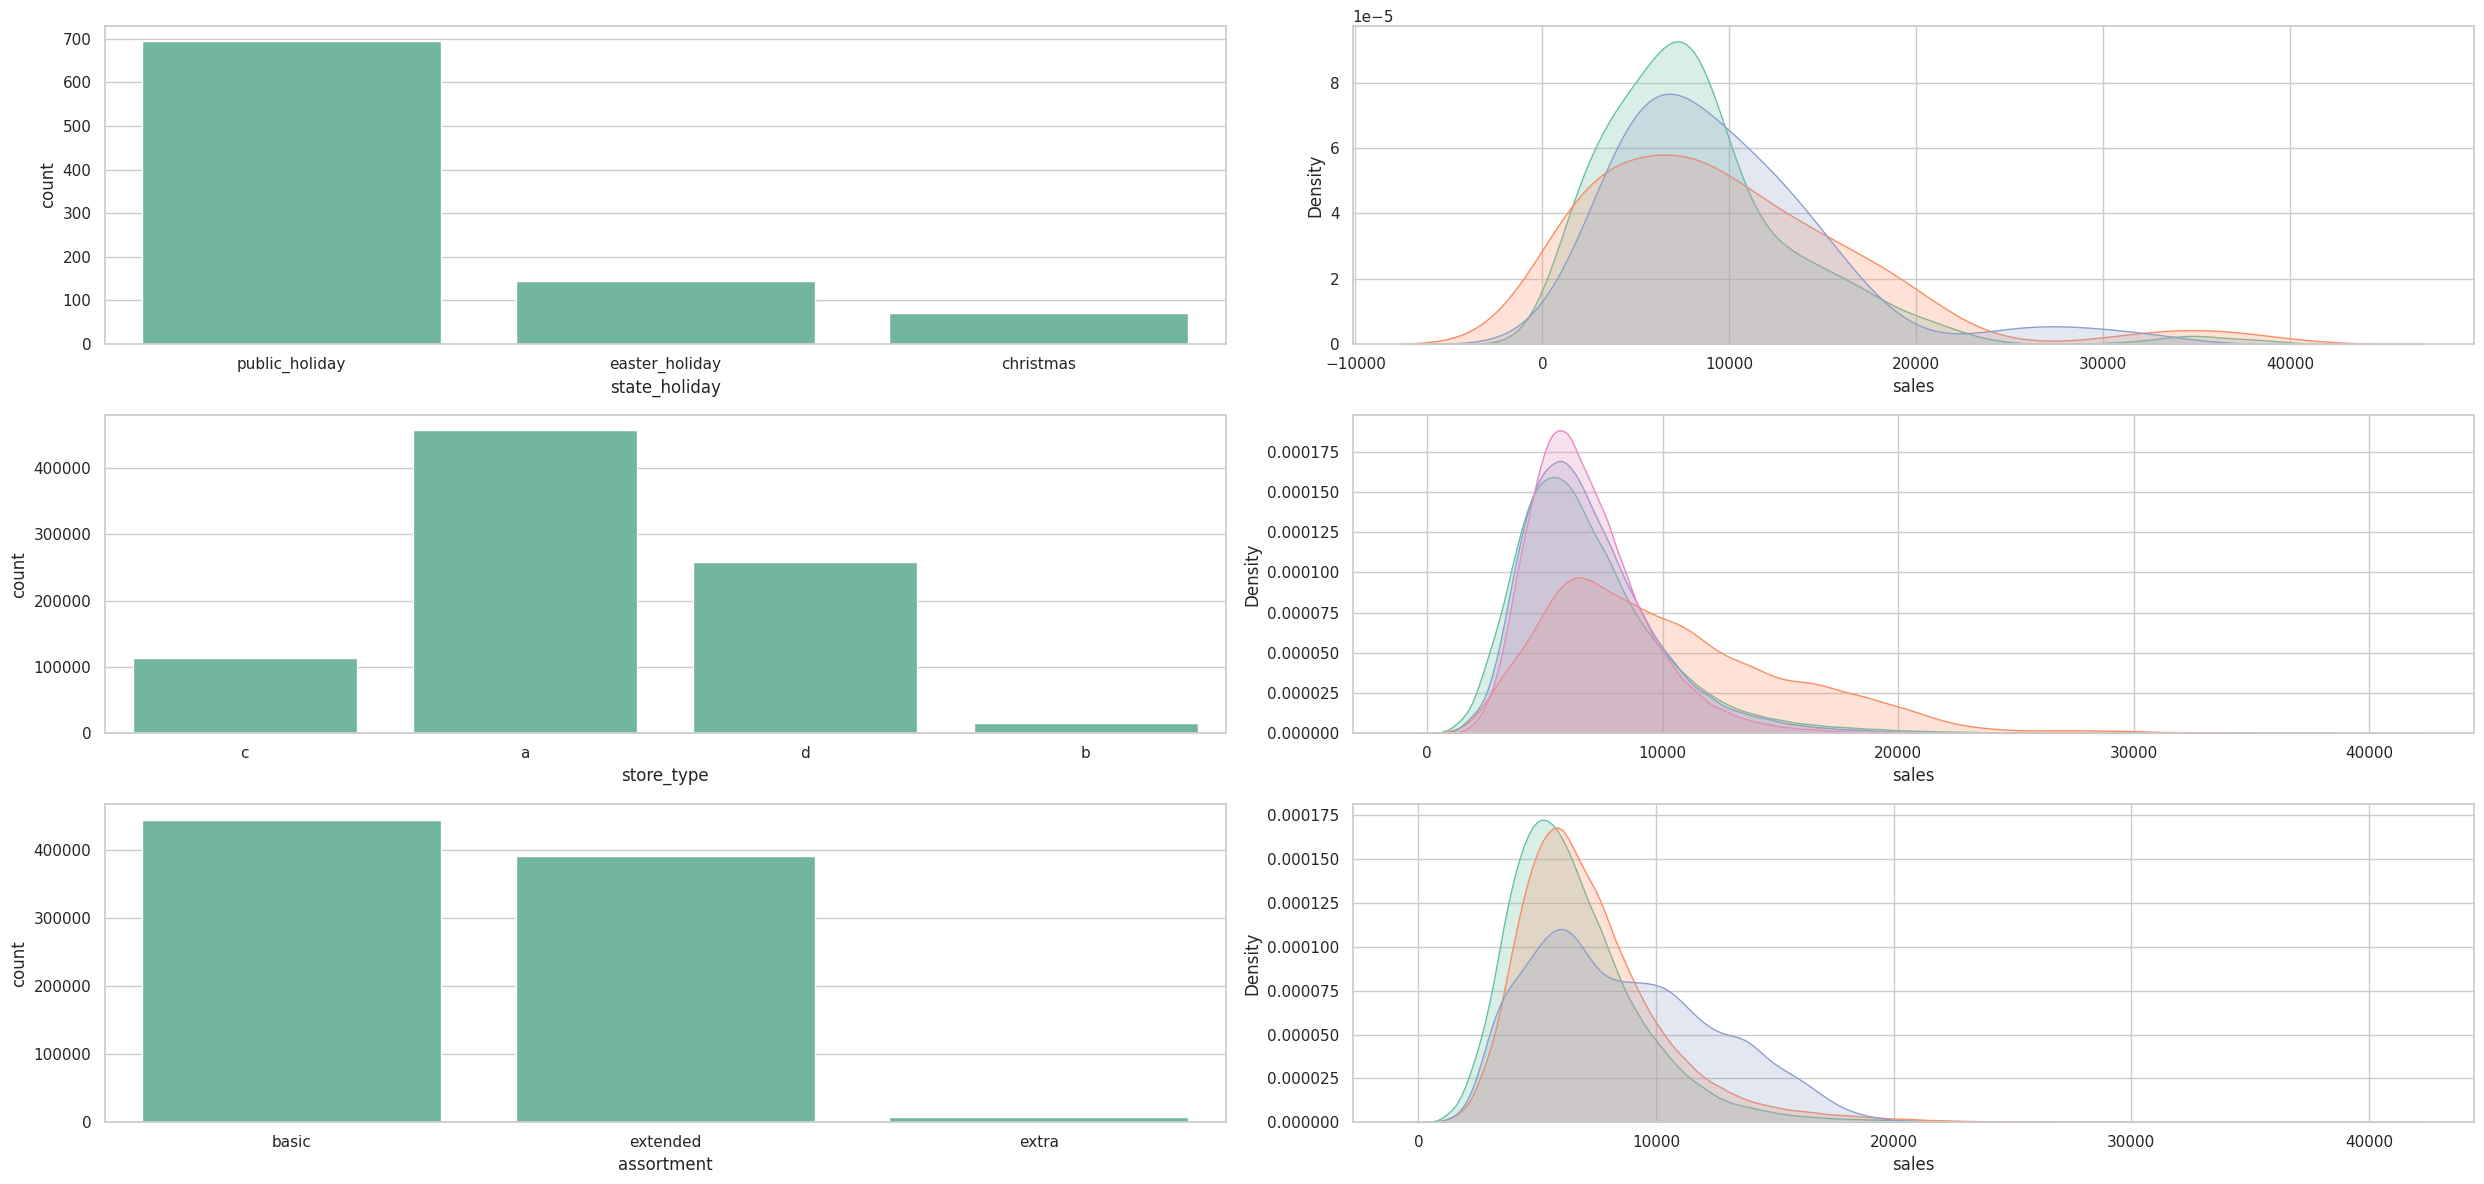

In [33]:
# state_holiday
plt.subplot(3, 2, 1)
sns.countplot(x='state_holiday', data=df4[df4['state_holiday'] != 'regular_day'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df4)

plt.subplot(3, 2, 4)
for stype in ['a', 'b', 'c', 'd']:
    sns.kdeplot(df4[df4['store_type'] == stype]['sales'], label=stype, fill=True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df4)

plt.subplot(3, 2, 6)
for assortment in ['basic', 'extended', 'extra']:
    sns.kdeplot(df4[df4['assortment'] == assortment]['sales'], label=assortment, fill=True)

plt.tight_layout()
plt.show()


## 4.2 Bivariate Analysis

### **H1 -** Lojas com maior sortimento deveriam vender mais.

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

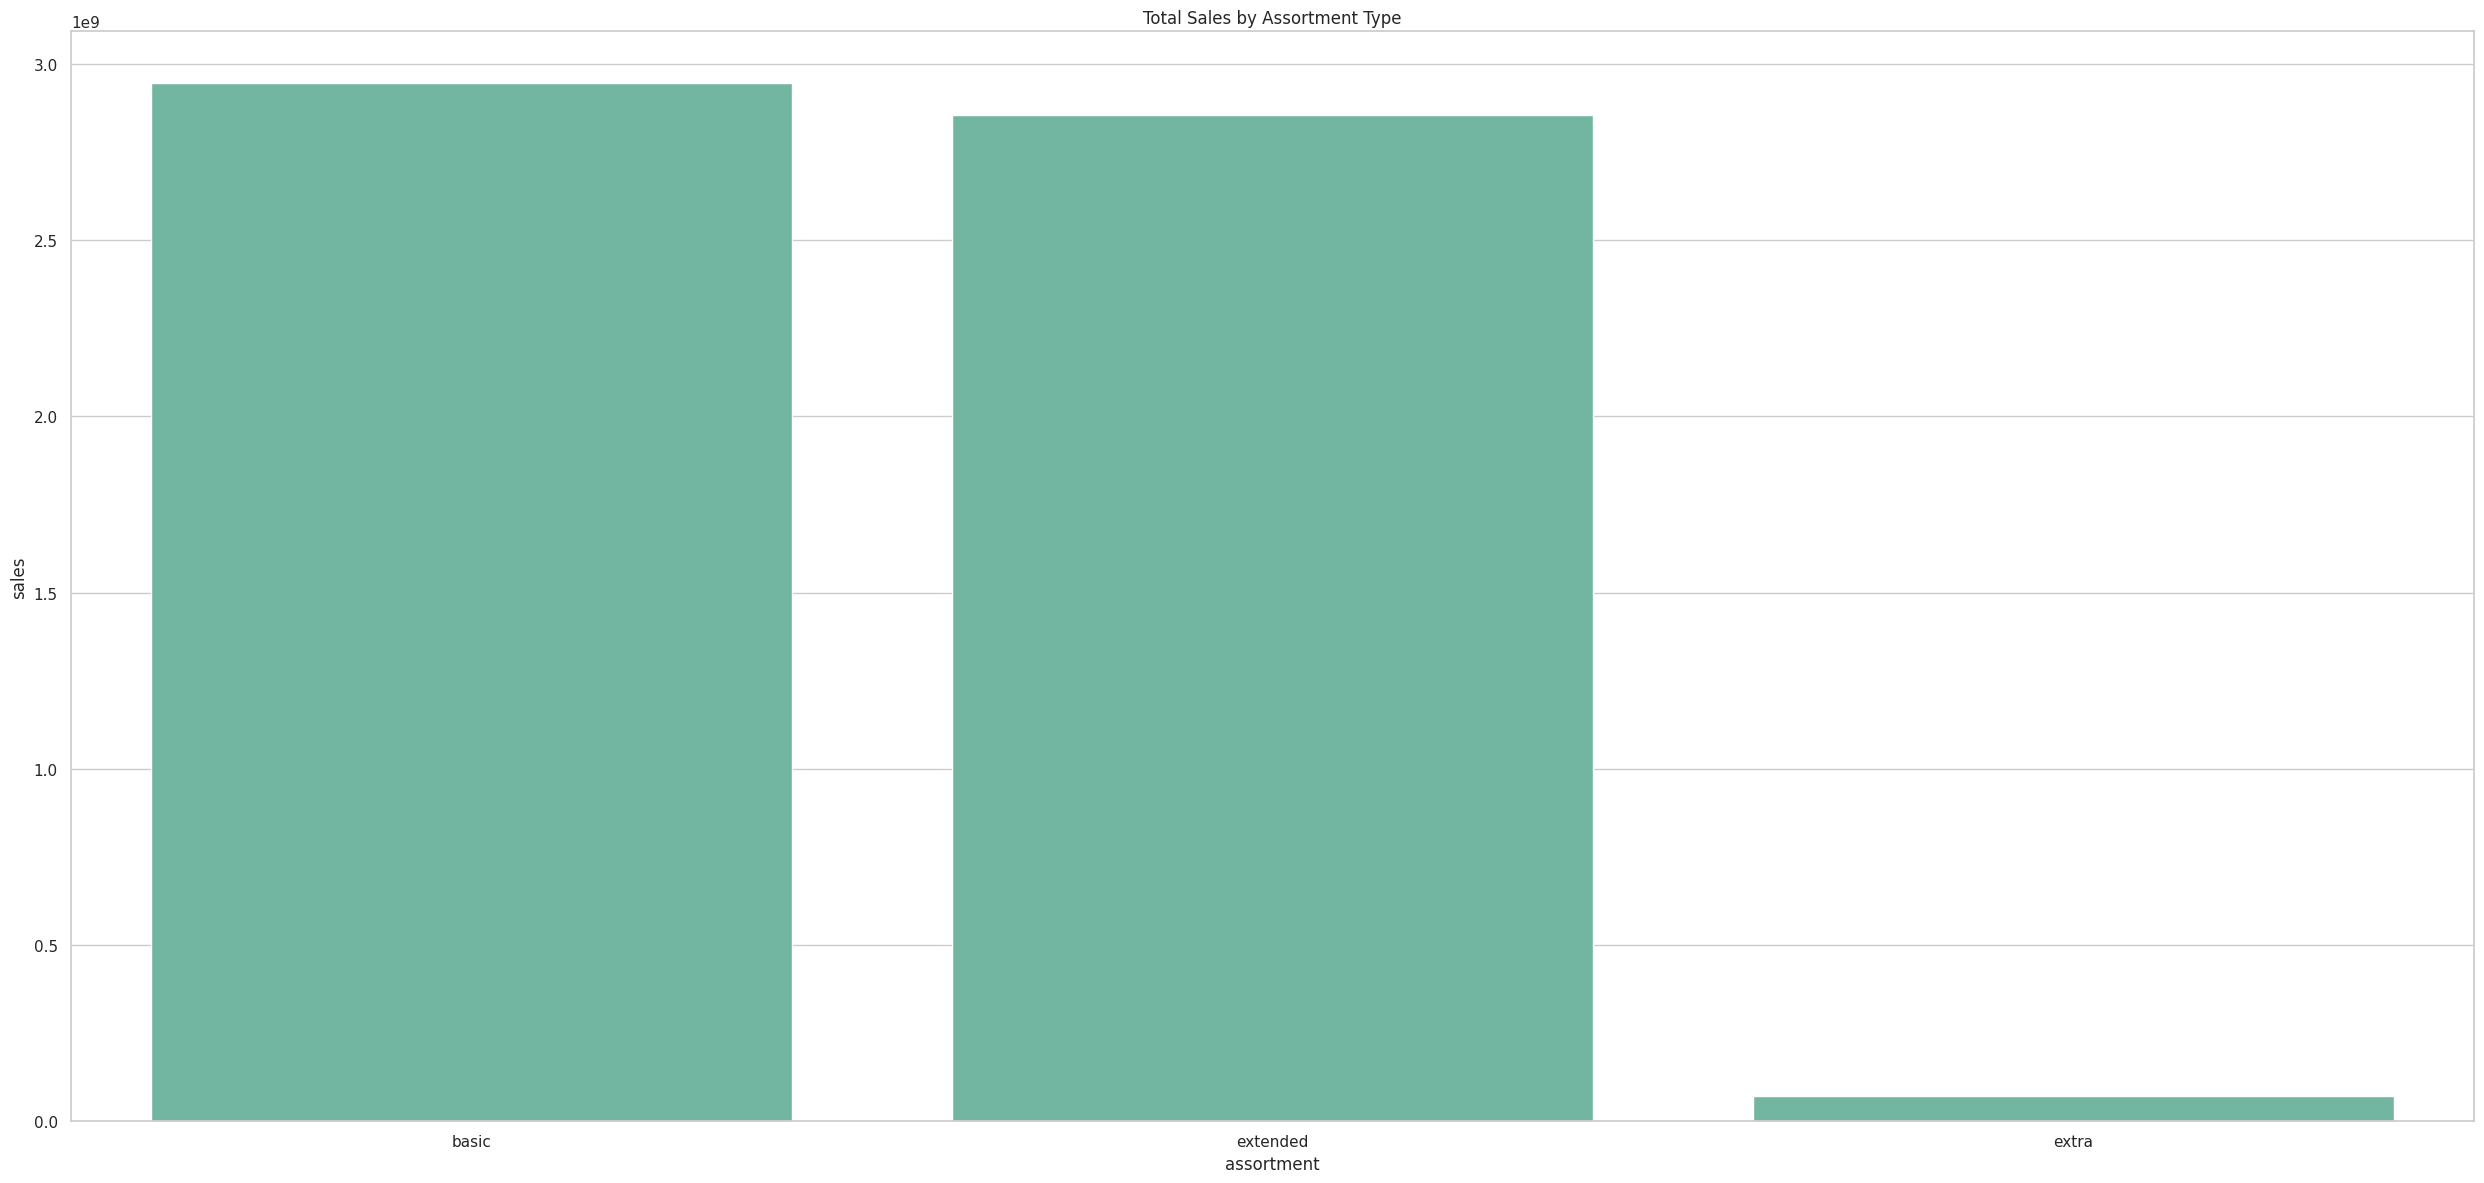

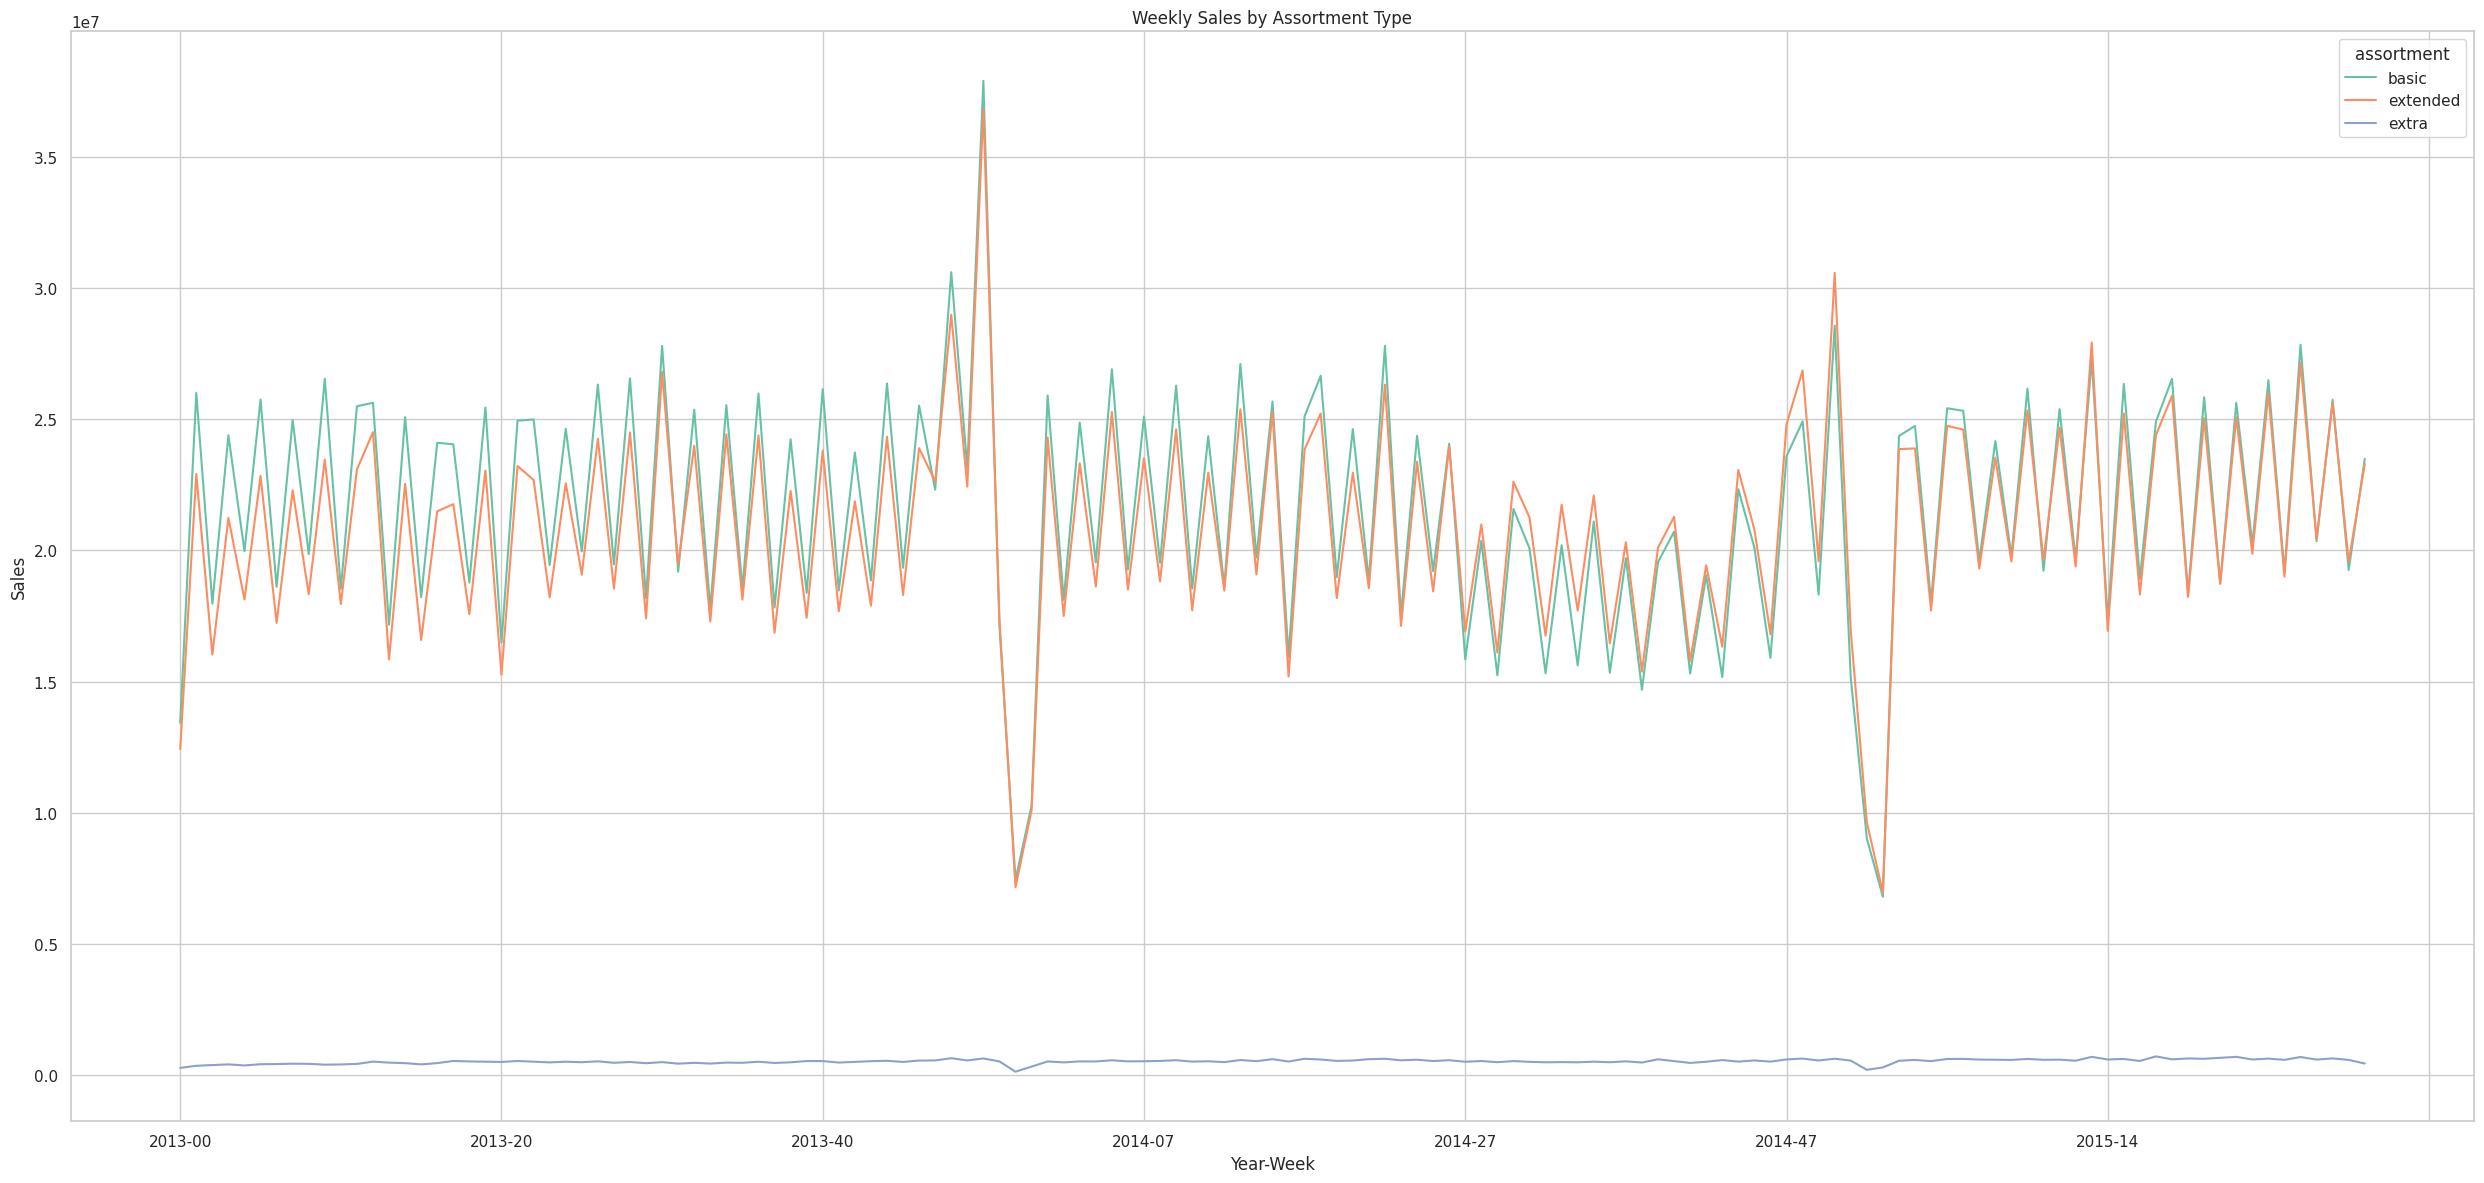

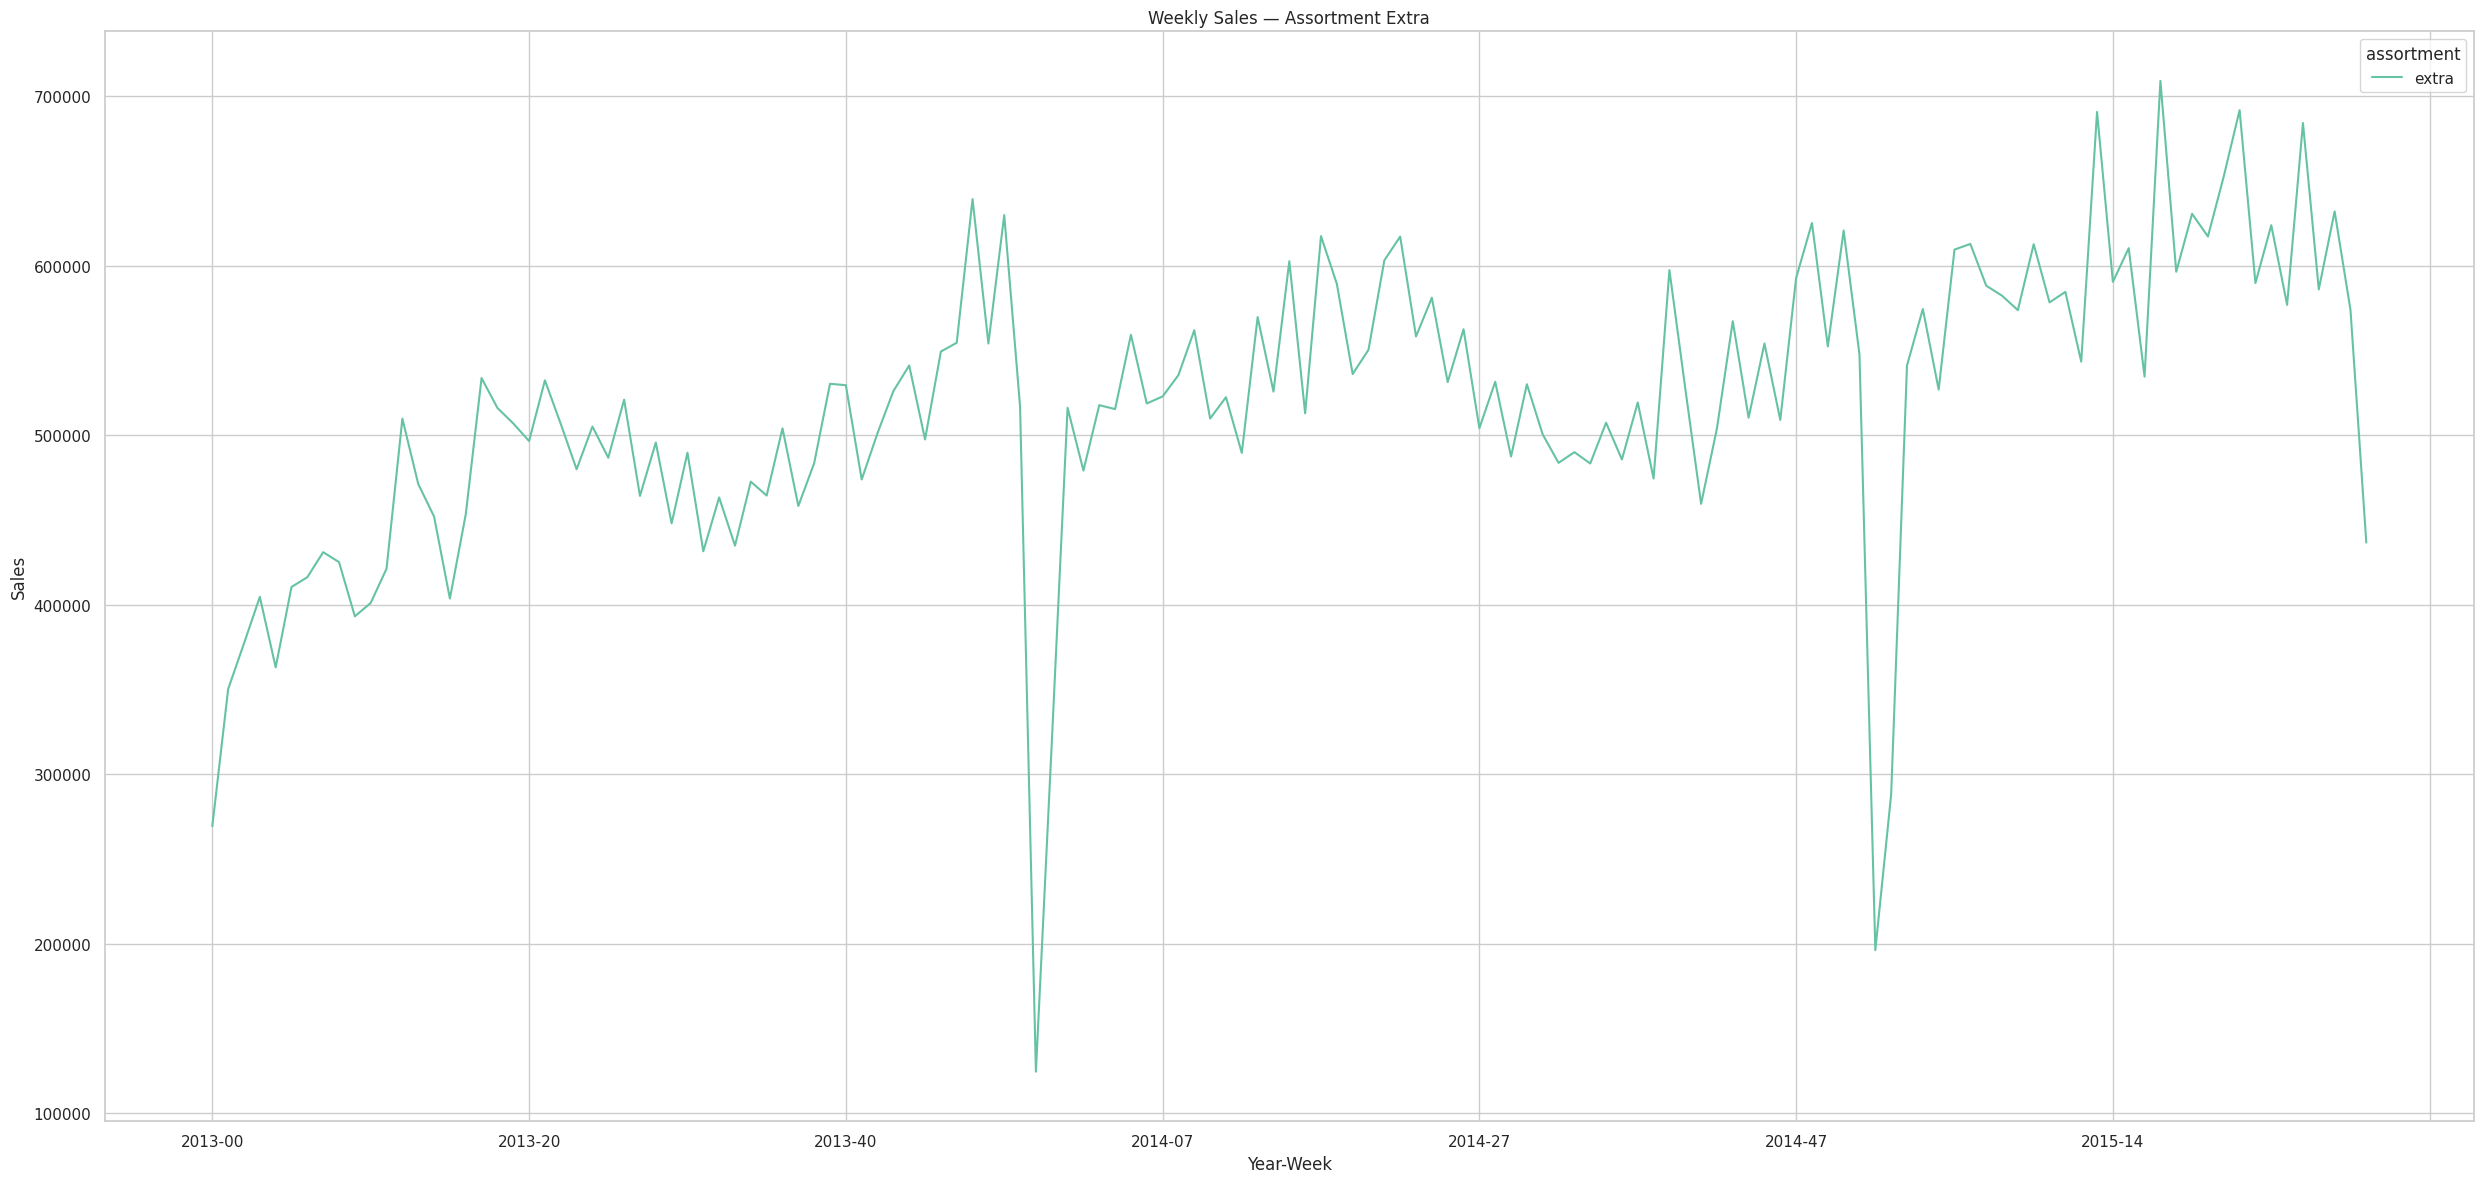

In [34]:
# -------------------------------
# Gráfico 1: Total Sales by Assortment
# -------------------------------
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)
plt.title("Total Sales by Assortment Type")
plt.tight_layout()
plt.show()

# -------------------------------
# Gráfico 2: Weekly Sales by Assortment
# -------------------------------
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
pivot2 = aux2.pivot(index='year_week', columns='assortment', values='sales')

pivot2.plot()
plt.title("Weekly Sales by Assortment Type")
plt.xlabel("Year-Week")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

# -------------------------------
# Gráfico 3: Weekly Sales — Assortment Extra
# -------------------------------
aux3 = aux2[aux2['assortment'] == 'extra']
pivot3 = aux3.pivot(index='year_week', columns='assortment', values='sales')

pivot3.plot()
plt.title("Weekly Sales — Assortment Extra")
plt.xlabel("Year-Week")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

### **H2 -** Lojas com competidores mais proximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

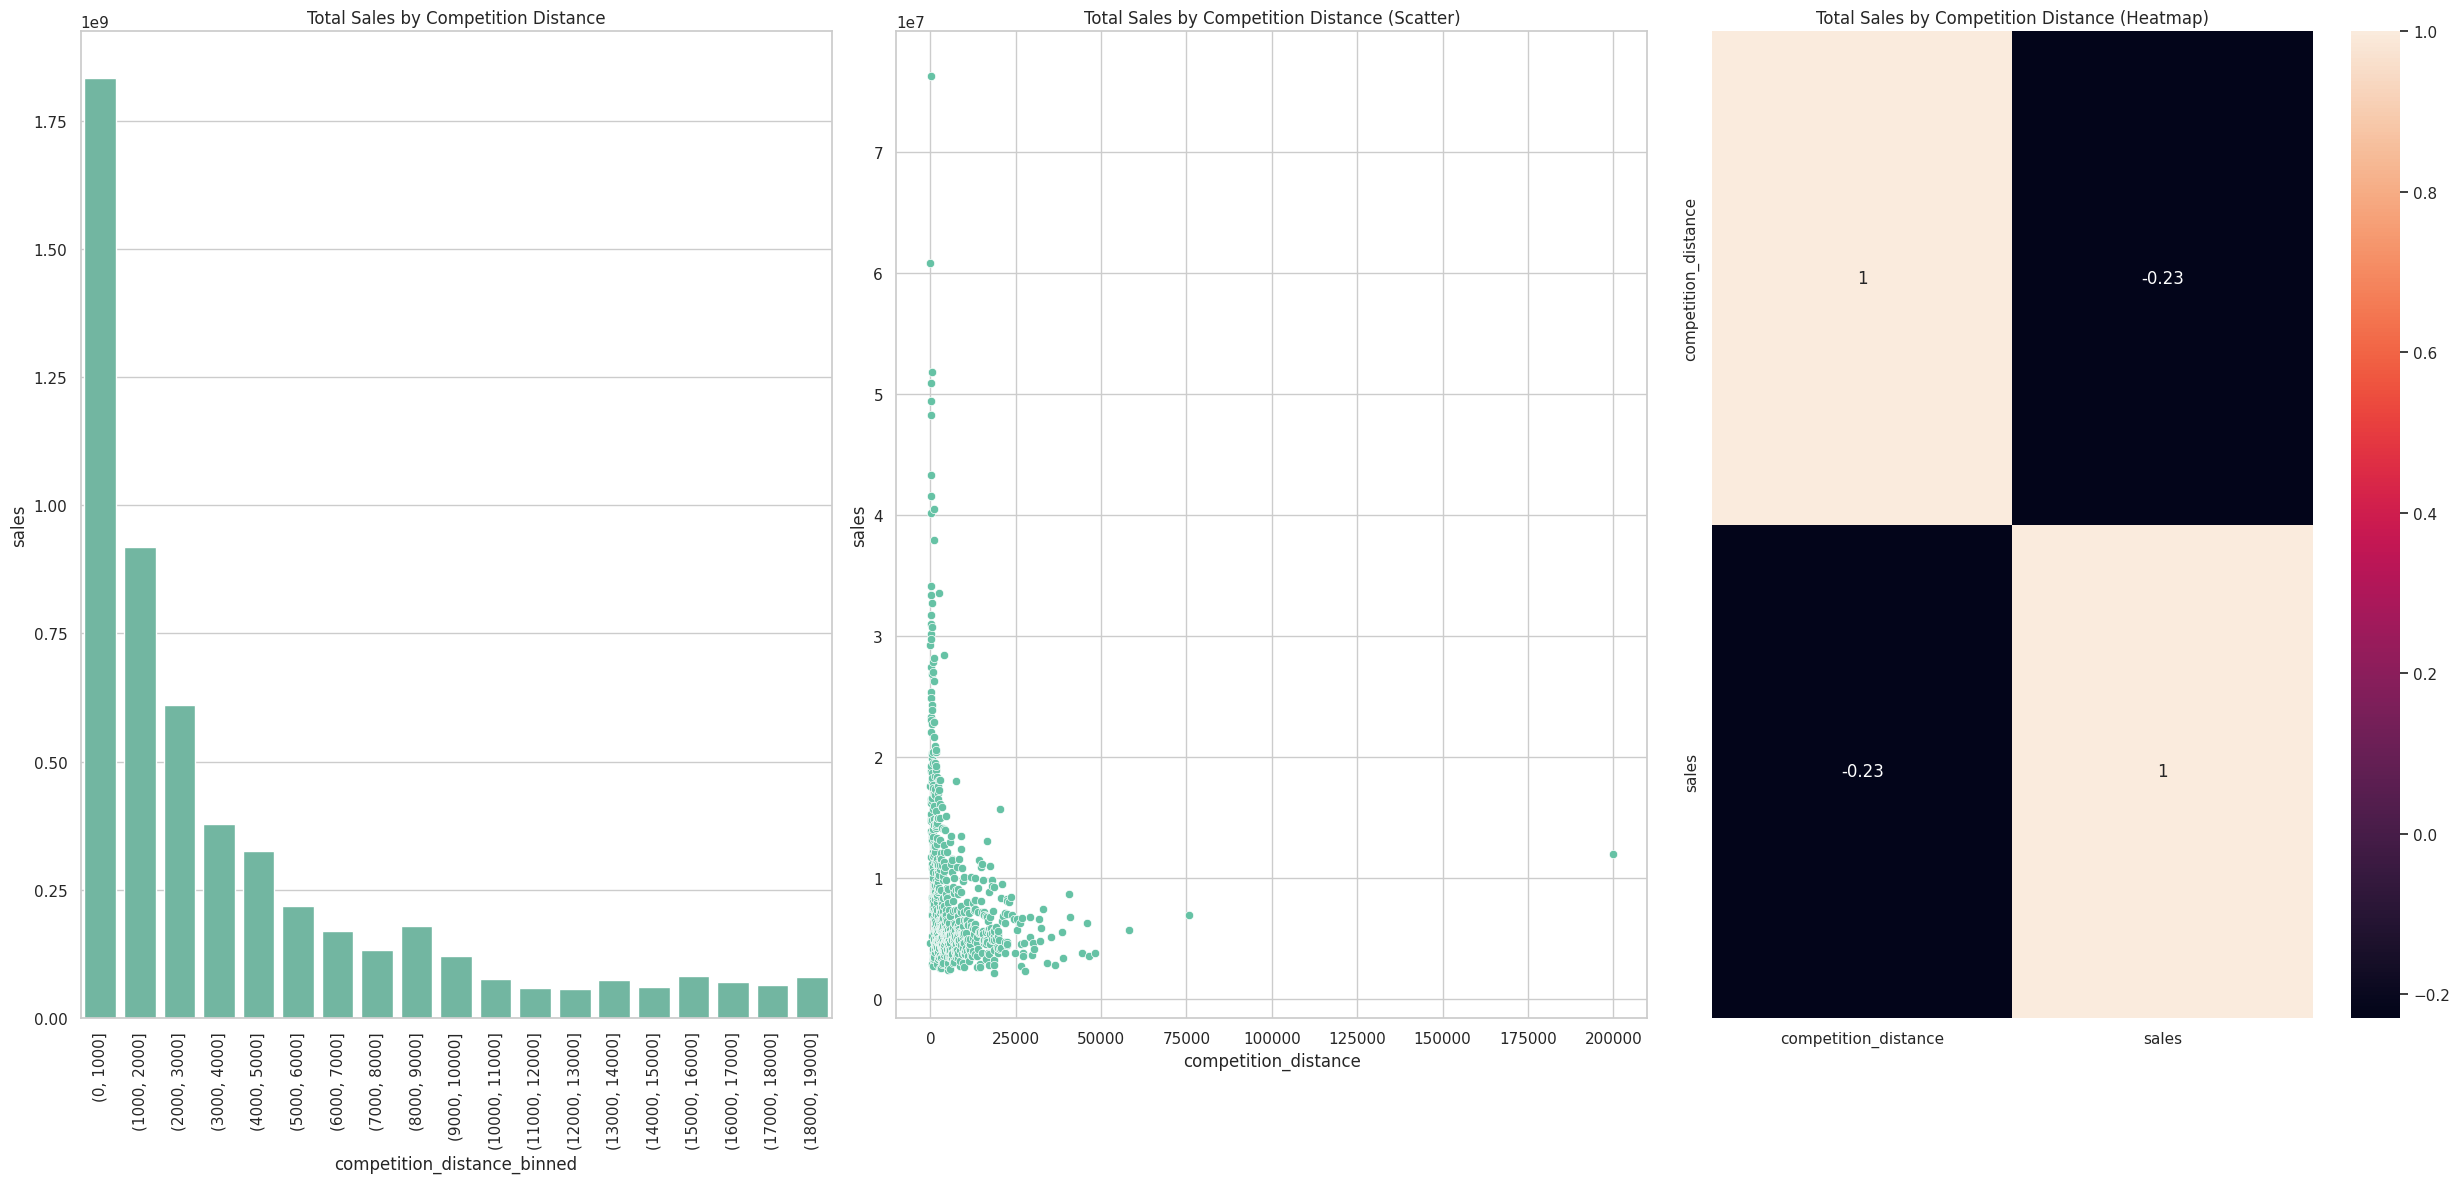

In [35]:
# -------------------------------
# Gráfico 1: Total Sales by Competition Distance (Binned)
# -------------------------------
plt.subplot(1, 3, 1)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins = np.arange(0, 20000, 1000)
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1.groupby('competition_distance_binned')['sales'].sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.title("Total Sales by Competition Distance")
plt.xticks(rotation=90)

# -------------------------------
# Gráfico 2: Total Sales by Competition Distance (Scatter)
# -------------------------------
plt.subplot(1, 3, 2)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1)
plt.title("Total Sales by Competition Distance (Scatter)")

# -------------------------------
# Gráfico 3: Correlation Heatmap
# -------------------------------
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True)
plt.title("Total Sales by Competition Distance (Heatmap)")

plt.tight_layout()
plt.show()

### **H3 -** Lojas com competidores a mais tempo deveriam vender mais.
**FALSA** Lojas com COMPETIDORES HA MAIS TEMPO vendem MENOS.

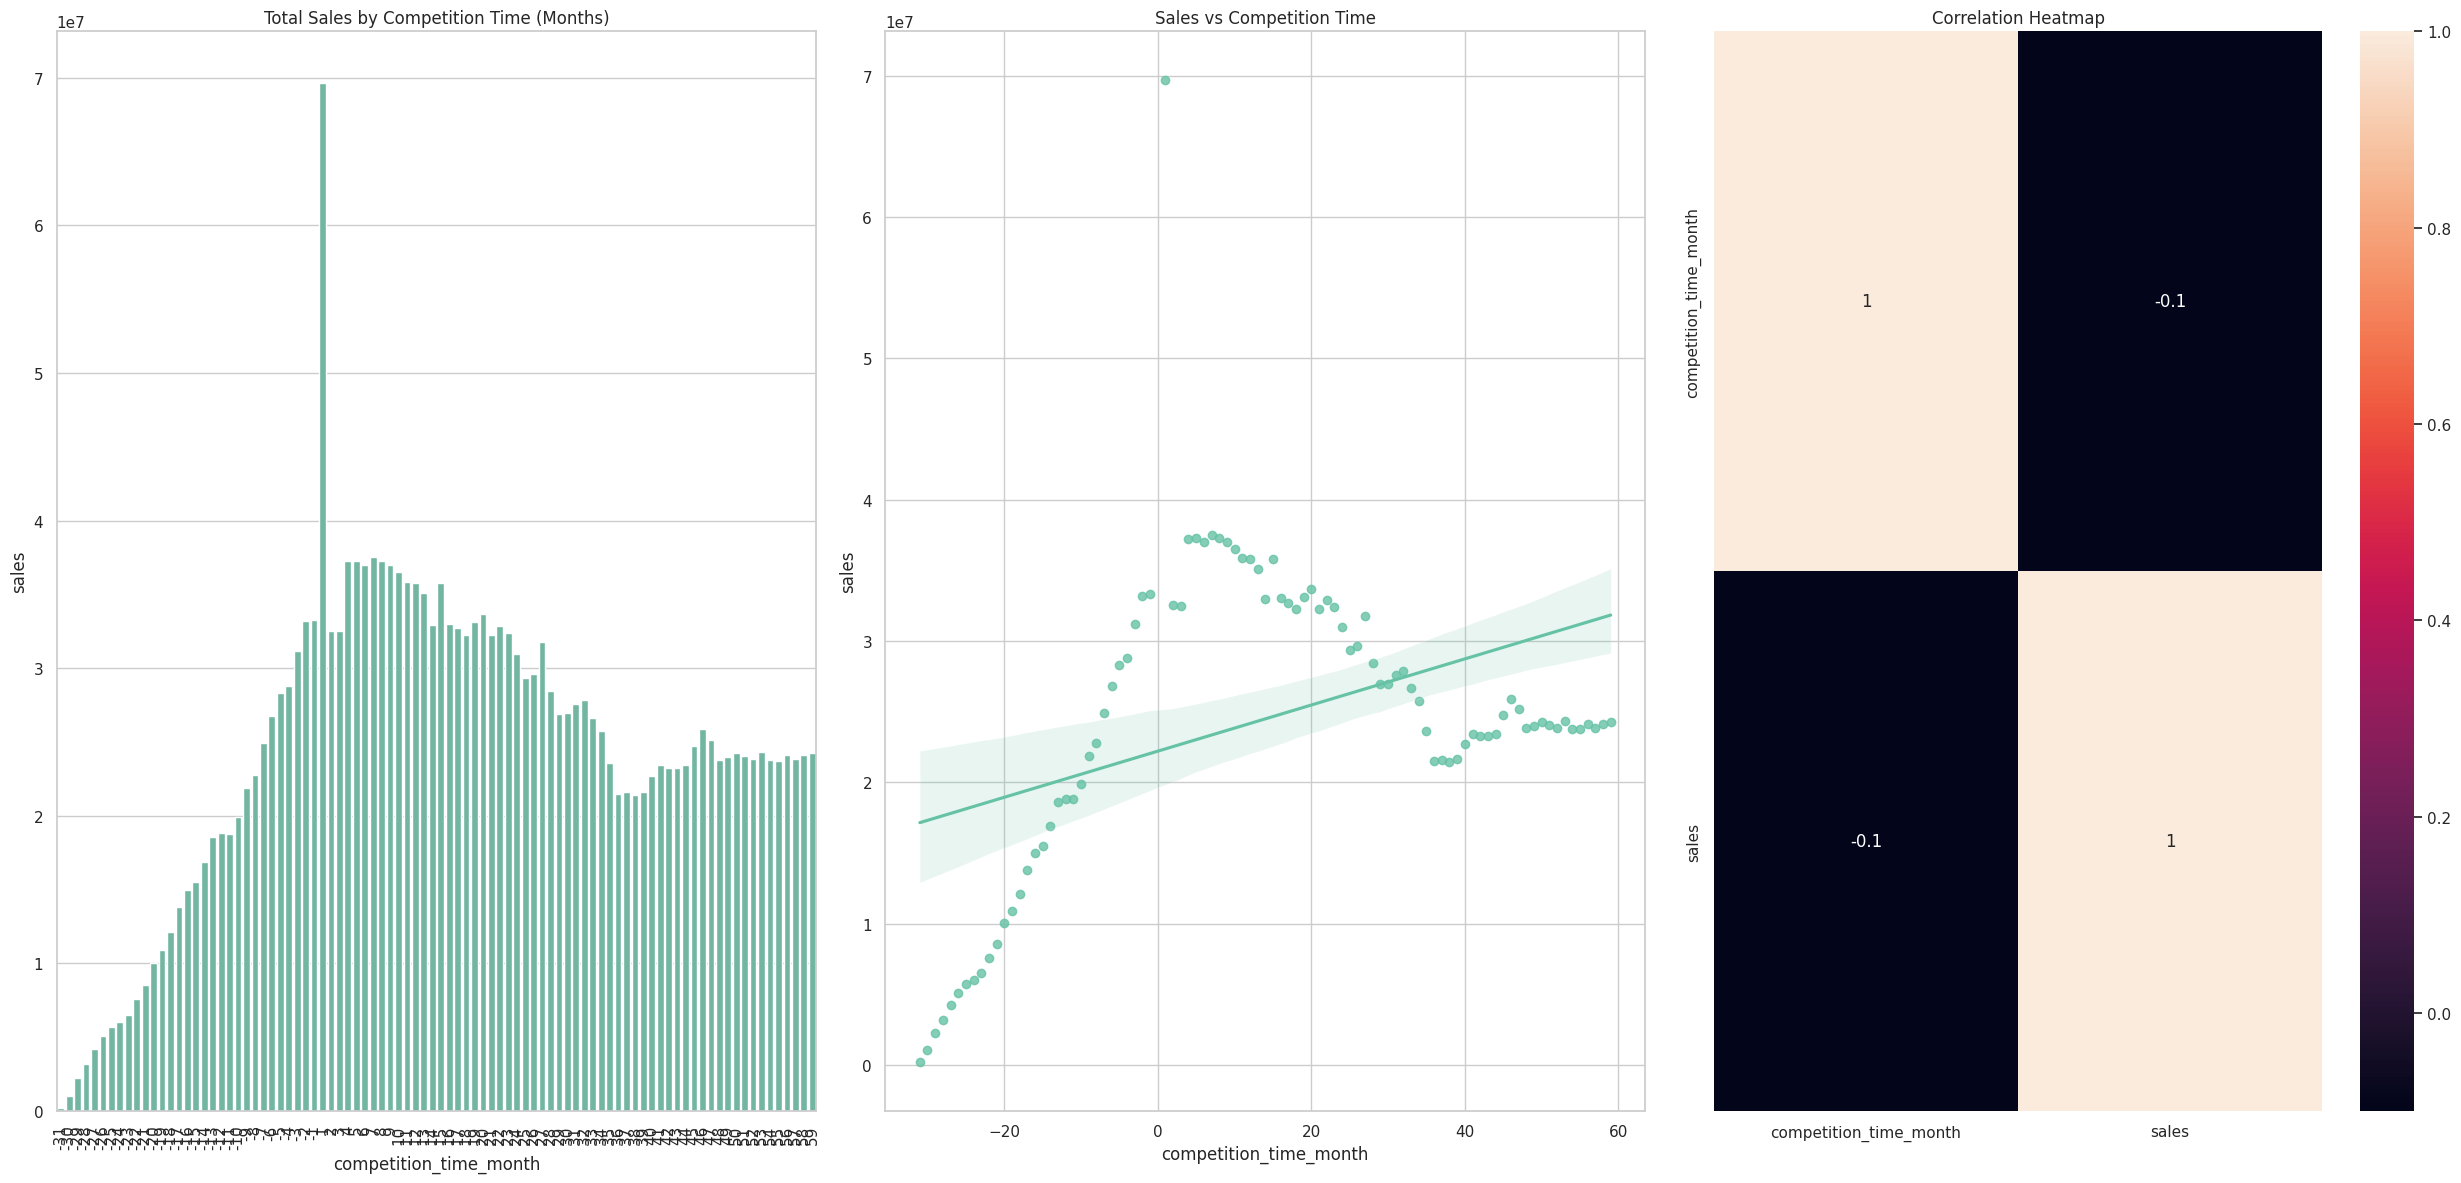

In [36]:
# -------------------------------
# Gráfico 1: Total Sales by Competition Time (Months)
# -------------------------------
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 60) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)
plt.title("Total Sales by Competition Time (Months)")

# -------------------------------
# Gráfico 2: Sales vs Competition Time (Regression)
# -------------------------------
plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)
plt.title("Sales vs Competition Time")

# -------------------------------
# Gráfico 3: Correlation Heatmap
# -------------------------------
plt.subplot(1, 3, 3)
corr_plot = sns.heatmap(aux1.corr(), annot=True)
bottom, top = corr_plot.get_ylim()
plt.title("Correlation Heatmap")

plt.tight_layout()
plt.show()

### **H4 -** Lojas com promocoes ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas POR MAIS TEMPO vendem MENOS, depois de um periodo de promocao.

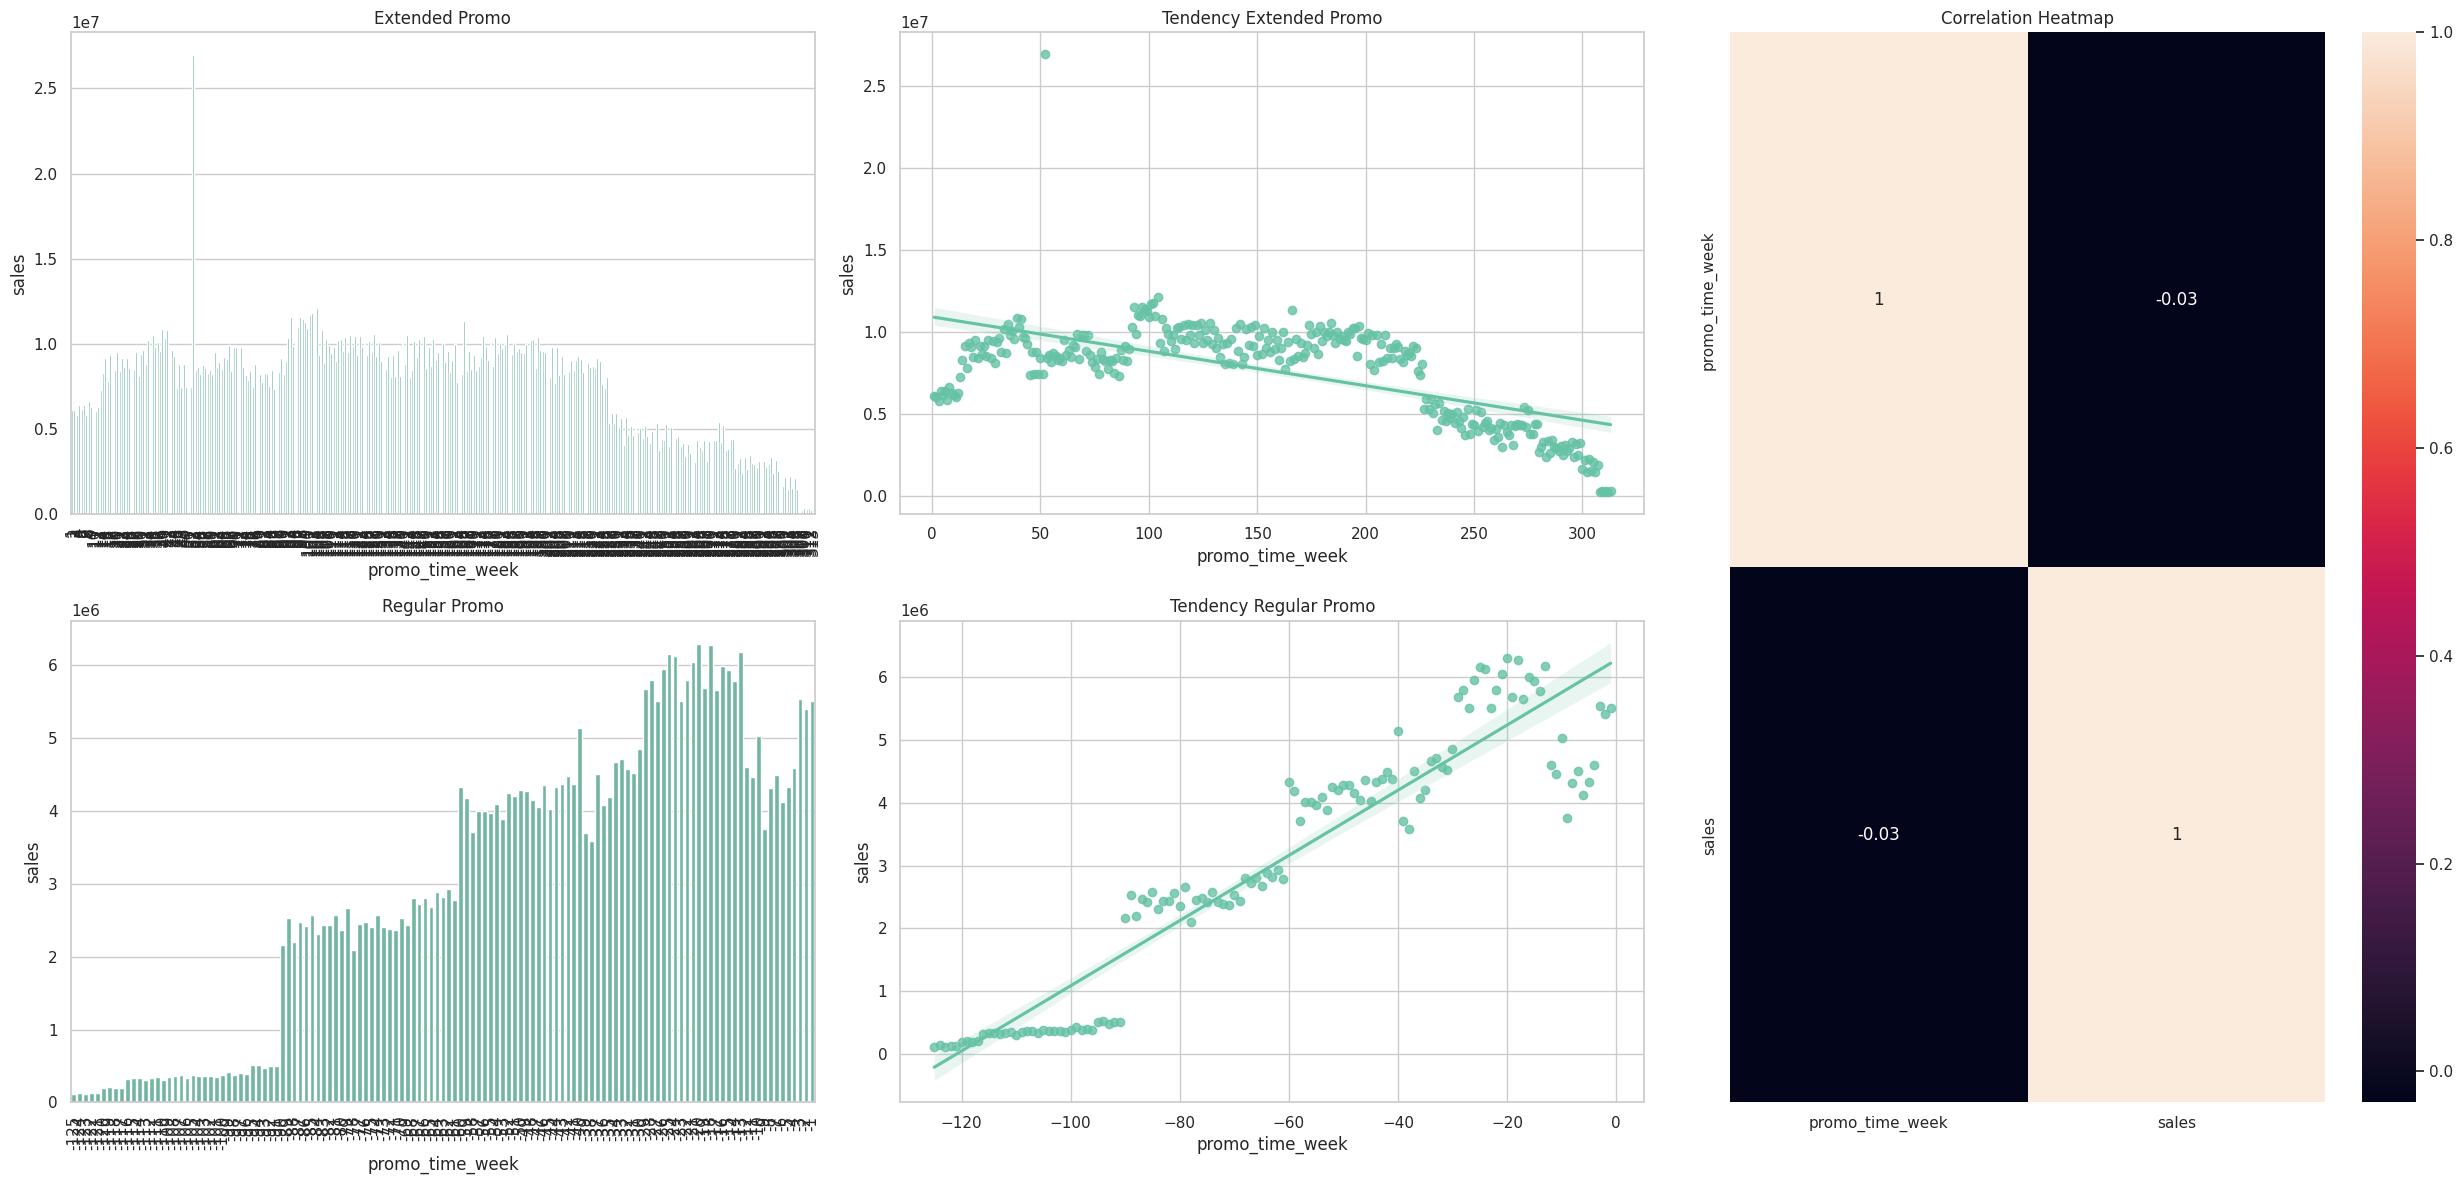

In [37]:
# Preparação dos dados
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
grid = GridSpec(2, 3)

# -------------------------------
# Graph 1 - Extended Promo (Bar)
# -------------------------------
plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0]  # extended
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.title('Extended Promo')
plt.xticks(rotation=90)

# -------------------------------
# Graph 2 - Extended Promo (Regression)
# -------------------------------
plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)
plt.title('Tendency Extended Promo')

# -------------------------------
# Graph 3 - Regular Promo (Bar)
# -------------------------------
plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]  # regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.title('Regular Promo')
plt.xticks(rotation=90)

# -------------------------------
# Graph 4 - Regular Promo (Regression)
# -------------------------------
plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)
plt.title('Tendency Regular Promo')

# -------------------------------
# Graph 5 - Correlation Heatmap
# -------------------------------
plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(), annot=True)
plt.title('Correlation Heatmap')

plt.tight_layout()
plt.show()


### <s>**H5 -** Lojas com mais dias de promocao deveriam vender mais.</s>

### **H6 -** Lojas com mais promocoes consecutivas deveriam vender mais.
**FALSA** Lojas com promocoes CONSECUTIVAS vendem MENOS

In [38]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by=['sales'], ascending=True)

promo  promo2       sales
1      0       1  1289362241
3      1       1  1472275754
0      0       0  1482612096
2      1       0  1628930532

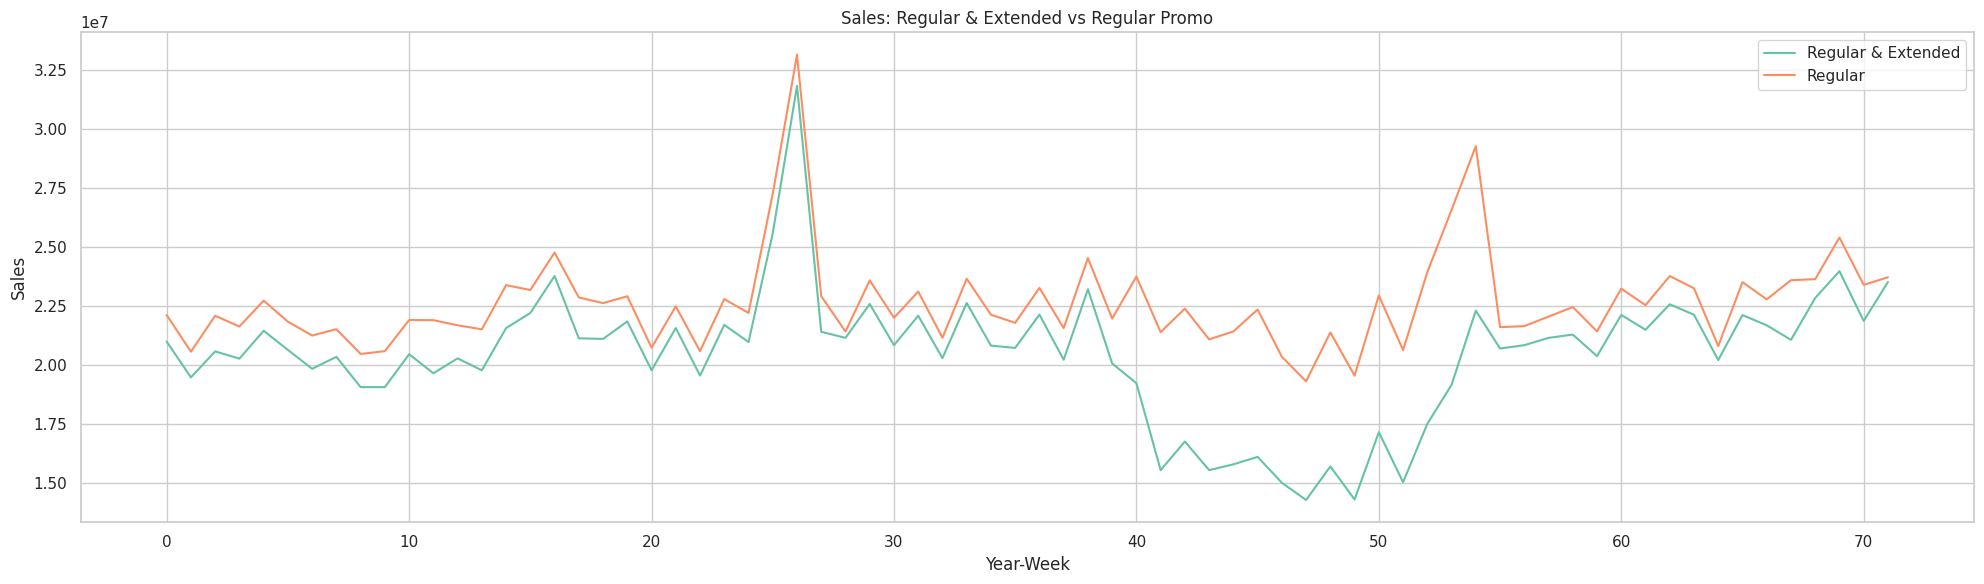

In [39]:
# -------------------------------
# Gráfico: Regular & Extended vs Regular Promo
# -------------------------------
# Preparação dos dados
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()

# Plot
ax = aux1.plot(color=sns.color_palette("Set2")[0], figsize=(20,6), title="Sales: Regular & Extended vs Regular Promo")
aux2.plot(ax=ax, color=sns.color_palette("Set2")[1])

# Legenda
ax.legend(labels=['Regular & Extended', 'Regular'])
ax.set_xlabel("Year-Week")
ax.set_ylabel("Sales")
plt.tight_layout()
plt.show()

### **H7 -** Lojas abertas durante o feriado de natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado de natal vendem MENOS

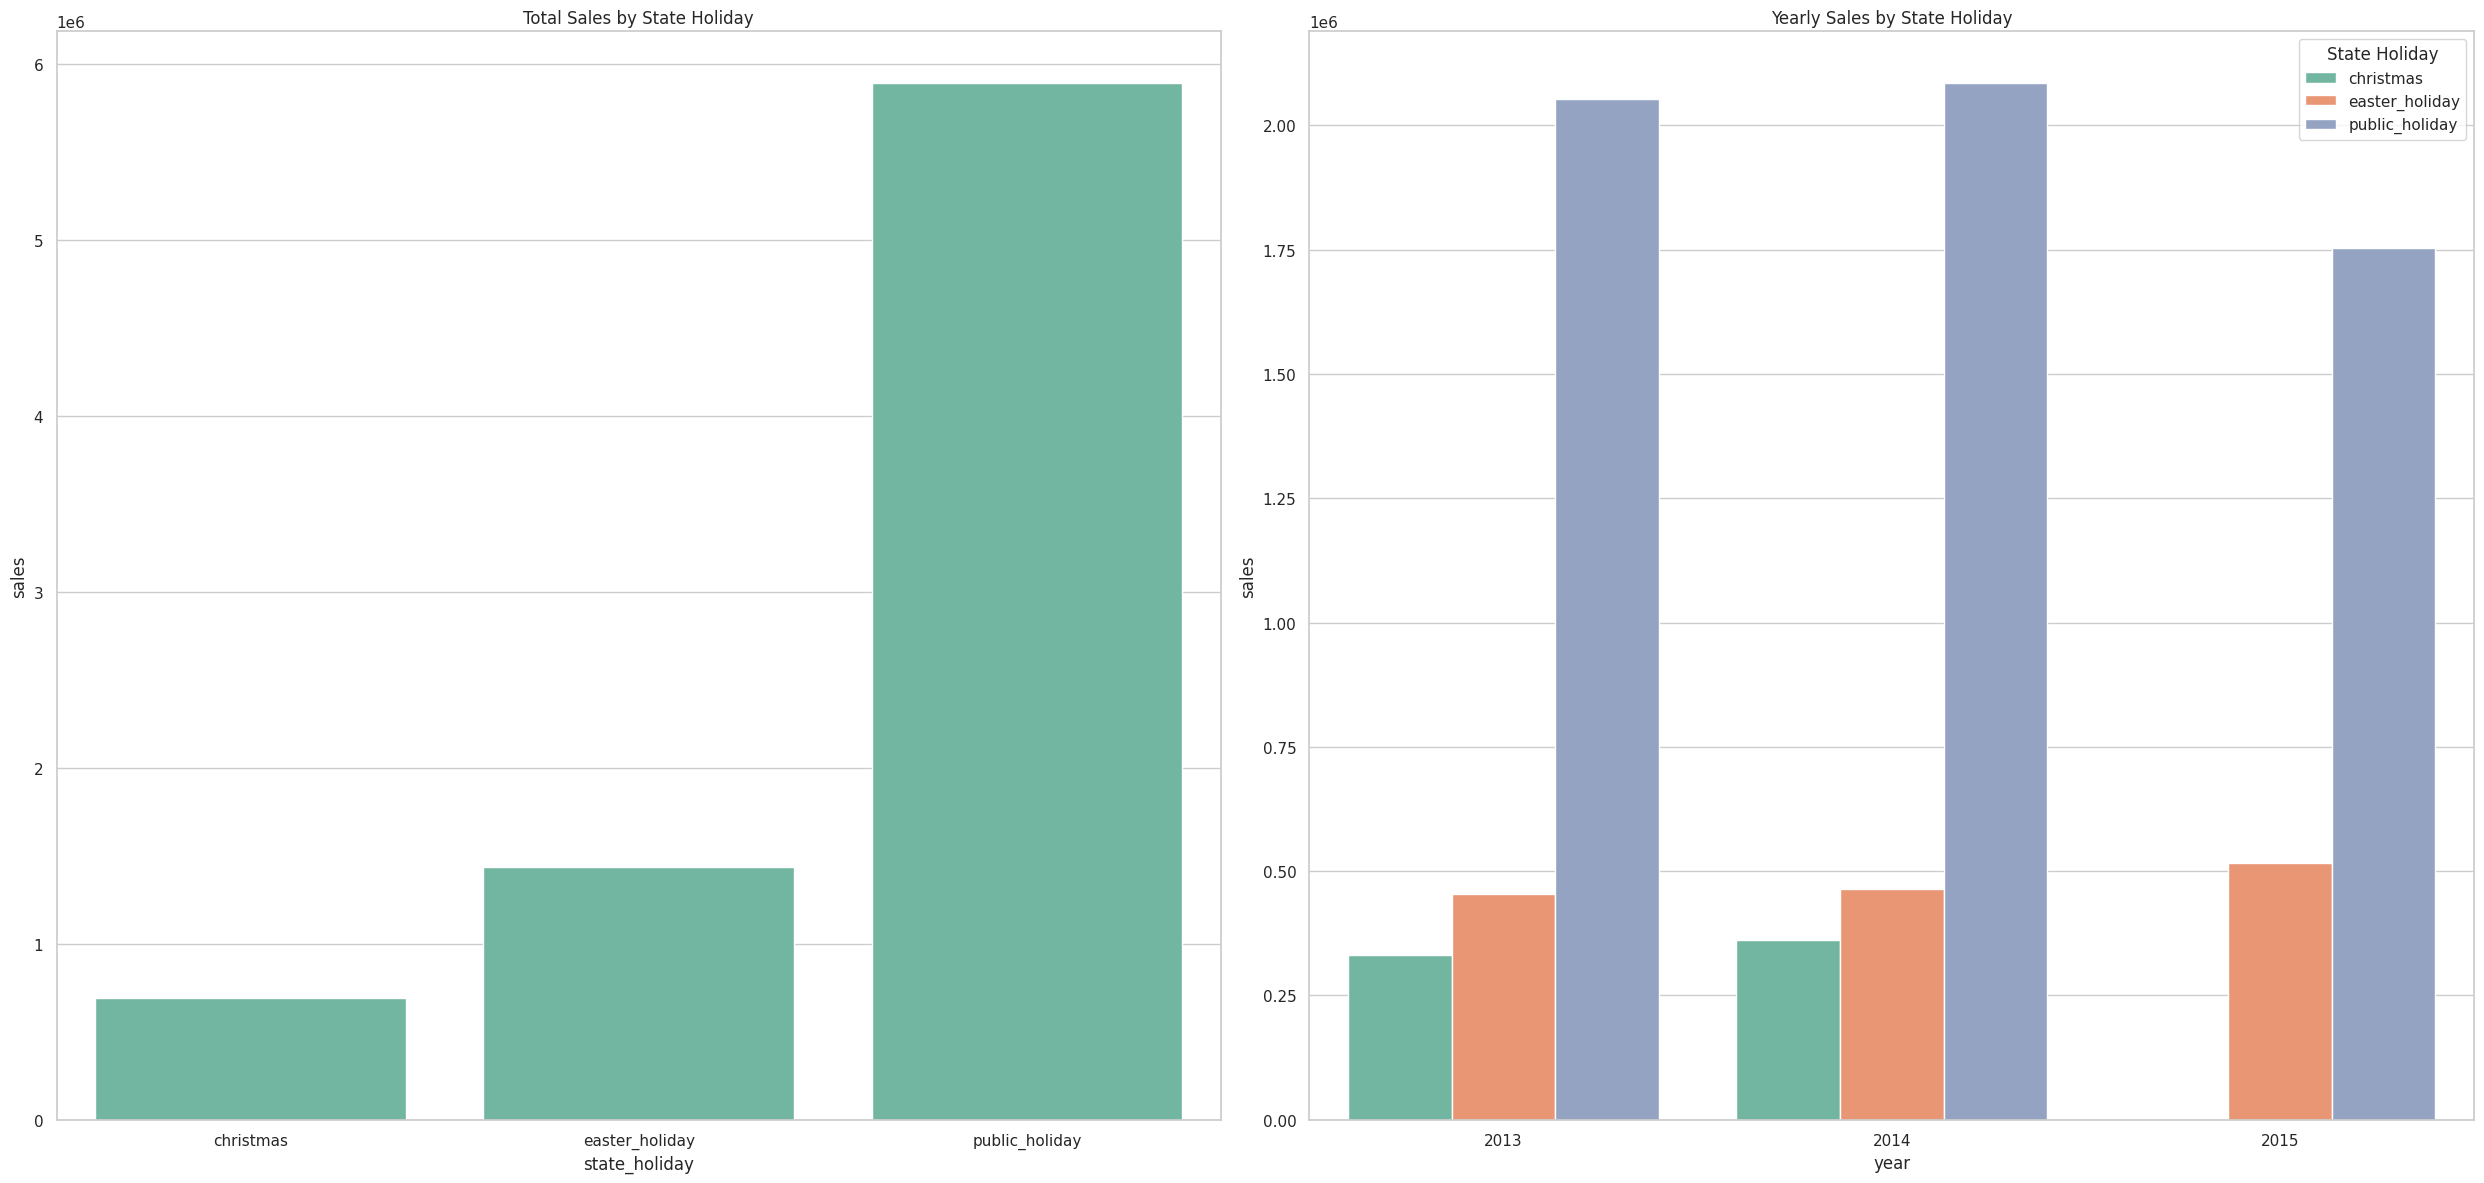

In [40]:
# Filtrando apenas feriados
aux = df4[df4['state_holiday'] != 'regular_day']

# -------------------------------
# Gráfico 1: Total Sales by State Holiday
# -------------------------------
plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)
plt.title("Total Sales by State Holiday")

# -------------------------------
# Gráfico 2: Yearly Sales by State Holiday
# -------------------------------
plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)
plt.title("Yearly Sales by State Holiday")
plt.legend(title="State Holiday")

plt.tight_layout()
plt.show()

### **H8 -** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem MENOS ao longo dos anos

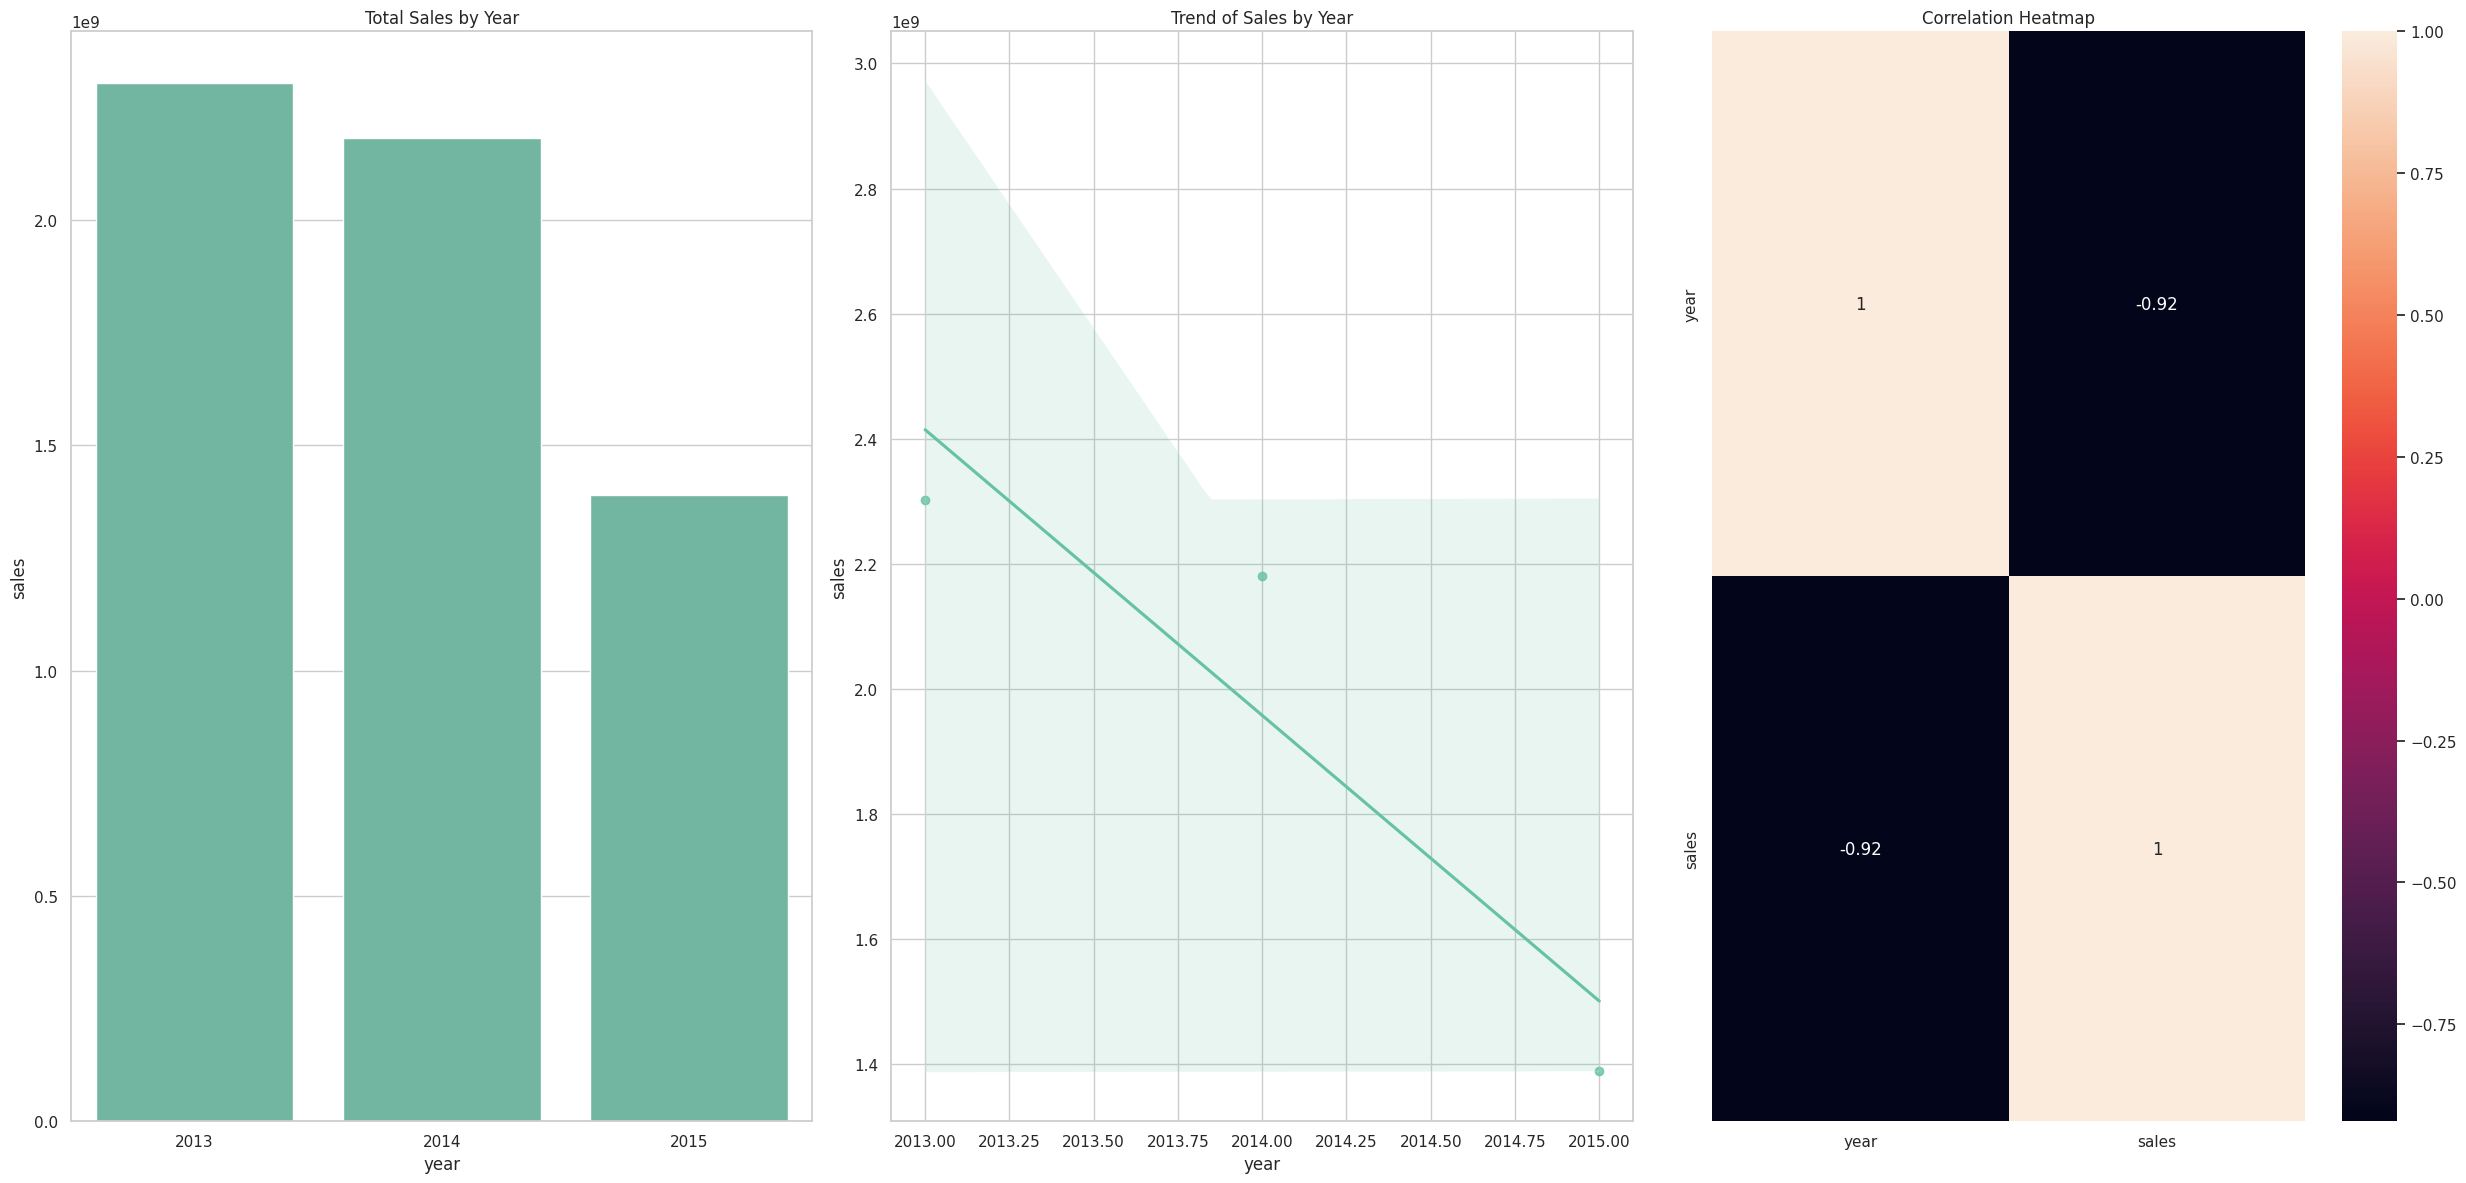

In [41]:
# -------------------------------
# Total Sales by Year
# -------------------------------
aux = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux)
plt.title("Total Sales by Year")

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux)
plt.title("Trend of Sales by Year")

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

### **H9 -** Lojas deveriam vender mais no segundo semestre do ano
**FALSA** Lojas vendem MENOS no segundo semestre do ano

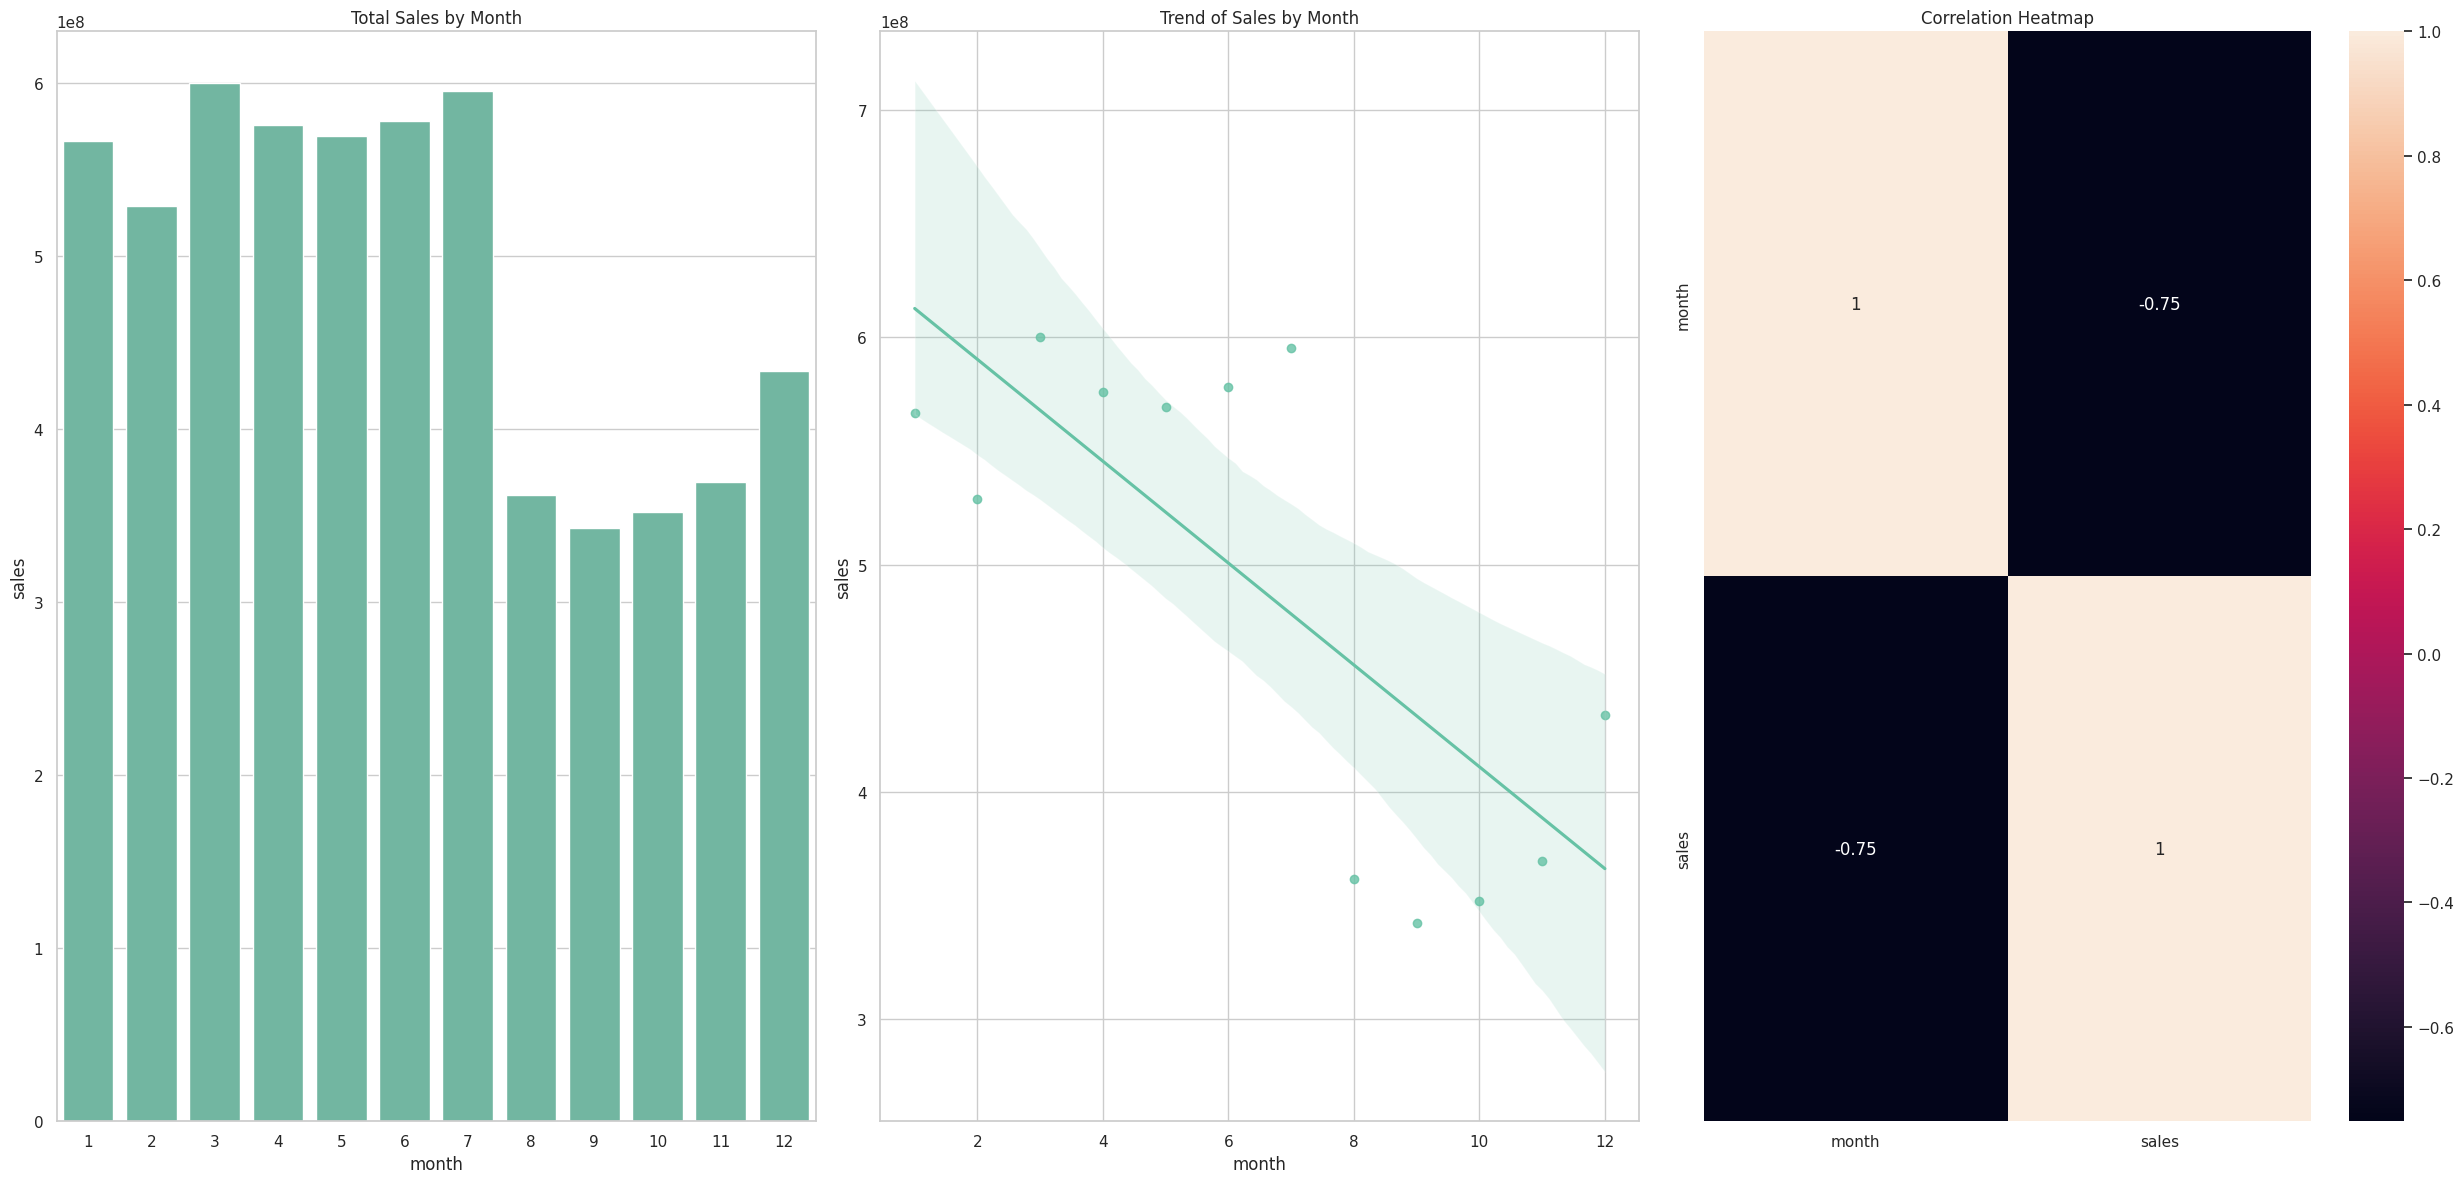

In [42]:
# -------------------------------
# Total Sales by Month
# -------------------------------
aux = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux)
plt.title("Total Sales by Month")

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux)
plt.title("Trend of Sales by Month")

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

### **H10 -** Lojas deveriam vender mais depois do dia 10 de cada mes
**VERDADEIRA** Lojas vendem MAIS depois do dia 10

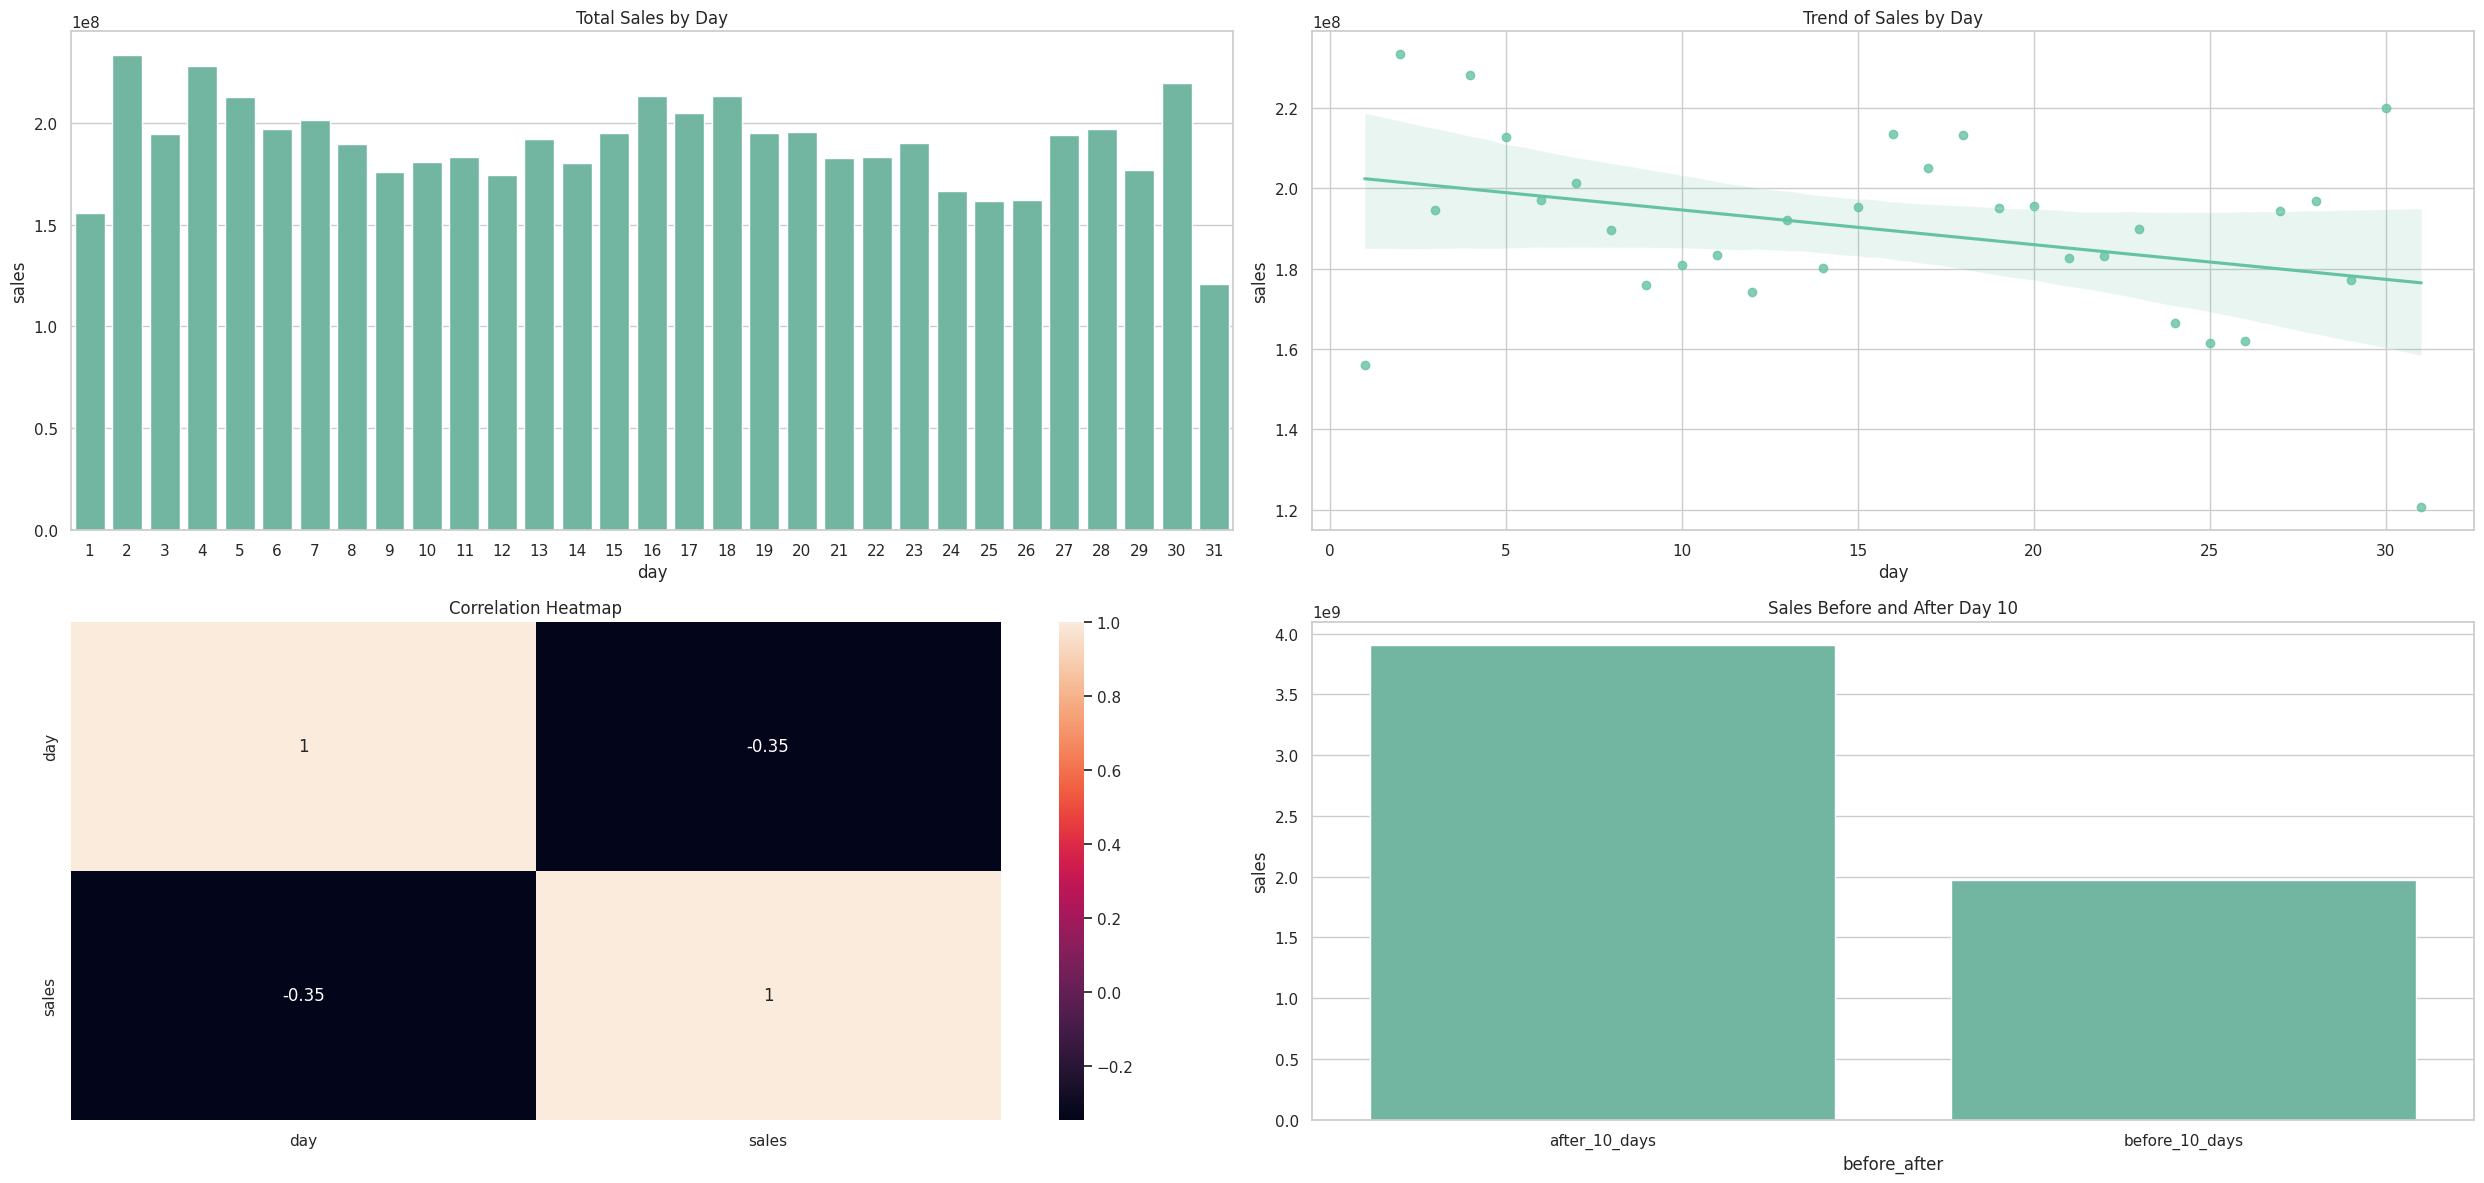

In [43]:
# -------------------------------
# Total Sales by Day of Month
# -------------------------------
aux = df4[['day', 'sales']].groupby(['day']).sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux)
plt.title("Total Sales by Day")

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux)
plt.title("Trend of Sales by Day")

plt.subplot(2,2,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)
plt.title("Correlation Heatmap")

# Agrupando dias antes e depois do dia 10
aux['before_after'] = aux['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux1 = aux[['before_after', 'sales']].groupby(['before_after']).sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux1)
plt.title("Sales Before and After Day 10")

plt.tight_layout()
plt.show()

### **H11 -** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem MENOS aos finais de semana

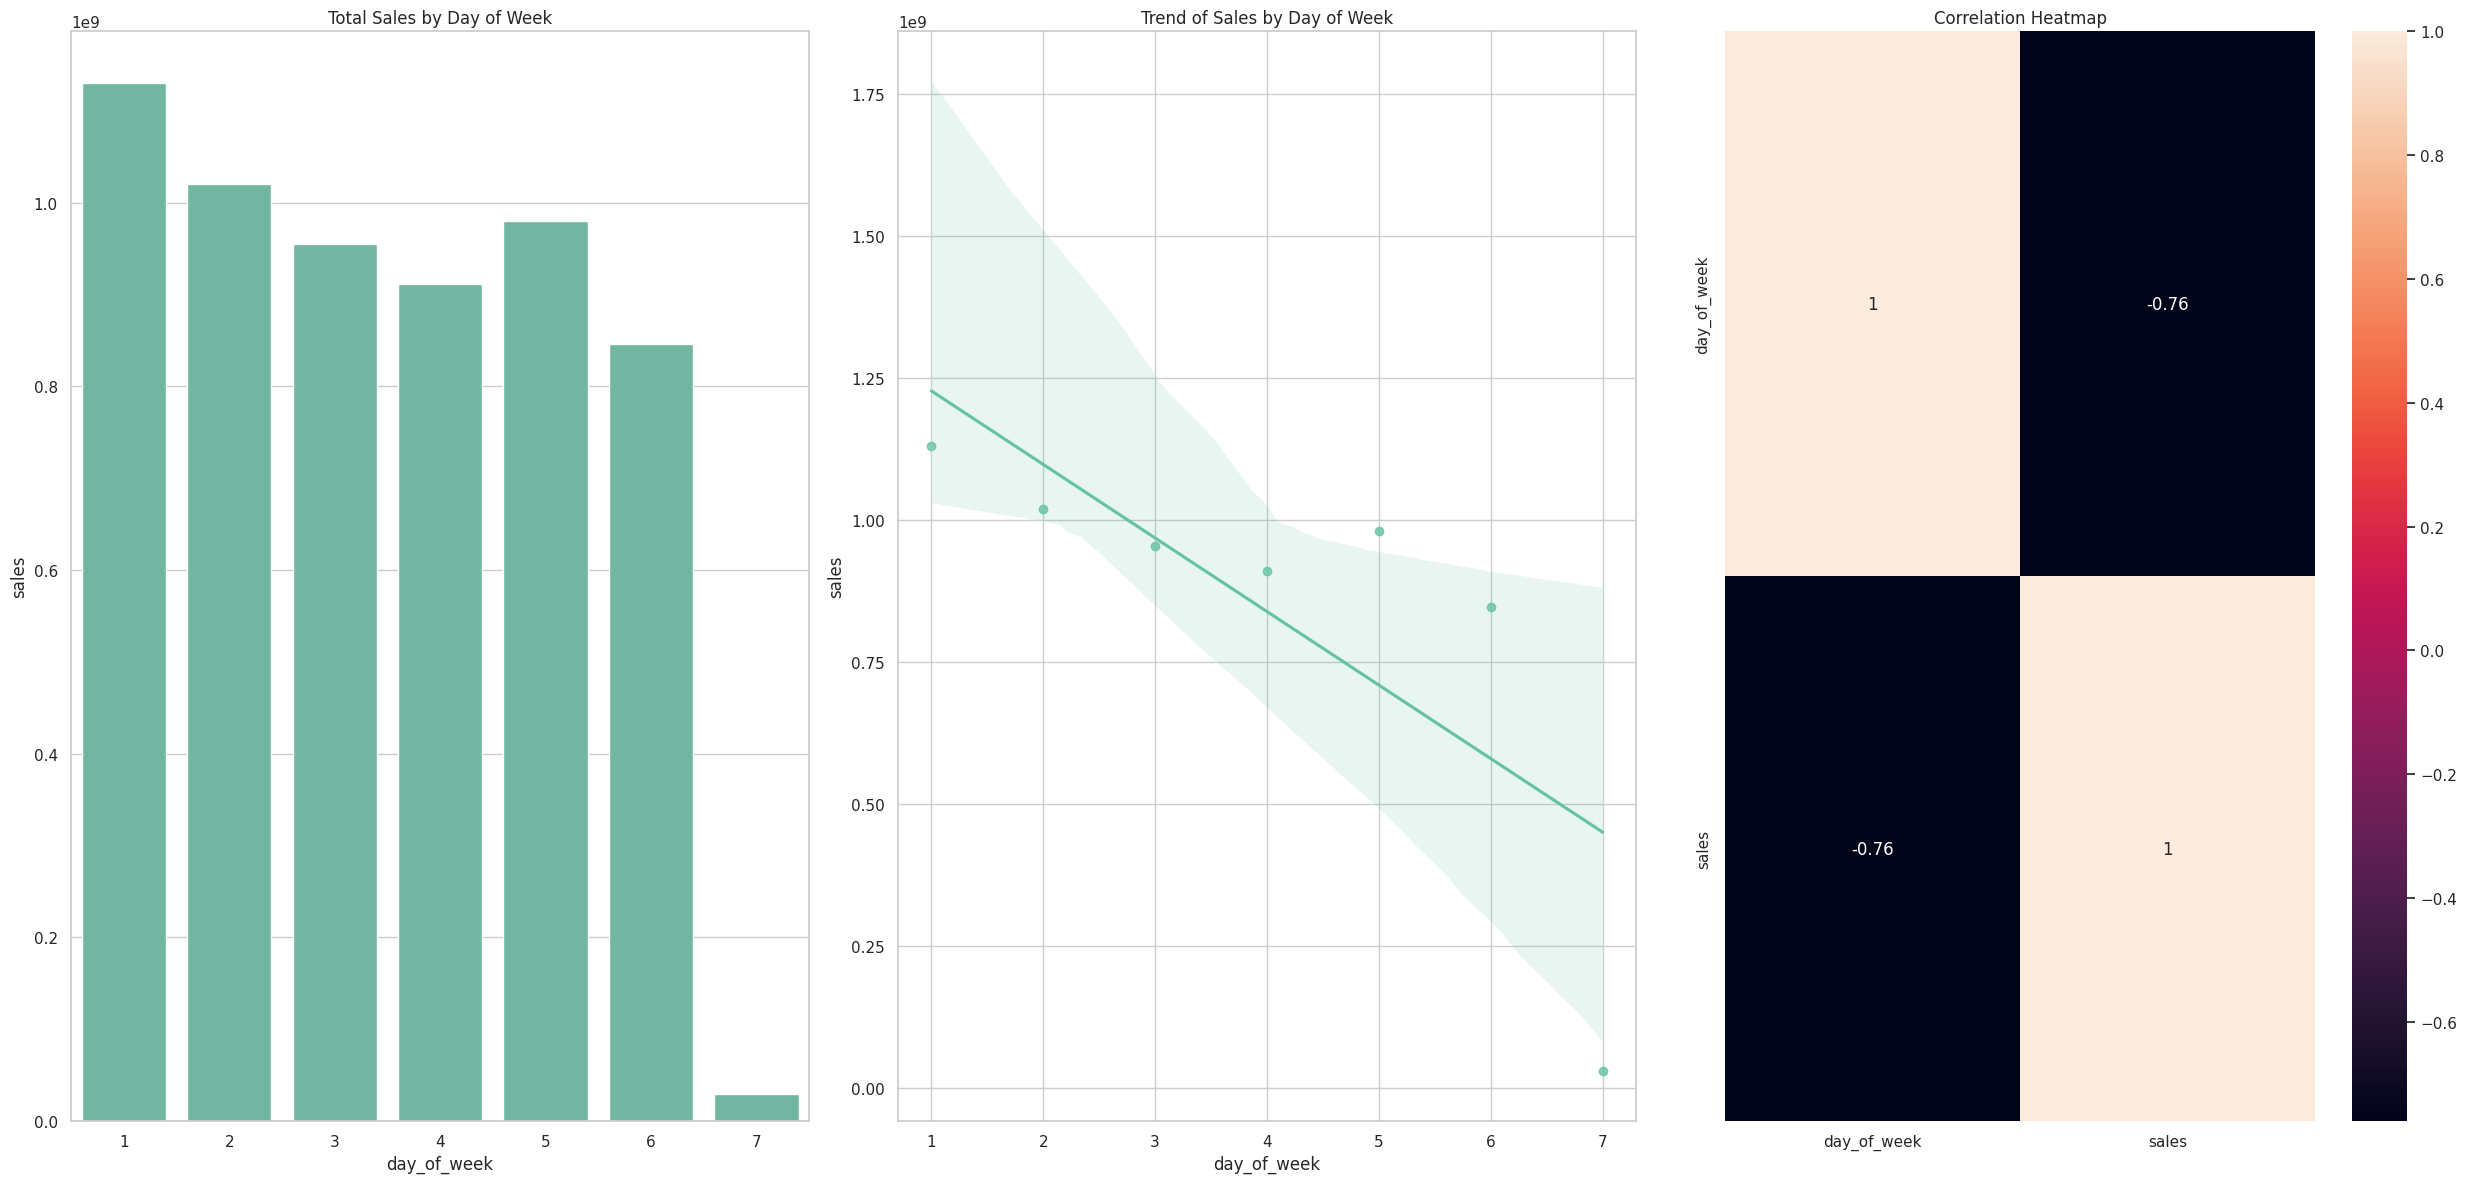

In [44]:
# -------------------------------
# Total Sales by Day of Week
# -------------------------------
aux = df4[['day_of_week', 'sales']].groupby(['day_of_week']).sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux)
plt.title("Total Sales by Day of Week")

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux)
plt.title("Trend of Sales by Day of Week")

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)
plt.title("Correlation Heatmap")

plt.tight_layout()
plt.show()

### **H12 -** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem MENOS durante os feriados escolares, exceto Julho e Agosto.

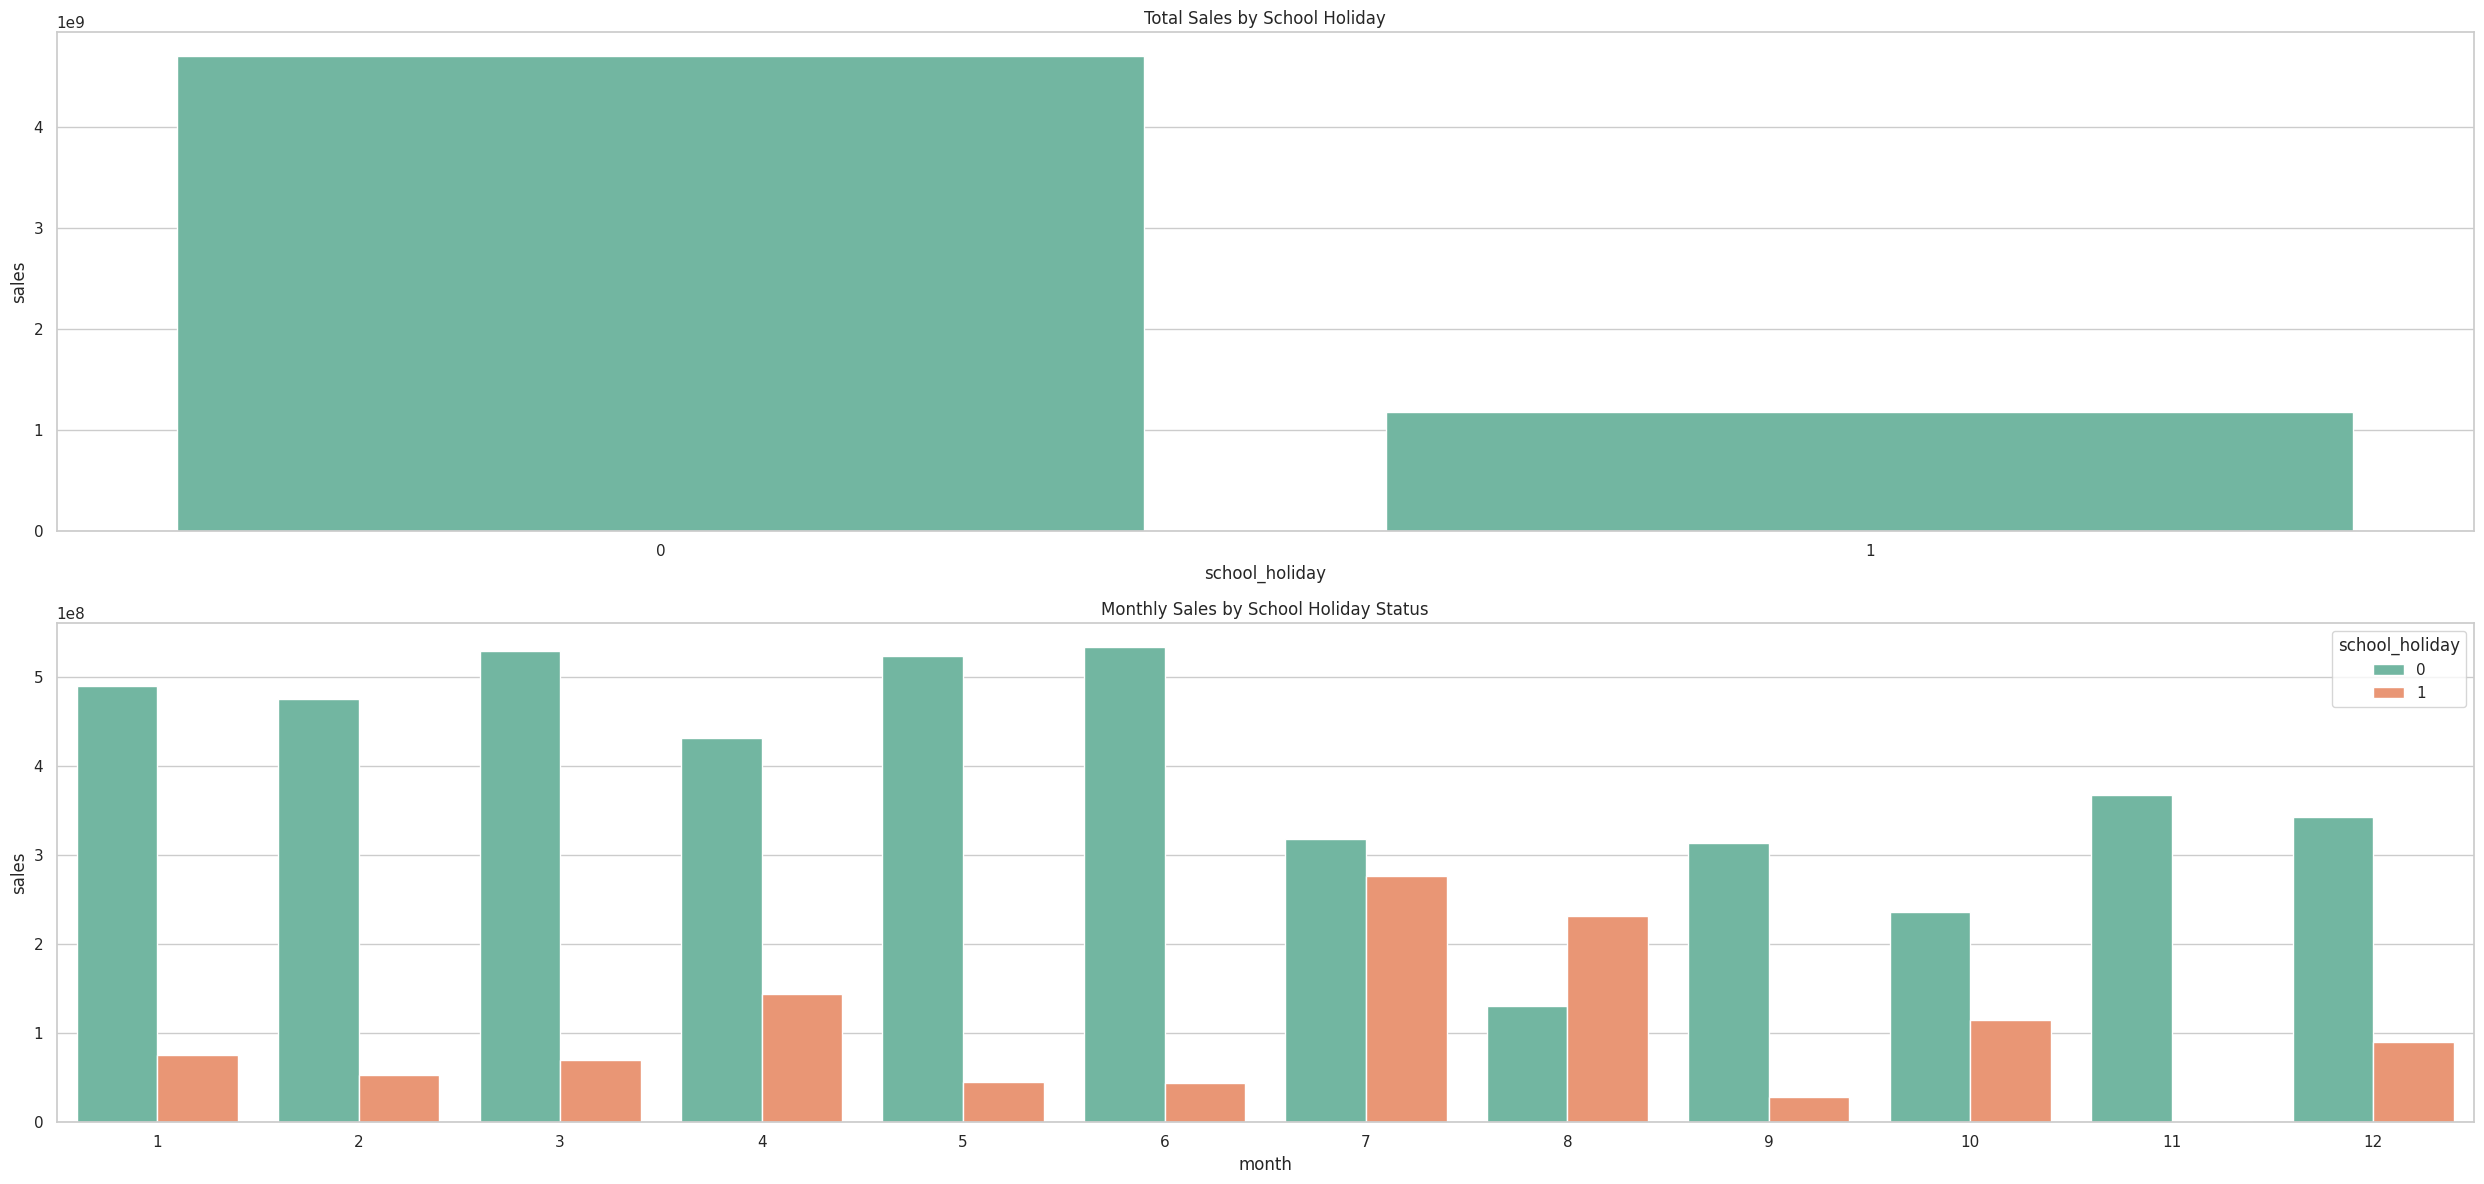

In [45]:
# -------------------------------
# Sales by School Holiday
# -------------------------------
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1)
plt.title("Total Sales by School Holiday")

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)
plt.title("Monthly Sales by School Holiday Status")

plt.tight_layout()
plt.show()

### Resume Analysis

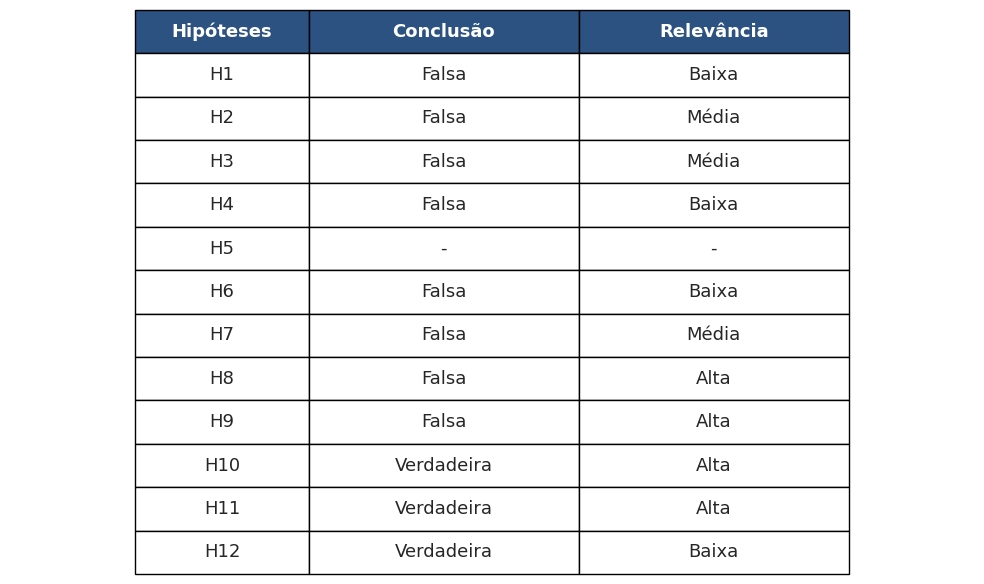

In [46]:
resumo_bivariada = pd.DataFrame({
    'Hipóteses': ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12'],
    'Conclusão': ['Falsa', 'Falsa', 'Falsa', 'Falsa', '-', 'Falsa', 'Falsa', 'Falsa', 'Falsa', 'Verdadeira', 'Verdadeira', 'Verdadeira'],
    'Relevância': ['Baixa', 'Média', 'Média', 'Baixa', '-', 'Baixa', 'Média', 'Alta', 'Alta', 'Alta', 'Alta', 'Baixa']
})

plt.figure(figsize=(10, 6))
plt.axis('off')

table = plt.table(cellText=resumo_bivariada.values,
                  colLabels=resumo_bivariada.columns,
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.18, 0.28, 0.28])

table.auto_set_font_size(False)
table.set_fontsize(13)
table.scale(1, 2.6)

# Cabeçalho
for i in range(3):
    table[(0, i)].set_facecolor('#2c5282')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.tight_layout()
plt.show()

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

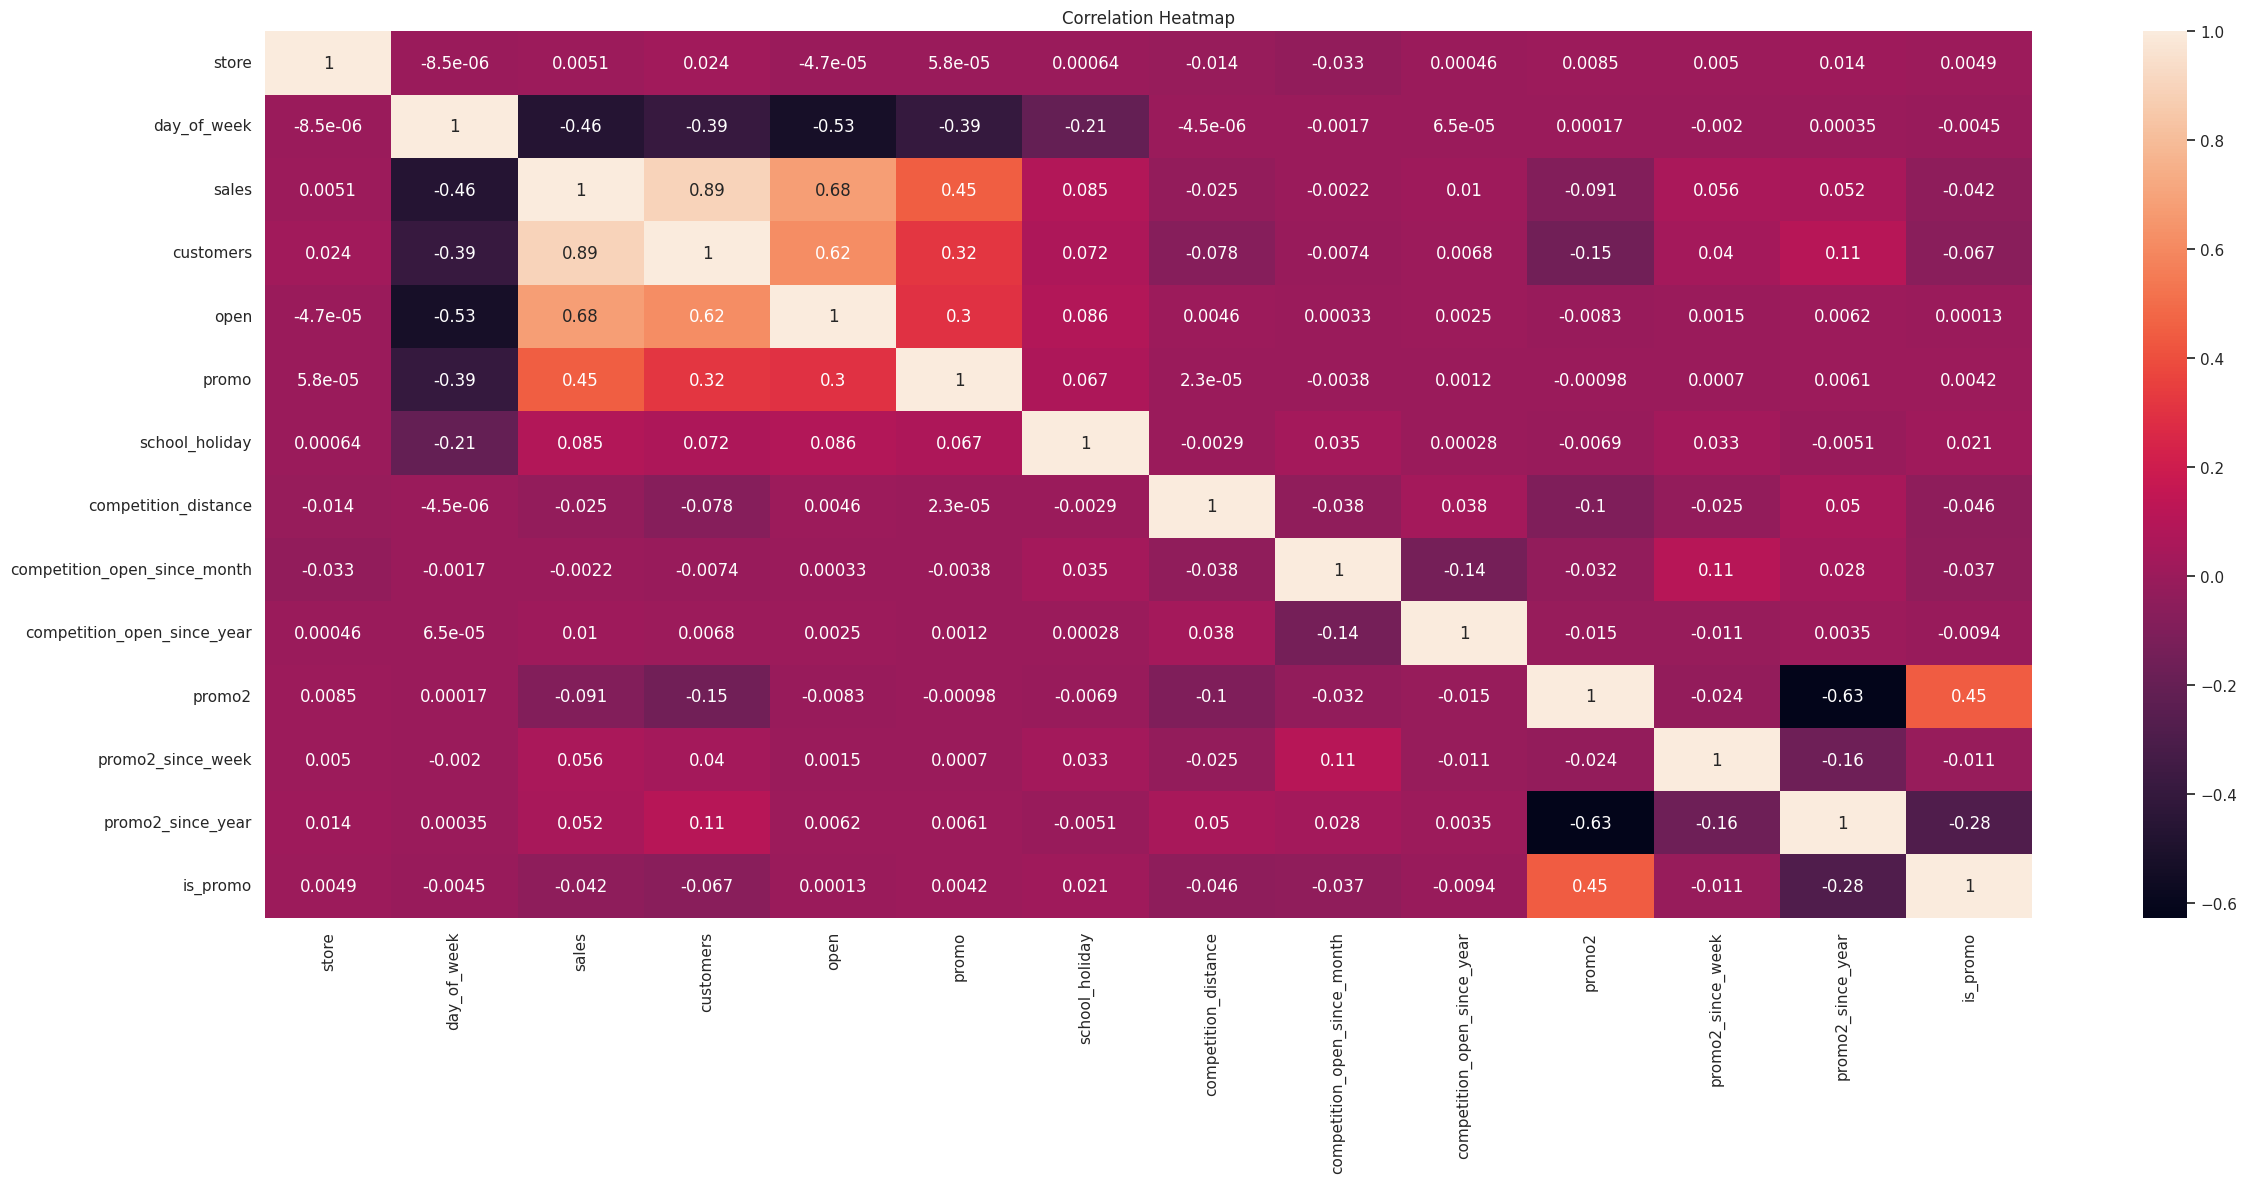

In [47]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

### 4.3.2 Categorical Attributes

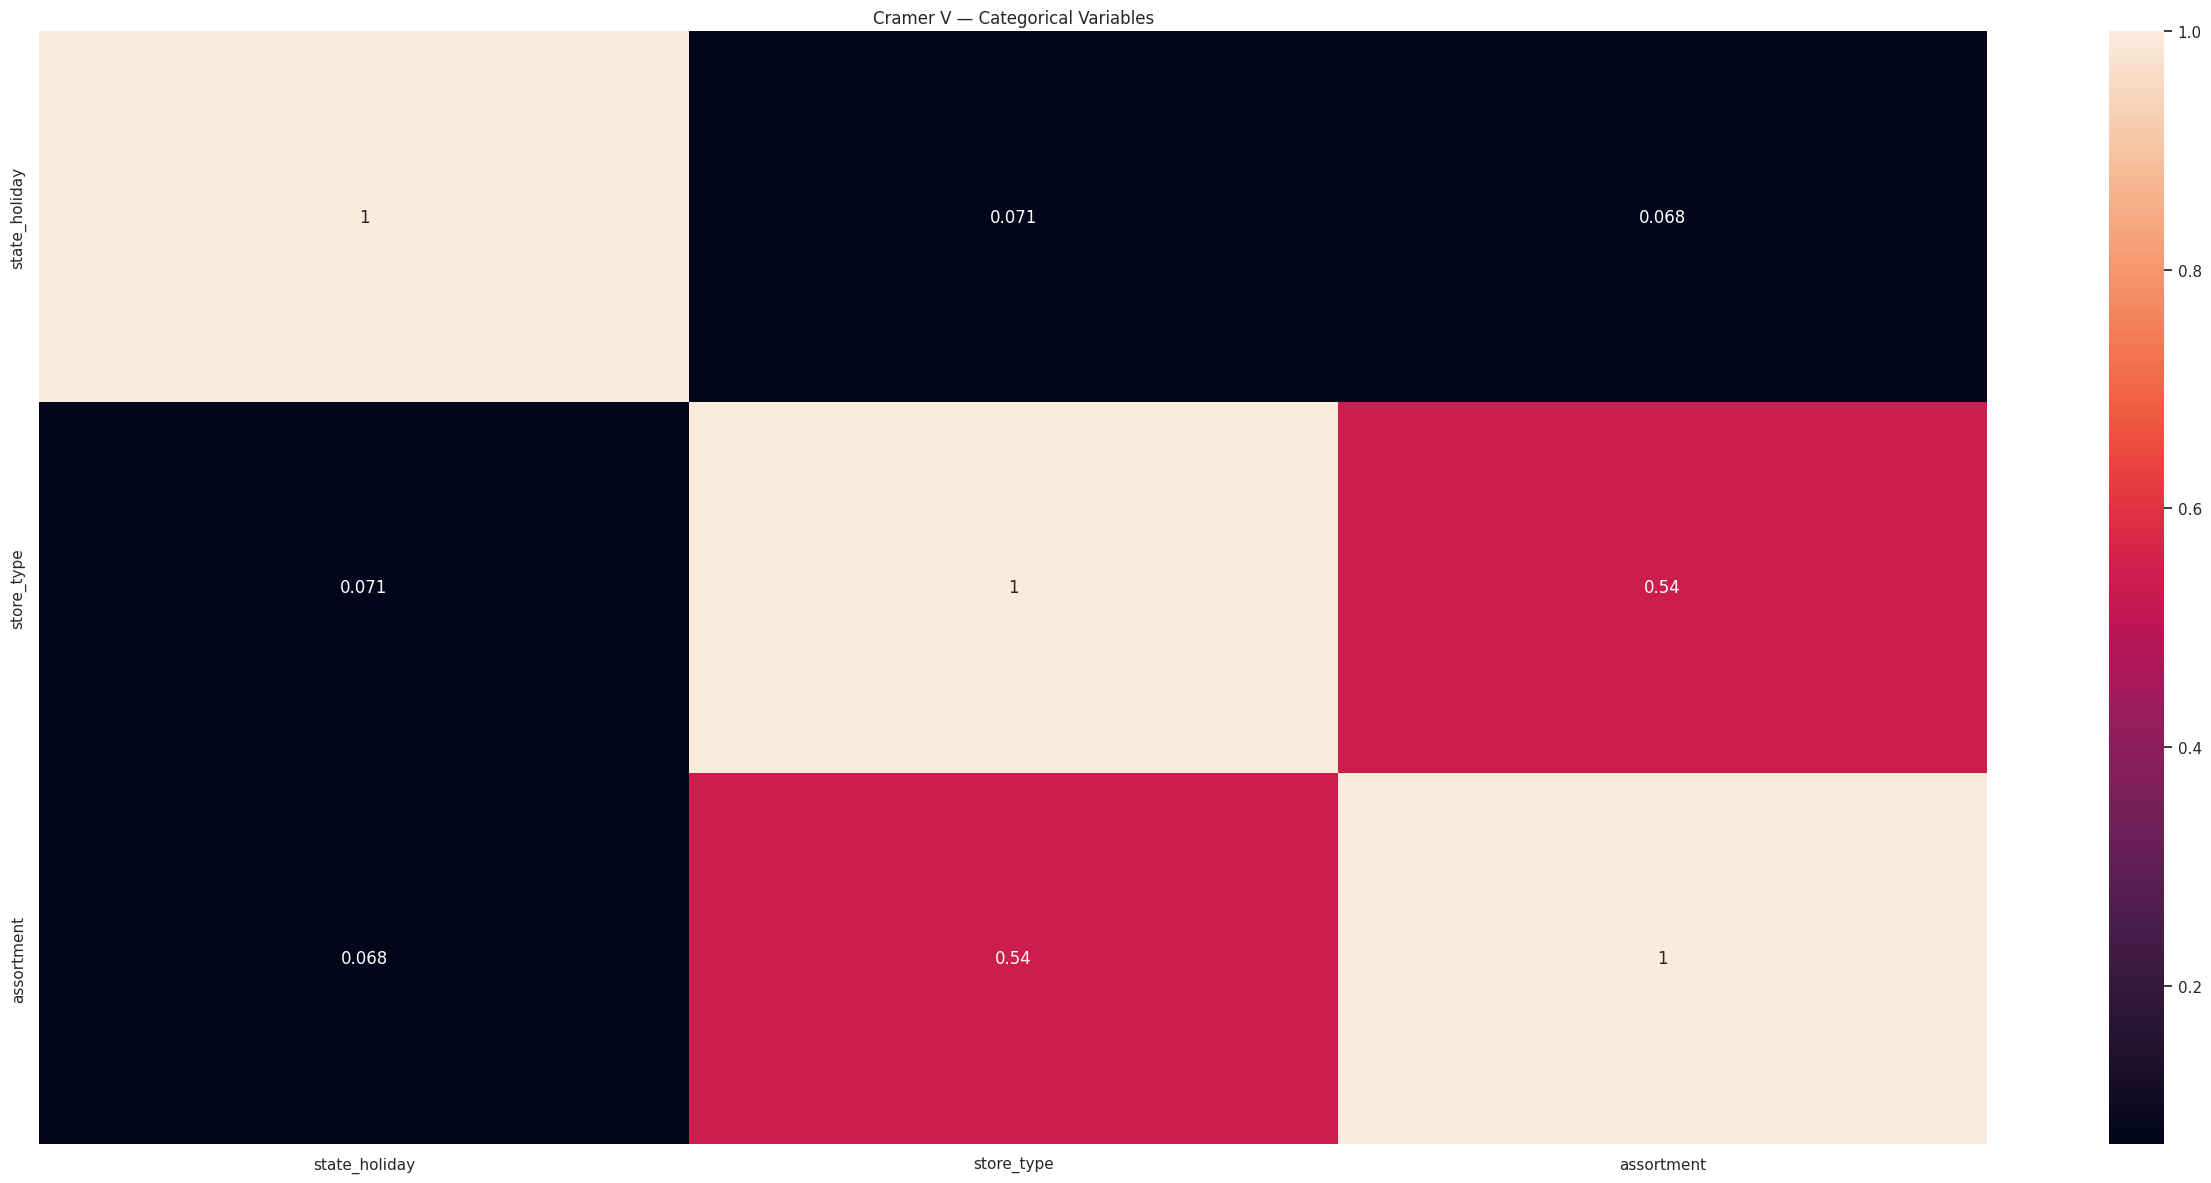

In [48]:
# Seleção de colunas categóricas
a = df4.select_dtypes(include='object')

# Cálculo do Cramer V
d = pd.DataFrame({
    'state_holiday': [
        cramer_v(a['state_holiday'], a['state_holiday']),
        cramer_v(a['store_type'], a['state_holiday']),
        cramer_v(a['assortment'], a['state_holiday'])
    ],
    'store_type': [
        cramer_v(a['state_holiday'], a['store_type']),
        cramer_v(a['store_type'], a['store_type']),
        cramer_v(a['assortment'], a['store_type'])
    ],
    'assortment': [
        cramer_v(a['state_holiday'], a['assortment']),
        cramer_v(a['store_type'], a['assortment']),
        cramer_v(a['assortment'], a['assortment'])
    ]
}, index=['state_holiday', 'store_type', 'assortment'])

# Heatmap
sns.heatmap(d, annot=True)
plt.title("Cramer V — Categorical Variables")
plt.tight_layout()
plt.show()

# 5.0 DATA PREPARATION

In [49]:
df5 = df4.copy()

## 5.1 Normalization

## 5.2 Rescaling

In [50]:
# -------------------------------
# Criando scalers separados para cada coluna
# -------------------------------

# Competition Distance
rs_comp_dist = RobustScaler()
df5['competition_distance'] = rs_comp_dist.fit_transform(df5[['competition_distance']])
pickle.dump(rs_comp_dist, open('../parameter/competition_distance_scaler.pkl', 'wb'))

# Competition Time Month
rs_comp_time = RobustScaler()
df5['competition_time_month'] = rs_comp_time.fit_transform(df5[['competition_time_month']])
pickle.dump(rs_comp_time, open('../parameter/competition_time_month_scaler.pkl', 'wb'))

# Promo Time Week
mms_promo_week = MinMaxScaler()
df5['promo_time_week'] = mms_promo_week.fit_transform(df5[['promo_time_week']])
pickle.dump(mms_promo_week, open('../parameter/promo_time_week_scaler.pkl', 'wb'))

# Year
mms_year = MinMaxScaler()
df5['year'] = mms_year.fit_transform(df5[['year']])
pickle.dump(mms_year, open('../parameter/year_scaler.pkl', 'wb'))

## 5.3 Transform

### 5.3.1 Encoding

In [51]:
# -------------------------------
# state_holiday - One Hot Encoding
# -------------------------------
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# -------------------------------
# store_type - Label Encoding
# -------------------------------
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('../parameter/store_type_scaler.pkl', 'wb'))

# -------------------------------
# assortment - Ordinal Encoding
# -------------------------------
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)


### 5.3.2 Response Variable Transformation

In [52]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [53]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30)))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52)))

# 6.0 FEATURE SELECTION

In [54]:
df6 = df5.copy()

In [55]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

## 6.1 Split traintest

In [56]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [57]:
# Train dataset

X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

## 6.2 Boruta as Feature Selector

In [ ]:
#from boruta import BorutaPy
#from sklearn.ensemble import ExtraTreesRegressor
#import numpy as np

# =============================
# DATASET PARA BORUTA
# =============================
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#y_train_fs = y_train

#X_train_n = X_train_fs.values
#y_train_n = y_train_fs.values.ravel()

# =============================
# MODELO (ExtraTrees)
# =============================
#et = ExtraTreesRegressor(
#    n_estimators=200,
#    max_depth=None,
#    n_jobs=-1,
#    random_state=42
#)

# =============================
# BORUTA
# =============================
#boruta = BorutaPy(
#    estimator=et,
#    n_estimators='auto',
#    verbose=2,
#    random_state=42,
#    max_iter=30
#)

#boruta.fit(X_train_n, y_train_n)

# =============================
# FEATURES SELECIONADAS
# =============================
#cols_selected = boruta.support_
#cols_selected_boruta = X_train_fs.columns[cols_selected].tolist()

# =============================
# FEATURES NÃO SELECIONADAS
# =============================
#cols_not_selected_boruta = list(
#    np.setdiff1d(X_train_fs.columns, cols_selected_boruta)
#)

#print("\n🔹 FEATURES SELECIONADAS BORUTA:")
#for col in cols_selected_boruta:
#    print("-", col)

#print("\n🔸 FEATURES NÃO SELECIONADAS BORUTA:")
#for col in cols_not_selected_boruta:
#    print("-", col)


### 6.2.1 Best Features - Boruta

['store',
 'promo',
 'school_holiday',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

## 6.3 Manual Feature Selection

In [59]:
cols_selected_boruta = [
    'store',
    'promo',
    'school_holiday',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add

feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 MACHINE LEARNING MODEL

In [60]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation (variaveis relevantes + vendas e data)
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [61]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

Model Name          MAE    MAPE         RMSE
0  Average Model  1354.800353  0.2064  1835.135542

## 7.2 Linear Regression Model

In [62]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

Model Name          MAE      MAPE         RMSE
0  Linear Regression  1868.965733  0.293265  2670.611793

### 7.2.1 Linear Regression - Cross Validation

In [63]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=True)
lr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


Model Name              MAE CV       MAPE CV            RMSE CV
0  Linear Regression  2078.96 +/- 292.59  0.3 +/- 0.02  2948.05 +/- 461.6

## 7.3 Linear Regression Regularized Model - Lasso

In [64]:
# model
lrr = Lasso( alpha = 0.01 ).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

Model Name          MAE      MAPE         RMSE
0  Linear Regression - Lasso  1891.704881  0.289106  2744.451737

### 7.3.1 - Linear Rergression Lasso - Cross Validation

In [65]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression Lasso', lrr, verbose=True)
lrr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


Model Name             MAE CV        MAPE CV  \
0  Linear Regression Lasso  2116.38 +/- 341.5  0.29 +/- 0.01   

              RMSE CV  
0  3057.75 +/- 504.26

## 7.4 Random Forest Regressor

In [66]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

Model Name         MAE    MAPE         RMSE
0  Random Forest Regressor  676.300306  0.0993  1008.894594

### 7.4.1 Random Forest - Cross Validation

In [67]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


Model Name             MAE CV        MAPE CV  \
0  Random Forest Regressor  834.92 +/- 219.13  0.12 +/- 0.02   

             RMSE CV  
0  1254.9 +/- 322.59

## 7.5 XGBoost

In [68]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

Model Name          MAE      MAPE         RMSE
0  XGBoost Regressor  1683.701818  0.249899  2460.992747

### 7.5.1 XGBoost - Cross Validation

In [69]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


Model Name              MAE CV        MAPE CV             RMSE CV
0    XGBoost  1859.29 +/- 290.33  0.25 +/- 0.01  2687.33 +/- 431.59

## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [71]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

Model Name          MAE      MAPE         RMSE
0    Random Forest Regressor   676.300306  0.099300  1008.894594
0              Average Model  1354.800353  0.206400  1835.135542
0          XGBoost Regressor  1683.701818  0.249899  2460.992747
0          Linear Regression  1868.965733  0.293265  2670.611793
0  Linear Regression - Lasso  1891.704881  0.289106  2744.451737

### 7.6.2 Real Performance - Cross Validation

In [72]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

Model Name              MAE CV        MAPE CV  \
0  Random Forest Regressor   834.92 +/- 219.13  0.12 +/- 0.02   
0                  XGBoost  1859.29 +/- 290.33  0.25 +/- 0.01   
0        Linear Regression  2078.96 +/- 292.59   0.3 +/- 0.02   
0  Linear Regression Lasso   2116.38 +/- 341.5  0.29 +/- 0.01   

              RMSE CV  
0   1254.9 +/- 322.59  
0  2687.33 +/- 431.59  
0   2948.05 +/- 461.6  
0  3057.75 +/- 504.26

# 8.0 FINE TUNING

## 8.1 Random Search

In [ ]:
# import random
# import pandas as pd
# import xgboost as xgb

# param = {
#     'n_estimators': [1500, 1700, 2500, 3000, 3500],
#     'eta': [0.01, 0.03],
#     'max_depth': [3, 5, 9],
#     'subsample': [0.1, 0.5, 0.7],
#     'colsample_bytree': [0.3, 0.7, 0.9],
#     'min_child_weight': [3, 8, 15]}

# max_eval = 5

# final_result = pd.DataFrame()

# for i in range(max_eval):

#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(f"\nIteração {i+1}/{max_eval} → {hp}")

#     model_xgb = xgb.XGBRegressor(
#         objective='reg:squarederror',
#         n_estimators=hp['n_estimators'],
#         learning_rate=hp['eta'],
#         max_depth=hp['max_depth'],
#         subsample=hp['subsample'],
#         colsample_bytree=hp['colsample_bytree'],
#         min_child_weight=hp['min_child_weight']
#     )

#     result = cross_validation(
#         x_training,
#         5,
#         'XGBoost Regressor',
#         model_xgb,
#         verbose=True
#     )

#     final_result = pd.concat([final_result, result])
    
# final_result

In [76]:
# ==========================================
# OPTUNA + CROSS VALIDATION
# ==========================================
import optuna
import xgboost as xgb
import pandas as pd

# reprodutibilidade
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ==========================================
# OPTUNA
# ==========================================
def objective(trial):

    # Espaço de busca
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 800, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'objective': 'reg:squarederror',
        'tree_method': 'hist'
    }

    # Modelo XGBoost
    model = xgb.XGBRegressor(**params)

    # cross validation
    cv_result = cross_validation(
        x_training,
        5,
        'XGB Optuna',
        model,
        verbose=False
    )

    # Extrair MAE médio
    mae_mean = float(cv_result["MAE CV"].iloc[0].split(" +/- ")[0])

    return mae_mean


# ==========================================
# RODAR OPTUNA
# ==========================================
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# ==========================================
# RESULTADO
# ==========================================
print("\n✨ MELHORES HIPERPARÂMETROS ENCONTRADOS:")
print(study.best_params)

print("\n📉 MAE CV (médio):", study.best_value)


✨ MELHORES HIPERPARÂMETROS ENCONTRADOS:
{'n_estimators': 1988, 'learning_rate': 0.0265820456695463, 'max_depth': 10, 'subsample': 0.5908130250987313, 'colsample_bytree': 0.7006251849152212, 'min_child_weight': 16}

📉 MAE CV (médio): 791.18


## 8.2 Final Model

In [ ]:
# param_tuned = {
#     'n_estimators': 3000,
#     'eta': 0.03,
#     'max_depth': 5,
#     'subsample': 0.7,
#     'colsample_bytree': 0.7,
#     'min_child_weight': 3
#     }

# # model
# model_xgb_tuned = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     n_estimators=param_tuned['n_estimators'],
#     learning_rate=param_tuned['eta'],
#     max_depth=param_tuned['max_depth'],
#     subsample=param_tuned['subsample'],
#     colsample_bytree=param_tuned['colsample_bytree'],
#     min_child_weight=param_tuned['min_child_weight'],
#     n_jobs=-1
# ).fit(x_train, y_train)

# # prediction
# yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# # performance
# xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned))
# xgb_result_tuned

Model Name         MAE      MAPE         RMSE
0  XGBoost Regressor  778.300563  0.116874  1120.757081

In [ ]:
#pe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
#pe

np.float64(-0.017363777401836093)

In [77]:
# =============================
# 1. MELHORES PARÂMETROS (Optuna)
# =============================
param_tuned = {
    'n_estimators': 1988,
    'eta': 0.0265820456695463,
    'max_depth': 10,
    'subsample': 0.5908130250987313,
    'colsample_bytree': 0.7006251849152212,
    'min_child_weight': 16
}

# =============================
# 2. MODELO XGBOOST FINAL
# =============================
model_xgb_tuned = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=param_tuned['n_estimators'],
    learning_rate=param_tuned['eta'],
    max_depth=param_tuned['max_depth'],
    subsample=param_tuned['subsample'],
    colsample_bytree=param_tuned['colsample_bytree'],
    min_child_weight=param_tuned['min_child_weight'],
    n_jobs=-1,
    random_state=42
).fit(x_train, y_train)

# =============================
# 3. PREVISÃO NO TESTE
# =============================
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# =============================
# 4. PERFORMANCE
# =============================
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned


Model Name        MAE     MAPE        RMSE
0  XGBoost Regressor  606.90452  0.08793  895.099019

In [78]:
pe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
pe

np.float64(0.002775476535999524)

In [94]:
 # Save Trained Model
pickle.dump( model_xgb_tuned, open( '../model/model_rossmann.pkl', 'wb' ) )

# 9.0 TRANSLATING AND INTERPRETING ML ERROR METRICS

In [79]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [89]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE

df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

df92.sort_values( 'MAPE', ascending=False ).head()

store    predictions  worst_scenario  best_scenario          MAE  \
291     292  104992.210938   101702.104980  108282.316895  3290.105957   
908     909  244235.718750   236818.974503  251652.462997  7416.744247   
875     876  199489.390625   195576.305940  203402.475310  3913.084685   
1038   1039  362320.687500   360344.929740  364296.445260  1975.757760   
721     722  348430.593750   346562.091586  350299.095914  1868.502164   

          MAPE  
291   0.549146  
908   0.509877  
875   0.289377  
1038  0.255981  
721   0.251621

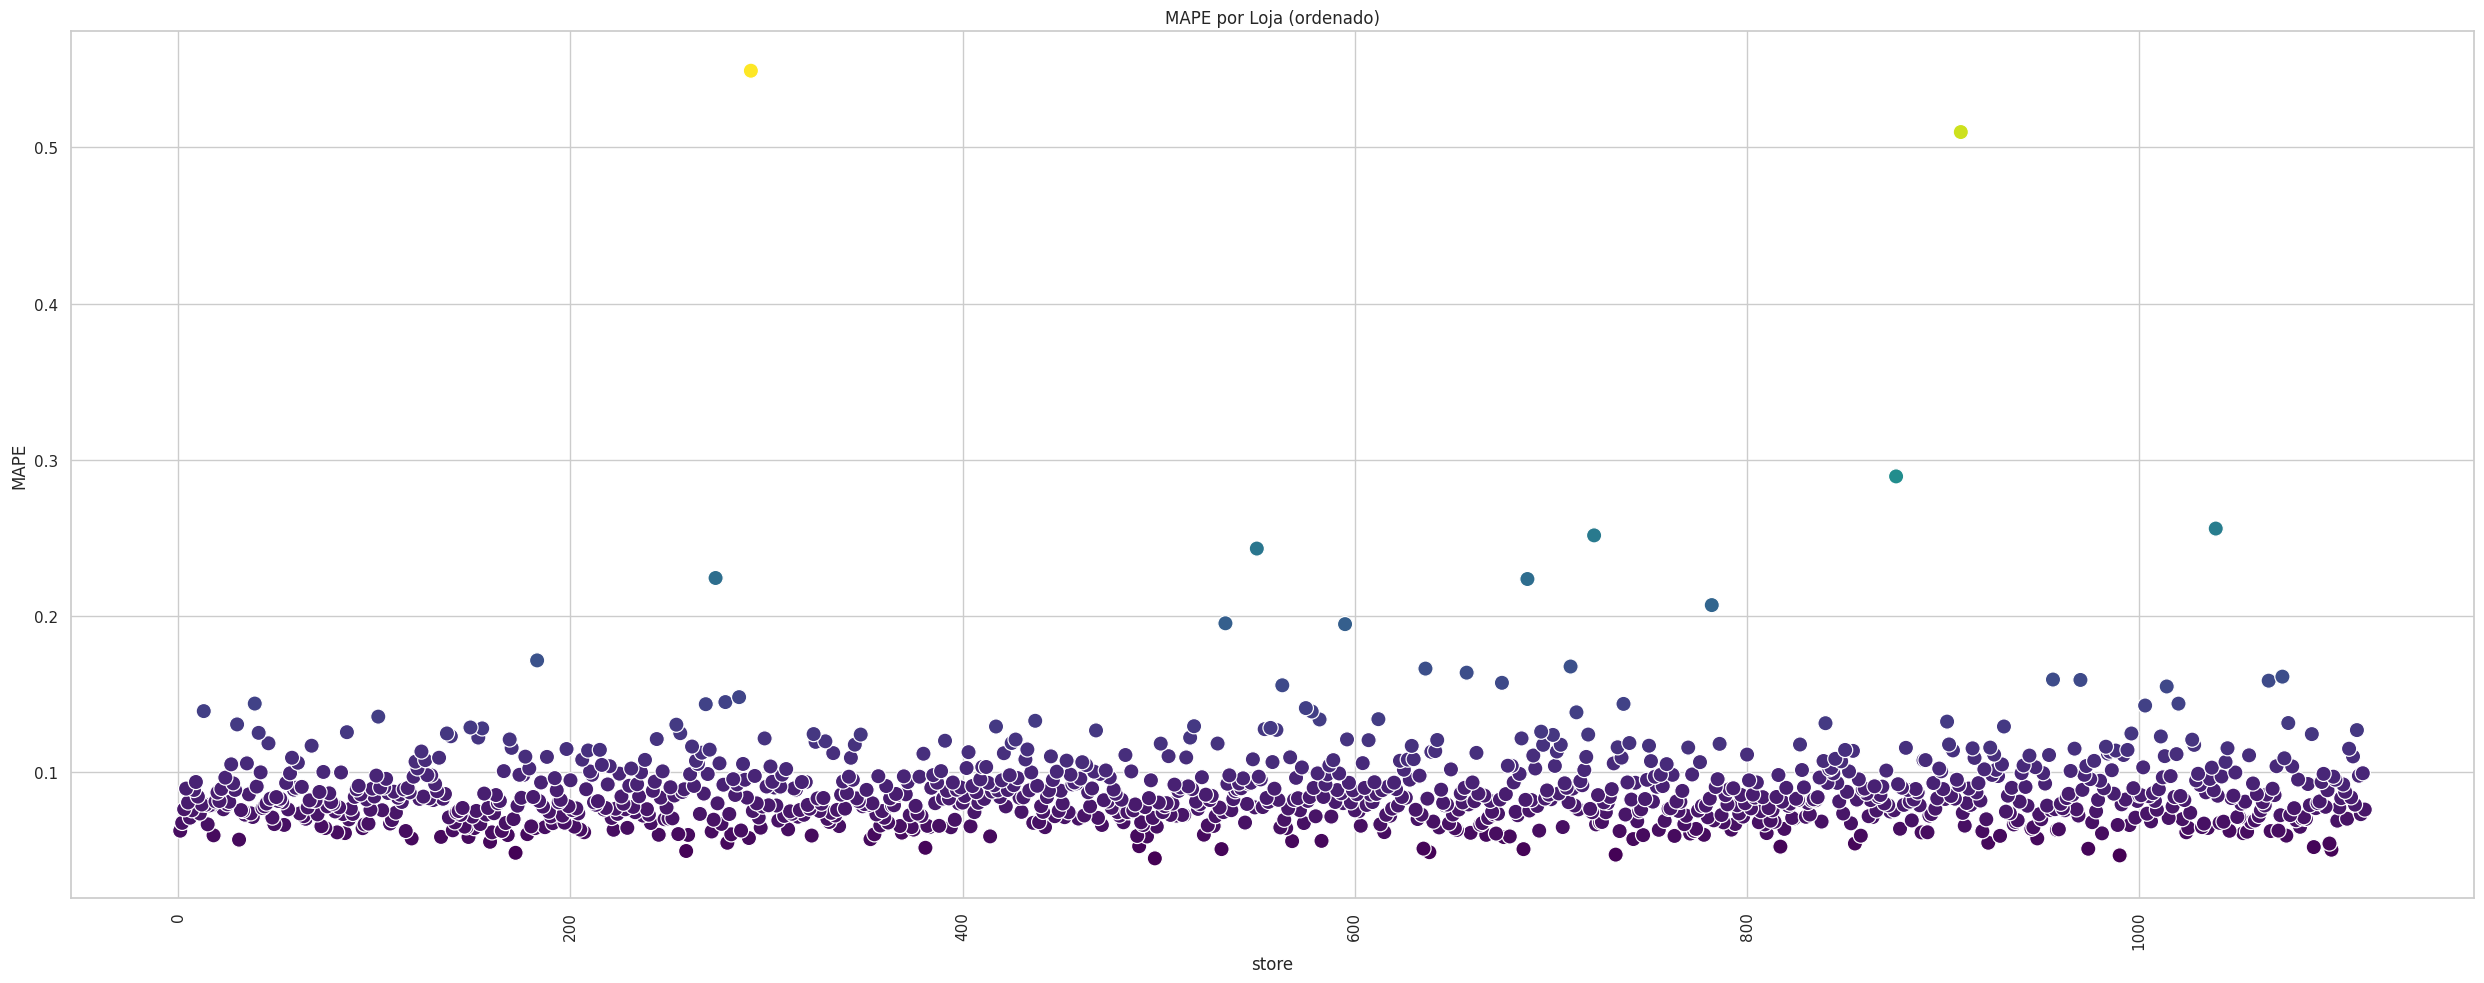

In [90]:
df92_sorted = df92.sort_values('MAPE')

plt.figure(figsize=(25,10))
sns.scatterplot(
    x='store', y='MAPE', data=df92_sorted, 
    s=120, hue='MAPE', palette='viridis', legend=False
)
plt.title('MAPE por Loja (ordenado)')
plt.xticks(rotation=90)
plt.tight_layout()

## 9.2 Total Performance

In [91]:
totals = df92[['predictions', 'worst_scenario', 'best_scenario']].sum()

df93 = (
    totals
    .reset_index()
    .rename(columns={'index': 'Scenario', 0: 'Values'})
)

df93['Values'] = df93['Values'].apply(lambda v: f'R${v:,.2f}')
df93

Scenario            Values
0     predictions  R$283,843,840.00
1  worst_scenario  R$283,163,126.07
2   best_scenario  R$284,524,510.06

## 9.3 Machine Learning Performance

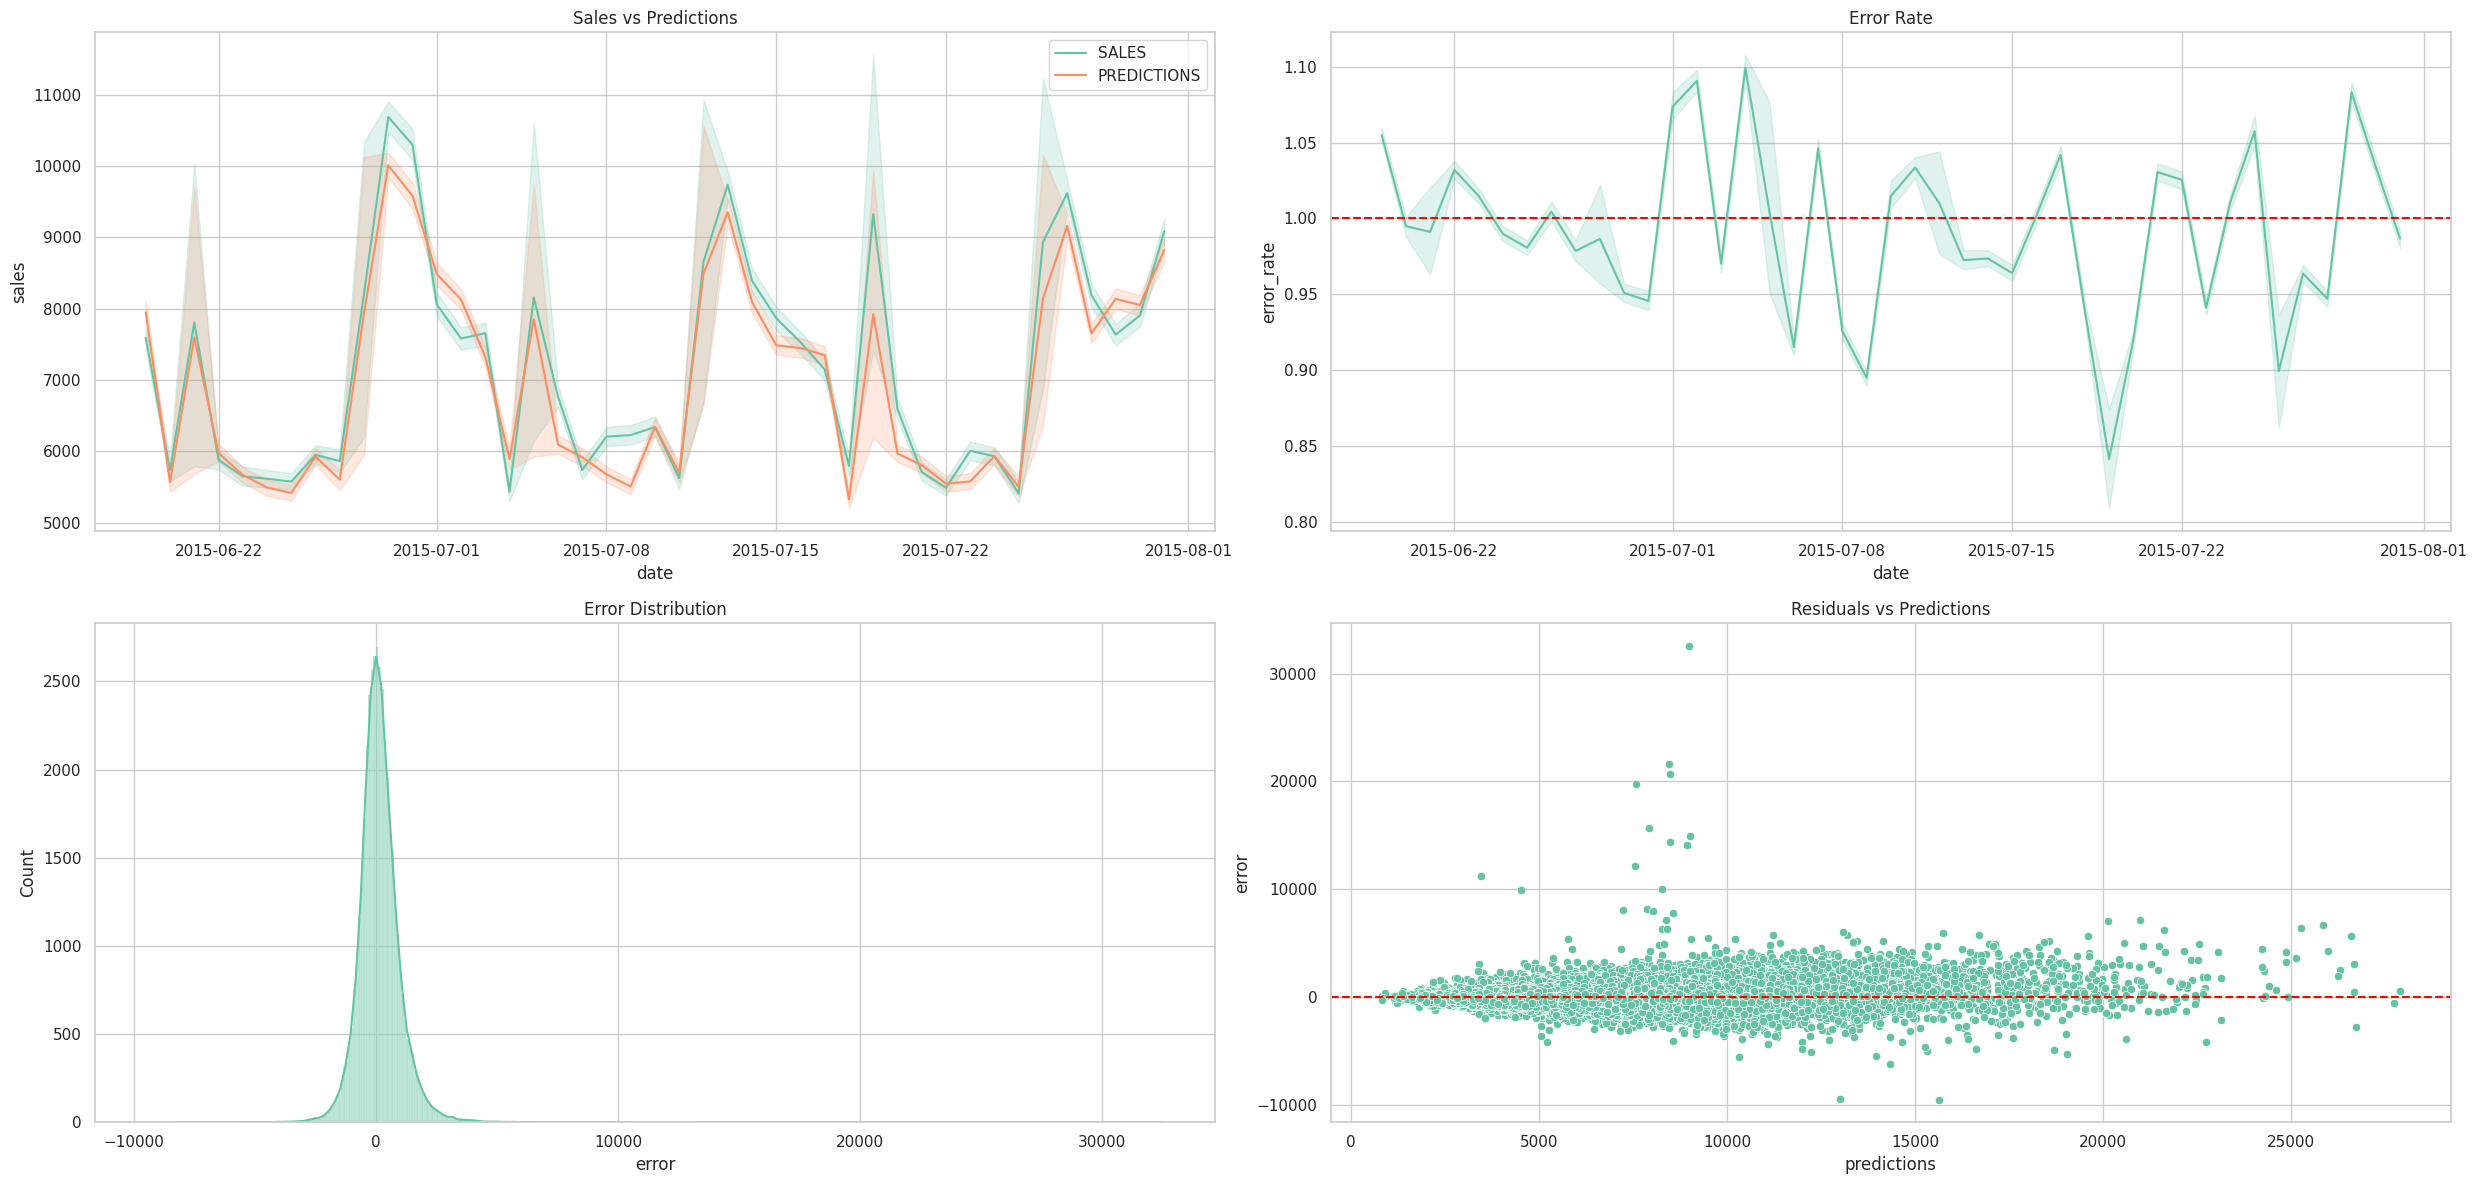

In [93]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

# 1 — Série temporal: vendas vs previsões
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')
plt.title("Sales vs Predictions")

# 2 — Error Rate ao longo do tempo
plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--', color='red')
plt.title("Error Rate")

# 3 — Distribuição do erro
plt.subplot(2, 2, 3)
sns.histplot(df9['error'], kde=True)
plt.title("Error Distribution")

# 4 — Resíduos vs Previsões
plt.subplot(2, 2, 4)
sns.scatterplot(x='predictions', y='error', data=df9)
plt.axhline(0, linestyle='--', color='red')
plt.title("Residuals vs Predictions")

plt.tight_layout()
plt.show()

# 10 - DEPLOY MODEL TO PRODUCTION

## 10.1 Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

class Rossmann(object):
    def __init__(self):
        self.home_path = '/mnt/c/Users/carlo/OneDrive/repos/ds_producao/'
        # scalers carregados do disco
        self.competition_distance_scaler = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))

    def data_cleaning(self, df1):
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']
        snakecase = lambda x: inflection.underscore(x)
        df1.columns = list(map(snakecase, cols_old))

        df1['date'] = pd.to_datetime(df1['date'])

        # substituindo NaNs
        df1['competition_distance'] = np.where(pd.isna(df1['competition_distance']), 200000.0, df1['competition_distance'])
        df1['competition_open_since_month'] = np.where(pd.isna(df1['competition_open_since_month']), df1['date'].dt.month, df1['competition_open_since_month'])
        df1['competition_open_since_year'] = np.where(pd.isna(df1['competition_open_since_year']), df1['date'].dt.year, df1['competition_open_since_year'])
        df1['promo2_since_week'] = np.where(pd.isna(df1['promo2_since_week']), df1['date'].dt.isocalendar().week, df1['promo2_since_week'])
        df1['promo2_since_year'] = np.where(pd.isna(df1['promo2_since_year']), df1['date'].dt.year, df1['promo2_since_year'])

        # promo_interval
        month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                     7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
        df1['promo_interval'] = df1['promo_interval'].fillna(0)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval','month_map']].apply(
            lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,
            axis=1
        )

        # converter colunas para int
        cols_int = ['competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year']
        df1[cols_int] = df1[cols_int].astype(int)

        return df1

    def feature_engineering(self, df2):
        df2['year'] = df2['date'].dt.year
        df2['month'] = df2['date'].dt.month
        df2['day'] = df2['date'].dt.day
        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(
            lambda x: datetime(year=int(x['competition_open_since_year']),
                               month=int(x['competition_open_since_month']),
                               day=1),
            axis=1
        )
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / timedelta(days=30)).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(
            lambda x: datetime.strptime(x + '-1','%Y-%W-%w') - timedelta(days=7)
        )
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / timedelta(weeks=1)).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

        # state_holiday
        df2['state_holiday'] = df2['state_holiday'].apply(
            lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day'
        )

        df2 = df2[df2['open'] != 0]
        df2 = df2.drop(['open','promo_interval','month_map'], axis=1)

        return df2

    def data_preparation(self, df5):
        # aplicar transform
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']])
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']])
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']])
        df5['year'] = self.year_scaler.transform(df5[['year']])

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'].astype(str))

        # assortment - Ordinal Encoding
        assortment_dict = {'basic':1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        # transformações trigonométricas
        df5['day_of_week_sin'] = np.sin(df5['day_of_week'] * 2. * np.pi/7)
        df5['day_of_week_cos'] = np.cos(df5['day_of_week'] * 2. * np.pi/7)
        df5['month_sin'] = np.sin(df5['month'] * 2. * np.pi/12)
        df5['month_cos'] = np.cos(df5['month'] * 2. * np.pi/12)
        df5['day_sin'] = np.sin(df5['day'] * 2. * np.pi/30)
        df5['day_cos'] = np.cos(df5['day'] * 2. * np.pi/30)
        df5['week_of_year_sin'] = np.sin(df5['week_of_year'] * 2. * np.pi/52)
        df5['week_of_year_cos'] = np.cos(df5['week_of_year'] * 2. * np.pi/52)

        cols_selected = [
            'store','promo','school_holiday','store_type','assortment',
            'competition_distance','competition_open_since_month','competition_open_since_year',
            'promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week',
            'day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos',
            'week_of_year_sin','week_of_year_cos'
        ]

        return df5[cols_selected]

    def get_prediction(self, model, original_data, test_data):
        
        df = original_data.copy()
        
        # Model prediction
        pred = model.predict(test_data)
        
        # Convert from log space and ensure Python float
        df['prediction'] = np.expm1(pred).astype(float)
        return df.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [ ]:
import pickle
import pandas as pd
from rossmann.Rossmann import Rossmann
from flask import Flask, request, Response, jsonify

# load model
model = pickle.load(open('/mnt/c/Users/carlo/OneDrive/repos/ds_producao/model/model_rossmann.pkl', 'rb'))

# instantiate pipeline
pipeline = Rossmann()

# initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    try:
        test_json = request.get_json()

        if not test_json:
            return jsonify({'error': 'No input data provided'}), 400

        # convert to DataFrame
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame([test_json])
        else:
            test_raw = pd.DataFrame(test_json)

        # pipeline
        df1 = pipeline.data_cleaning(test_raw)
        df2 = pipeline.feature_engineering(df1)
        df3 = pipeline.data_preparation(df2)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return Response(df_response, status=200, mimetype='application/json')

    except Exception as e:
        return jsonify({'error': str(e)}), 500


if __name__ == '__main__':
    app.run('0.0.0.0')


## 10.3 API Tester

In [5]:
# loading test dataset
df10 = pd.read_csv('/mnt/c/Users/carlo/OneDrive/repos/ds_producao/data/test.csv')

In [6]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
#df_test = df_test[df_test['Store'].isin( [22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [7]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [8]:
# API Call
url = 'http://0.0.0.0:5000/rossmann/predict'
#url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [9]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [10]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], 
                                                                            d2.loc[i, 'prediction'] ) )


Store Number 1 will sell R$172,609.91 in the next 6 weeks
Store Number 3 will sell R$279,618.80 in the next 6 weeks
Store Number 7 will sell R$381,372.07 in the next 6 weeks
Store Number 8 will sell R$235,376.52 in the next 6 weeks
Store Number 9 will sell R$299,068.36 in the next 6 weeks
Store Number 10 will sell R$221,624.23 in the next 6 weeks
Store Number 11 will sell R$306,300.53 in the next 6 weeks
Store Number 12 will sell R$302,712.95 in the next 6 weeks
Store Number 13 will sell R$196,481.26 in the next 6 weeks
Store Number 14 will sell R$219,006.85 in the next 6 weeks
Store Number 15 will sell R$275,006.69 in the next 6 weeks
Store Number 16 will sell R$305,565.80 in the next 6 weeks
Store Number 19 will sell R$273,427.35 in the next 6 weeks
Store Number 20 will sell R$309,841.91 in the next 6 weeks
Store Number 21 will sell R$218,516.05 in the next 6 weeks
Store Number 22 will sell R$178,026.66 in the next 6 weeks
Store Number 23 will sell R$224,854.05 in the next 6 weeks
St